## Analysis

In [5]:
import csv

input_csv = 'optimization_results.csv'
output_csv = 'optimization_results.cleaned.csv'

# Step 1: Read the header first
with open(input_csv, 'r', newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    header = next(reader)
    n_cols = len(header)

# Step 2: Process the file row by row
cleaned_rows = []

with open(input_csv, 'r', newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    header = next(reader)  # Skip header again
    for idx, row in enumerate(reader):
        if len(row) < n_cols:
            # Fill missing values with '0'
            missing = n_cols - len(row)
            row.extend(['0'] * missing)
            print(f"[Fix] Row {idx + 2}: Added {missing} missing value(s).")
        elif len(row) > n_cols:
            # Rare: Row too long — truncate
            row = row[:n_cols]
            print(f"[Fix] Row {idx + 2}: Truncated extra columns.")
        cleaned_rows.append(row)

# Step 3: Write out cleaned file
with open(output_csv, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(cleaned_rows)

print(f"✅ Cleaning complete. Output written to: {output_csv}")


[Fix] Row 96: Added 1 missing value(s).
[Fix] Row 97: Added 1 missing value(s).
[Fix] Row 98: Added 1 missing value(s).
[Fix] Row 99: Added 1 missing value(s).
[Fix] Row 100: Added 1 missing value(s).
[Fix] Row 101: Added 1 missing value(s).
[Fix] Row 102: Added 1 missing value(s).
[Fix] Row 103: Added 1 missing value(s).
[Fix] Row 104: Added 1 missing value(s).
[Fix] Row 105: Added 1 missing value(s).
[Fix] Row 106: Added 1 missing value(s).
[Fix] Row 107: Added 1 missing value(s).
[Fix] Row 108: Added 1 missing value(s).
[Fix] Row 109: Added 1 missing value(s).
[Fix] Row 110: Added 1 missing value(s).
[Fix] Row 111: Added 1 missing value(s).
[Fix] Row 112: Added 1 missing value(s).
[Fix] Row 113: Added 1 missing value(s).
[Fix] Row 114: Added 1 missing value(s).
[Fix] Row 115: Added 1 missing value(s).
[Fix] Row 116: Added 1 missing value(s).
[Fix] Row 117: Added 1 missing value(s).
[Fix] Row 118: Added 1 missing value(s).
[Fix] Row 119: Added 1 missing value(s).
[Fix] Row 120: Added

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your optimization results
df = pd.read_csv('optimization_results.cleaned.csv')

# Pricing (USD per 1M tokens)
costs = {
    'gpt-4o-mini-2024-07-18': {'input': 0.60, 'output': 2.40},
    'gpt-4o-2024-08-06': {'input': 5.00, 'output': 20.00},
    'claude-3-5-sonnet-20241022': {'input': 3.00, 'output': 15.00},
    'claude-3-7-sonnet-20250219': {'input': 3.00, 'output': 15.00},
    'gemini-1.5-flash': {'input': 0.075, 'output': 0.30},
    'gemini-2.0-flash': {'input': 0.10, 'output': 0.40},
    'gemini-1.5-flash-8b': {'input': 0.0375, 'output': 0.15},
}

# Only fill in input/output costs where model exists in costs
df['input_cost_per_mil'] = df['model'].apply(lambda m: costs[m]['input'] if m in costs else None)
df['output_cost_per_mil'] = df['model'].apply(lambda m: costs[m]['output'] if m in costs else None)

# Drop rows with missing cost info (optional)
df = df.dropna(subset=['input_cost_per_mil', 'output_cost_per_mil'])

# Normalize cost by function length
df['input_cost_per_line'] = df['input_cost_per_mil'] / df['function_length']
df['output_cost_per_line'] = df['output_cost_per_mil'] / df['function_length']

# Compute average normalized costs per provider
provider_summary = (
    df
    .groupby('provider')[['input_cost_per_line', 'output_cost_per_line']]
    .mean()
    .reset_index()
)
print(provider_summary)

# Plot: function length vs normalized input cost per line
plt.scatter(df['function_length'], df['input_cost_per_line'])
plt.xlabel('Function Length (lines)')
plt.ylabel('Input Cost per Line ($ per 1M tokens)')
plt.title('Function Length vs. Normalized Input Cost per Line')
plt.grid(True)
plt.show()


    provider  input_cost_per_line  output_cost_per_line
0  anthropic             0.608798              3.043991
1     google             0.011536              0.046145
2     openai             0.189838              0.759354


In [10]:
import pandas as pd

# Load the cleaned data
df = pd.read_csv('optimization_results.cleaned.csv')

# Define Gemini model input costs (USD per 1M tokens)
gemini_costs = {
    'gemini-1.5-flash': 0.075,
    'gemini-2.0-flash': 0.10,
    'gemini-1.5-flash-8b': 0.0375,
}

# Step 1: Keep only Google's models
df = df[df['model'].isin(gemini_costs.keys())]

# Step 2: Calculate improvement metric
# We'll use 'globe_cycles_improvement' as the target improvement (you can swap it for others if needed)

# Convert to numeric safely (in case '0' was filled as string)
df['globe_cycles_improvement'] = pd.to_numeric(df['globe_cycles_improvement'], errors='coerce')

# Step 3: Filter out rows with 0 or missing improvement
df = df[(df['globe_cycles_improvement'] != 0) & (~df['globe_cycles_improvement'].isna())]

# Step 4: Add model input cost
df['input_cost_per_mil'] = df['model'].map(gemini_costs)

# Step 5: Calculate bang-for-buck = improvement (%) / input cost ($ per 1M tokens)
df['bang_for_buck'] = df['globe_cycles_improvement'] / df['input_cost_per_mil']

# Step 6: Group by model and calculate average
result = df.groupby('model')['bang_for_buck'].mean().sort_values(ascending=False)

print("📈 Average bang-for-buck per model (higher is better):")
print(result)


📈 Average bang-for-buck per model (higher is better):
model
gemini-1.5-flash-8b    167.974139
gemini-1.5-flash        83.220185
gemini-2.0-flash        56.025814
Name: bang_for_buck, dtype: float64


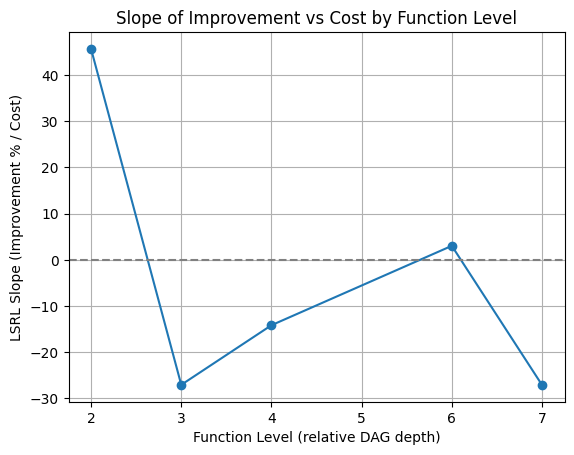

📊 Slopes per function level:
Level 2: Slope = 45.6716
Level 3: Slope = -27.0770
Level 4: Slope = -14.1699
Level 6: Slope = 3.0249
Level 7: Slope = -27.1003


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# 1. Load the cleaned data
df = pd.read_csv('optimization_results.cleaned.csv')

# 2. Filter: only Google's Gemini models
gemini_models = ['gemini-1.5-flash', 'gemini-2.0-flash', 'gemini-1.5-flash-8b']
df = df[df['model'].isin(gemini_models)]

# 3. Ensure columns are numeric
df['function_relative_level'] = pd.to_numeric(df['function_relative_level'], errors='coerce')
df['globe_cycles_improvement'] = pd.to_numeric(df['globe_cycles_improvement'], errors='coerce')

# Define model costs
gemini_costs = {
    'gemini-1.5-flash': 0.075,
    'gemini-2.0-flash': 0.10,
    'gemini-1.5-flash-8b': 0.0375,
}
df['input_cost_per_mil'] = df['model'].map(gemini_costs)

# 4. Drop rows with missing or zero improvements
df = df[(df['globe_cycles_improvement'] != 0) & (~df['globe_cycles_improvement'].isna())]
df = df[(df['function_relative_level'].notna()) & (df['input_cost_per_mil'].notna())]

# 5. Group by function level
slopes = {}

levels = sorted(df['function_relative_level'].unique())
for level in levels:
    subset = df[df['function_relative_level'] == level]
    
    if len(subset) < 2:
        # Need at least 2 points to fit a line
        continue
    
    x = subset['input_cost_per_mil']
    y = subset['globe_cycles_improvement']
    
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    slopes[level] = slope

# 6. Plot slope vs function level
levels_sorted = sorted(slopes.keys())
slope_values = [slopes[lvl] for lvl in levels_sorted]

plt.plot(levels_sorted, slope_values, marker='o')
plt.xlabel('Function Level (relative DAG depth)')
plt.ylabel('LSRL Slope (Improvement % / Cost)')
plt.title('Slope of Improvement vs Cost by Function Level')
plt.grid(True)
plt.axhline(0, color='gray', linestyle='--')
plt.show()

# 7. Print raw slopes
print("📊 Slopes per function level:")
for lvl in levels_sorted:
    print(f"Level {lvl}: Slope = {slopes[lvl]:.4f}")


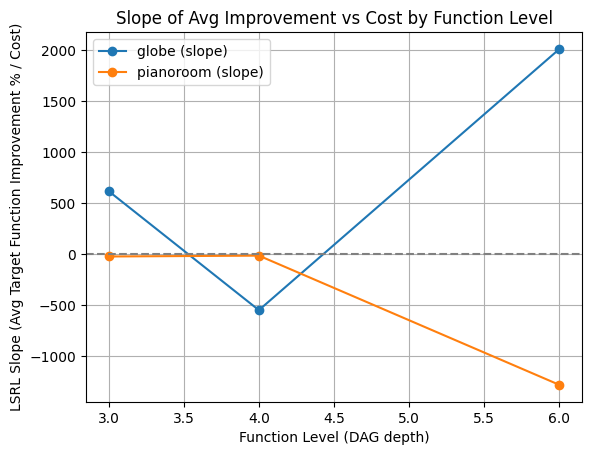

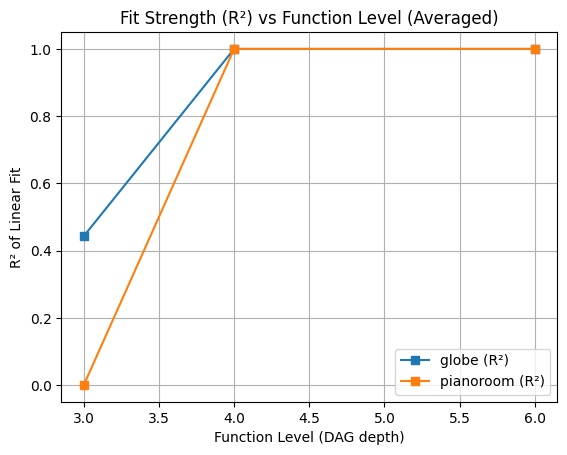

   level  benchmark        slope  r_squared  n_points
0      3      globe   619.244961   0.443235         3
1      3  pianoroom   -23.021250   0.000646         3
2      4      globe  -549.763648   1.000000         2
3      4  pianoroom   -14.728722   1.000000         2
4      6      globe  2014.294559   1.000000         2
5      6  pianoroom -1283.759289   1.000000         2


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Load cleaned dataset
df = pd.read_csv('optimization_results.cleaned.csv')

# Filter for Gemini models only
gemini_models = ['gemini-1.5-flash', 'gemini-2.0-flash', 'gemini-1.5-flash-8b']
gemini_costs = {
    'gemini-1.5-flash': 0.075,
    'gemini-2.0-flash': 0.10,
    'gemini-1.5-flash-8b': 0.0375,
}

df = df[df['model'].isin(gemini_models)]
df['input_cost_per_mil'] = df['model'].map(gemini_costs)

# Ensure numeric conversion
df['function_relative_level'] = pd.to_numeric(df['function_relative_level'], errors='coerce')
df['globe_cycles_target_function_improvement'] = pd.to_numeric(df['globe_cycles_target_function_improvement'], errors='coerce')
df['pianoroom_cycles_target_function_improvement'] = pd.to_numeric(df['pianoroom_cycles_target_function_improvement'], errors='coerce')

# Drop rows with missing, zero, or negative improvements
df = df[df['function_relative_level'].notna()]
df = df[df['input_cost_per_mil'].notna()]
df = df[df['globe_cycles_target_function_improvement'].notna() & (df['globe_cycles_target_function_improvement'] > 0)]
df = df[df['pianoroom_cycles_target_function_improvement'].notna() & (df['pianoroom_cycles_target_function_improvement'] > 0)]

# Group by level and compute regression stats
results = []
for level, group in df.groupby('function_relative_level'):
    if len(group) < 2:
        continue

    for benchmark, improvement_col in [
        ('globe', 'globe_cycles_target_function_improvement'),
        ('pianoroom', 'pianoroom_cycles_target_function_improvement')
    ]:
        # Group by cost and take the average improvement per model
        averaged = group.groupby('input_cost_per_mil')[improvement_col].mean().reset_index()

        if len(averaged) < 2:
            continue  # Need at least two points for regression

        x = averaged['input_cost_per_mil']
        y = averaged[improvement_col]

        # Linear regression
        slope, intercept, r_value, p_value, std_err = linregress(x, y)

        results.append({
            'level': level,
            'benchmark': benchmark,
            'slope': slope,
            'r_squared': r_value ** 2,
            'n_points': len(averaged),
        })

# Create results DataFrame
results_df = pd.DataFrame(results)

# Plotting slope vs level for both benchmarks
fig, ax = plt.subplots()
for benchmark in results_df['benchmark'].unique():
    sub = results_df[results_df['benchmark'] == benchmark]
    ax.plot(sub['level'], sub['slope'], marker='o', label=f'{benchmark} (slope)')
ax.axhline(0, color='gray', linestyle='--')
ax.set_xlabel('Function Level (DAG depth)')
ax.set_ylabel('LSRL Slope (Avg Target Function Improvement % / Cost)')
ax.set_title('Slope of Avg Improvement vs Cost by Function Level')
ax.grid(True)
ax.legend()
plt.show()

# Plotting r-squared vs level
fig, ax = plt.subplots()
for benchmark in results_df['benchmark'].unique():
    sub = results_df[results_df['benchmark'] == benchmark]
    ax.plot(sub['level'], sub['r_squared'], marker='s', label=f'{benchmark} (R²)')
ax.set_xlabel('Function Level (DAG depth)')
ax.set_ylabel('R² of Linear Fit')
ax.set_title('Fit Strength (R²) vs Function Level (Averaged)')
ax.grid(True)
ax.legend()
plt.show()

# Display table of results
print(results_df)


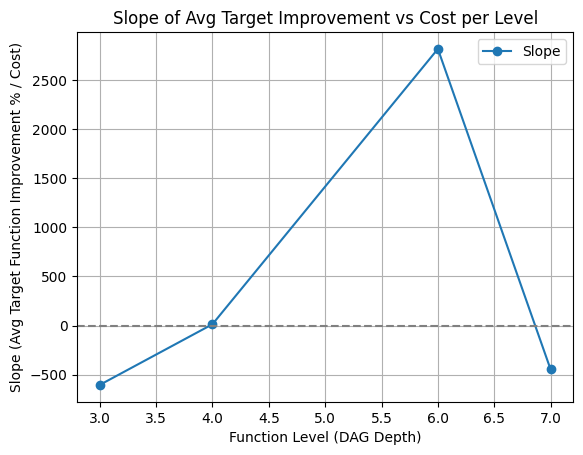

   level        slope  r_squared  n_points
0      3  -603.087022   0.147340         3
1      4    14.016147   0.001403         3
2      6  2814.670344   1.000000         2
3      7  -445.820702   0.988803         3


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Load cleaned dataset
df = pd.read_csv('optimization_results.cleaned.csv')

# Focus only on Gemini models
gemini_models = ['gemini-1.5-flash', 'gemini-2.0-flash', 'gemini-1.5-flash-8b']
gemini_costs = {
    'gemini-1.5-flash': 0.075,
    'gemini-2.0-flash': 0.10,
    'gemini-1.5-flash-8b': 0.0375,
}
df = df[df['model'].isin(gemini_models)]
df['input_cost_per_mil'] = df['model'].map(gemini_costs)

# Ensure proper numeric conversion
df['function_relative_level'] = pd.to_numeric(df['function_relative_level'], errors='coerce')
df['globe_cycles_target_function_improvement'] = pd.to_numeric(df['globe_cycles_target_function_improvement'], errors='coerce')

# Drop invalid rows
df = df[
    (df['globe_cycles_target_function_improvement'].notna()) &
    (df['globe_cycles_target_function_improvement'] != 0) &
    (df['function_relative_level'].notna()) &
    (df['input_cost_per_mil'].notna())
]

# Initialize result collection
results = []

# Loop over each level
for level, group in df.groupby('function_relative_level'):
    if len(group) < 2:
        continue  # Need at least two models

    # Group by model (input cost) and compute average improvement
    grouped = group.groupby('input_cost_per_mil')['globe_cycles_target_function_improvement'].mean().reset_index()

    if len(grouped) < 2:
        continue  # Still need at least two distinct input costs

    x = grouped['input_cost_per_mil']
    y = grouped['globe_cycles_target_function_improvement']

    # Fit LSRL on averaged points
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Save result
    results.append({
        'level': level,
        'slope': slope,
        'r_squared': r_value**2,
        'n_points': len(grouped),
    })

# Compile all results
results_df = pd.DataFrame(results)

# === PLOT slope vs level ===
fig, ax = plt.subplots()
ax.plot(results_df['level'], results_df['slope'], marker='o', label='Slope')
ax.axhline(0, color='gray', linestyle='--')
ax.set_xlabel('Function Level (DAG Depth)')
ax.set_ylabel('Slope (Avg Target Function Improvement % / Cost)')
ax.set_title('Slope of Avg Target Improvement vs Cost per Level')
ax.grid(True)
ax.legend()
plt.show()

# === PLOT R² vs level ===
fig, ax = plt.subplots()
ax.plot(results_df['level'], results_df['r_squared'], marker='s', label='R²')
ax.set_xlabel('Function Level (DAG Depth)')
ax.set_ylabel('R² of Linear Fit')
ax.set_title('Fit Strength (R²) vs Function Level')
ax.grid(True)
ax.legend()
plt.show()

# Print results
print(results_df)



--- Data Summary ---
       function_relative_level  function_length  obfuscation_tier  \
count               257.000000       257.000000        257.000000   
mean                  5.151751        15.840467          1.435798   
std                   1.779969        19.502650          1.501550   
min                   2.000000         3.000000          0.000000   
25%                   4.000000         5.000000          0.000000   
50%                   6.000000         7.000000          0.000000   
75%                   7.000000        31.000000          3.000000   
max                   7.000000        62.000000          3.000000   

       callee_depth  globe_baseline_cycles  globe_baseline_runtime  \
count    257.000000           2.570000e+02              257.000000   
mean       0.521401           8.573489e+09             1790.303784   
std        0.500517           1.220062e+07                3.917094   
min        0.000000           8.551661e+09             1788.122791   
25%   

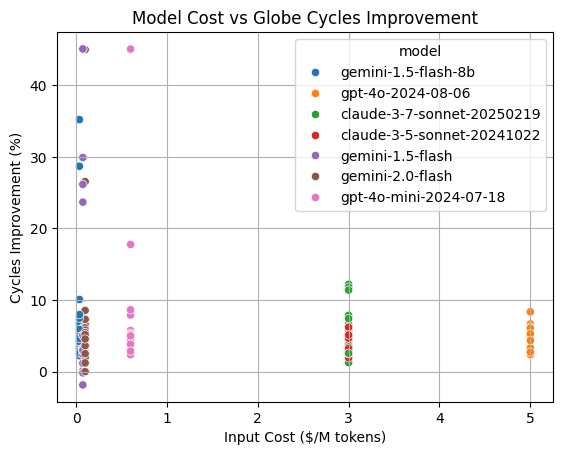

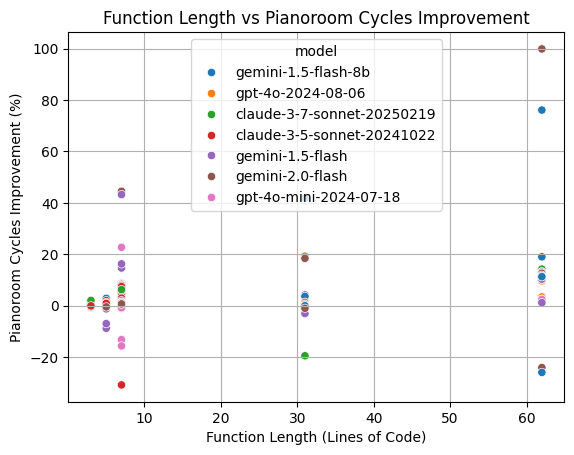

/tmp/ipykernel_2164410/532345343.py:67: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='function_relative_level', y='globe_cycles_improvement', ci=None)


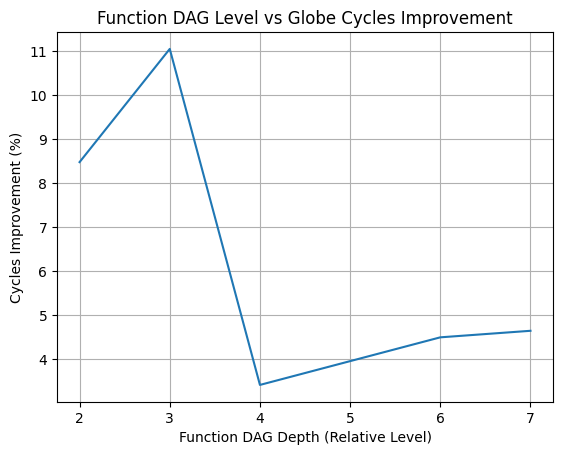

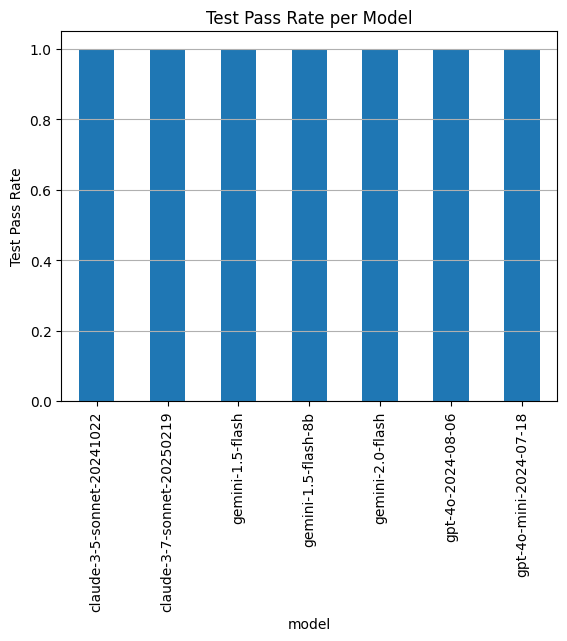

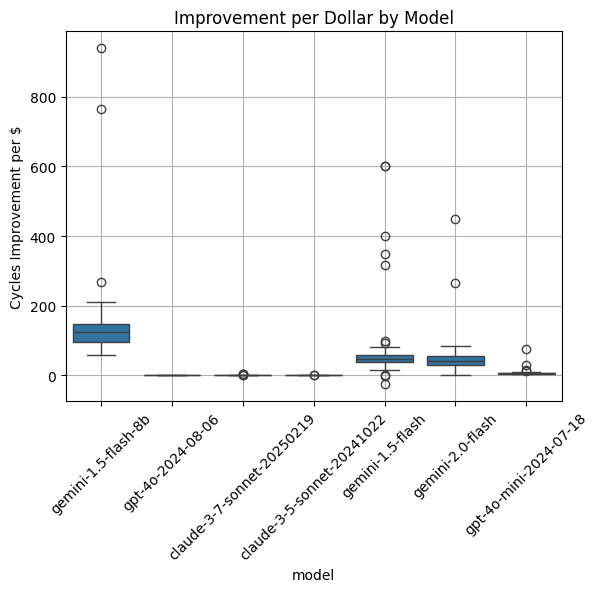


--- Notebook Complete ---


In [5]:
# Starter notebook to explore optimization results

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load Data ---
df = pd.read_csv('optimization_results.cleaned.csv')

# --- Map Model Costs ---
costs = {
    'gpt-4o-mini-2024-07-18': {'input': 0.60, 'output': 2.40},
    'gpt-4o-2024-08-06': {'input': 5.00, 'output': 20.00},
    'claude-3-5-sonnet-20241022': {'input': 3.00, 'output': 15.00},
    'claude-3-7-sonnet-20250219': {'input': 3.00, 'output': 15.00},
    'gemini-1.5-flash': {'input': 0.075, 'output': 0.30},
    'gemini-2.0-flash': {'input': 0.10, 'output': 0.40},
    'gemini-1.5-flash-8b': {'input': 0.0375, 'output': 0.15},
}

# Add cost columns
df['input_cost_per_mil'] = df['model'].map(lambda m: costs.get(m, {}).get('input', np.nan))
df['output_cost_per_mil'] = df['model'].map(lambda m: costs.get(m, {}).get('output', np.nan))

# --- Basic Cleaning ---
for col in [
    'function_relative_level', 'function_length', 'callee_depth',
    'globe_cycles_improvement', 'pianoroom_cycles_improvement',
    'globe_runtime_improvement', 'pianoroom_runtime_improvement'
]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# --- Summary Stats ---
print("\n--- Data Summary ---")
print(df.describe())

# --- 1. Model Cost vs Cycles Improvement ---
plt.figure()
sns.scatterplot(data=df, x='input_cost_per_mil', y='globe_cycles_improvement', hue='model')
plt.title('Model Cost vs Globe Cycles Improvement')
plt.xlabel('Input Cost ($/M tokens)')
plt.ylabel('Cycles Improvement (%)')
plt.grid(True)
plt.show()

# --- 2. Function Length vs Pianoroom Cycles Improvement ---
plt.figure()
sns.scatterplot(data=df, x='function_length', y='pianoroom_cycles_improvement', hue='model')
plt.title('Function Length vs Pianoroom Cycles Improvement')
plt.xlabel('Function Length (Lines of Code)')
plt.ylabel('Pianoroom Cycles Improvement (%)')
plt.grid(True)
plt.show()

# --- 3. Obfuscation Tier vs Improvement ---
plt.figure()
sns.boxplot(data=df, x='obfuscation_tier', y='globe_cycles_improvement')
plt.title('Obfuscation Tier vs Globe Cycles Improvement')
plt.xlabel('Obfuscation Tier')
plt.ylabel('Cycles Improvement (%)')
plt.grid(True)
plt.show()

# --- 4. Function Relative Level vs Globe Cycles Improvement ---
plt.figure()
sns.lineplot(data=df, x='function_relative_level', y='globe_cycles_improvement', ci=None)
plt.title('Function DAG Level vs Globe Cycles Improvement')
plt.xlabel('Function DAG Depth (Relative Level)')
plt.ylabel('Cycles Improvement (%)')
plt.grid(True)
plt.show()

# --- 5. Tests Passed Rate per Model ---
plt.figure()
(df.groupby('model')['tests_passed']
   .mean()
   .sort_values()
   .plot(kind='bar', title='Test Pass Rate per Model'))
plt.ylabel('Test Pass Rate')
plt.grid(axis='y')
plt.show()

# --- Advanced (Optional): Improvement per Dollar ---
df['globe_improvement_per_dollar'] = df['globe_cycles_improvement'] / df['input_cost_per_mil']

plt.figure()
sns.boxplot(data=df, x='model', y='globe_improvement_per_dollar')
plt.title('Improvement per Dollar by Model')
plt.ylabel('Cycles Improvement per $')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

print("\n--- Notebook Complete ---")


--- Data Summary ---
       function_relative_level  function_length  obfuscation_tier  \
count                93.000000        93.000000         93.000000   
mean                  4.236559        33.537634          1.612903   
std                   1.210442        23.618599          1.503852   
min                   3.000000         3.000000          0.000000   
25%                   3.000000         3.000000          0.000000   
50%                   4.000000        31.000000          3.000000   
75%                   6.000000        62.000000          3.000000   
max                   6.000000        62.000000          3.000000   

       callee_depth  globe_baseline_cycles  globe_baseline_runtime  \
count     93.000000           9.300000e+01               93.000000   
mean       0.505376           8.561509e+09             1794.149836   
std        0.502681           1.367036e+07                4.388965   
min        0.000000           8.551661e+09             1788.122791   
25%   

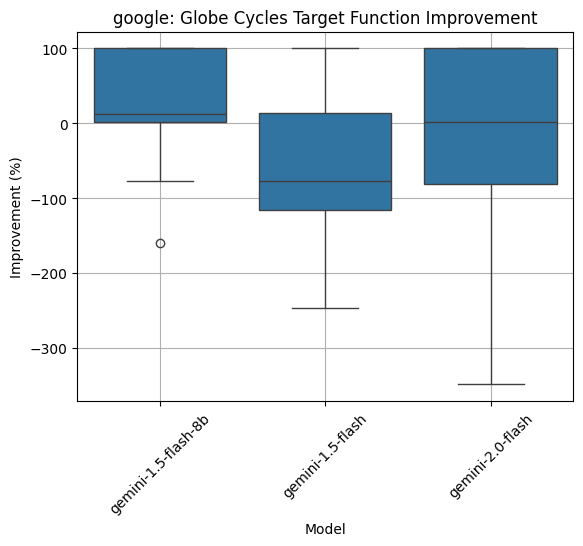

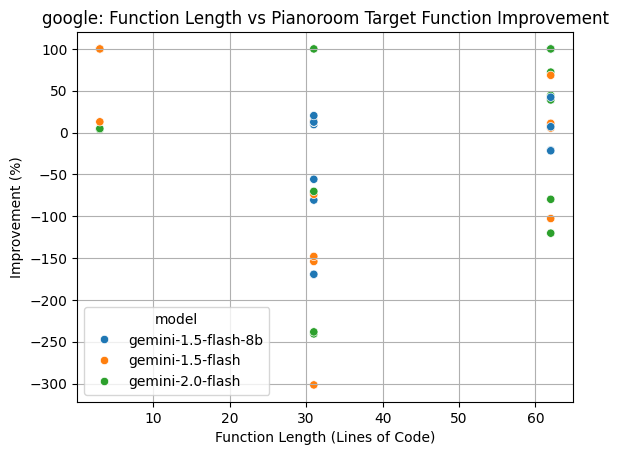

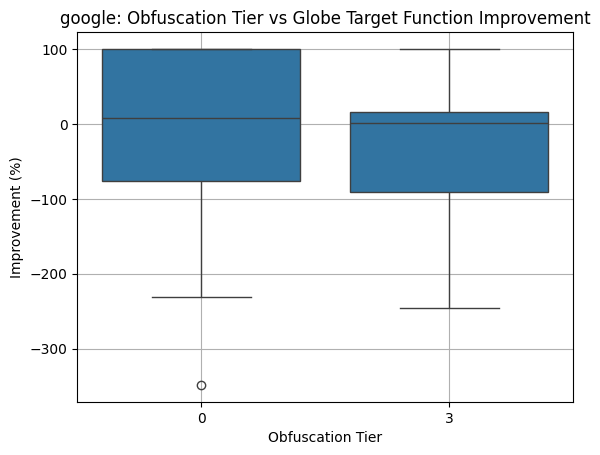

/tmp/ipykernel_2164410/3246678329.py:79: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=sub, x='function_relative_level', y='globe_cycles_target_function_improvement', hue='model', ci=None)


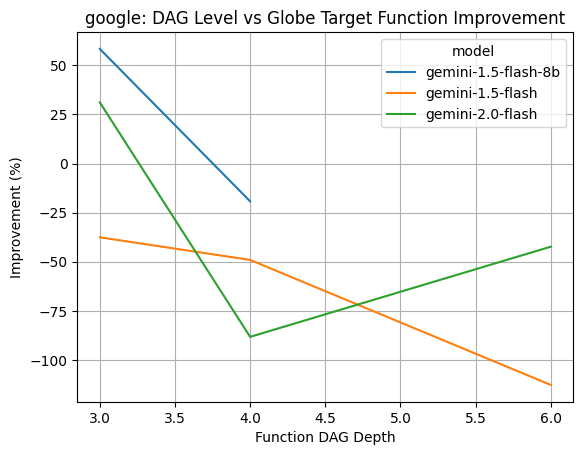

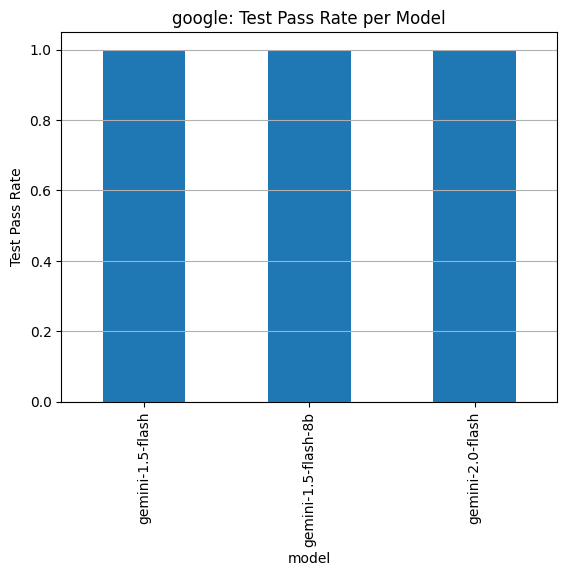

/tmp/ipykernel_2164410/3246678329.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['globe_improvement_per_dollar'] = sub['globe_cycles_target_function_improvement'] / sub['input_cost_per_mil']


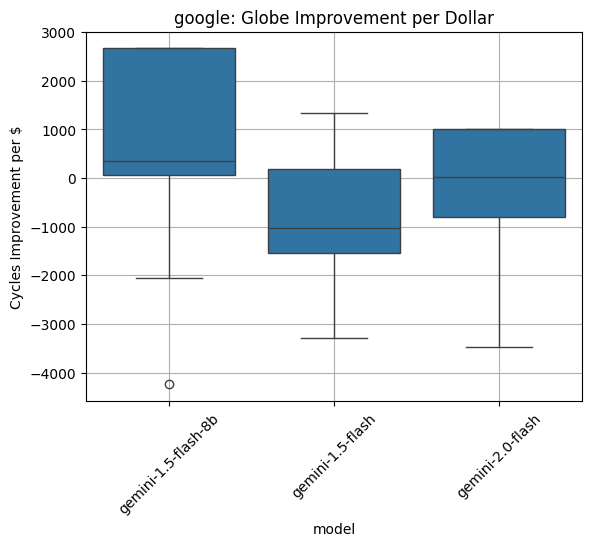


--- Provider: openai ---


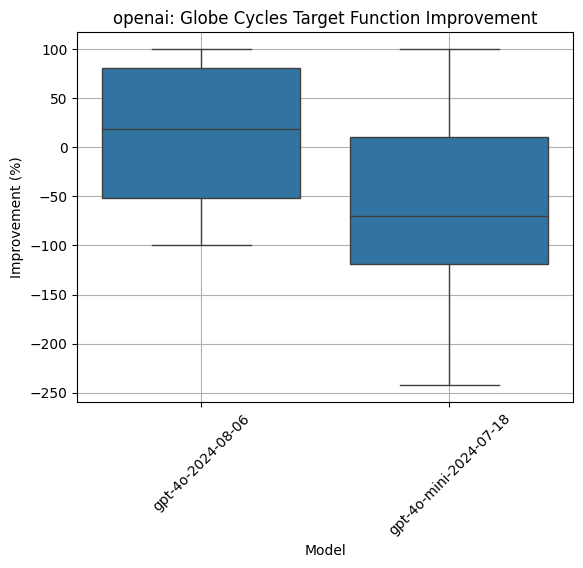

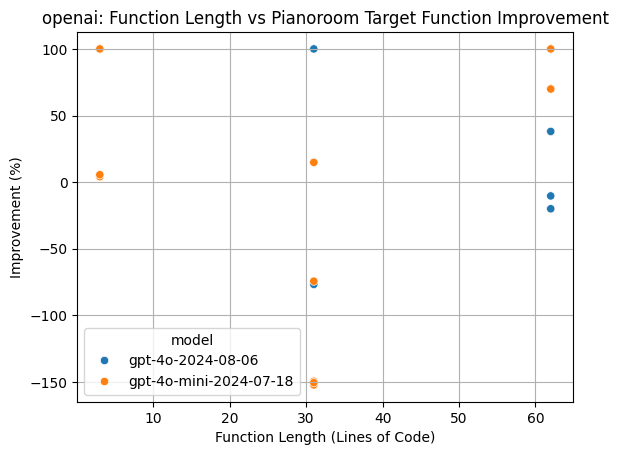

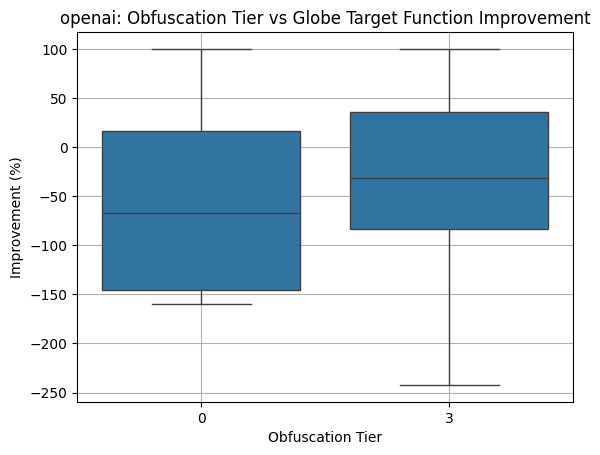

/tmp/ipykernel_2164410/3246678329.py:79: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=sub, x='function_relative_level', y='globe_cycles_target_function_improvement', hue='model', ci=None)


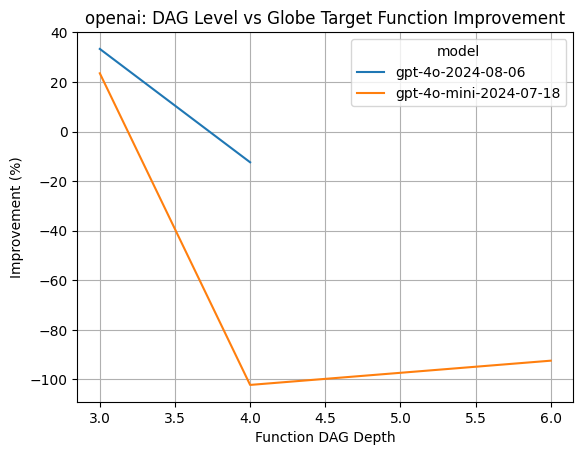

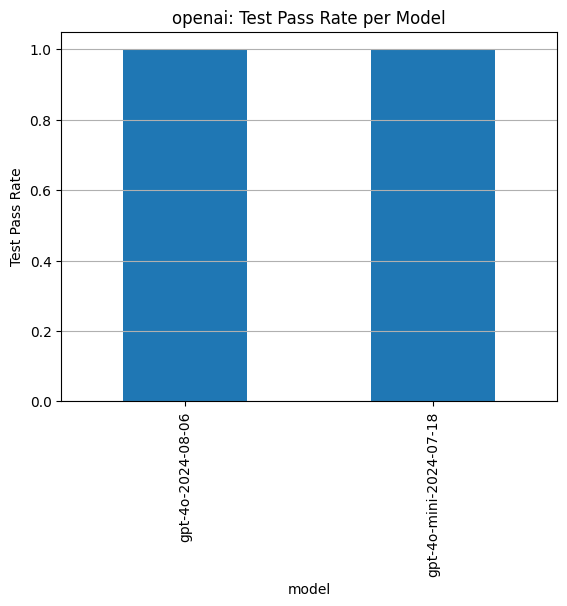

/tmp/ipykernel_2164410/3246678329.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['globe_improvement_per_dollar'] = sub['globe_cycles_target_function_improvement'] / sub['input_cost_per_mil']



--- Provider: anthropic ---


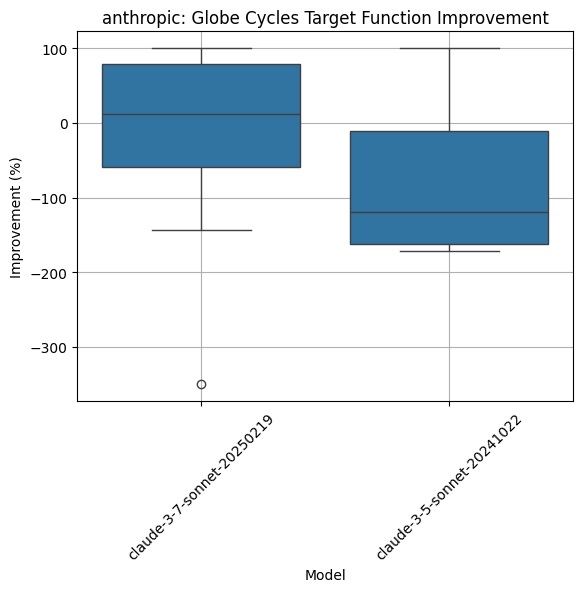

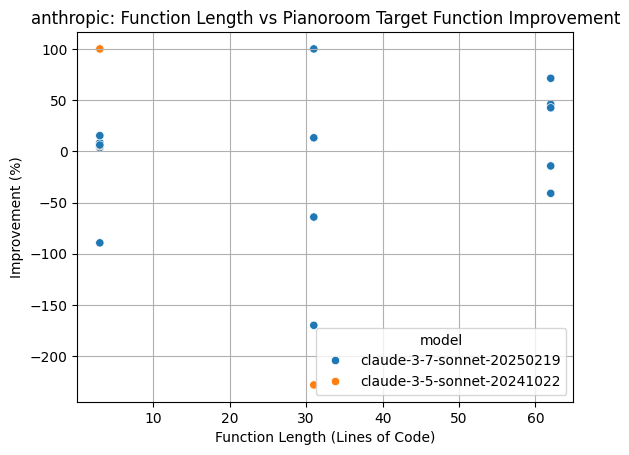

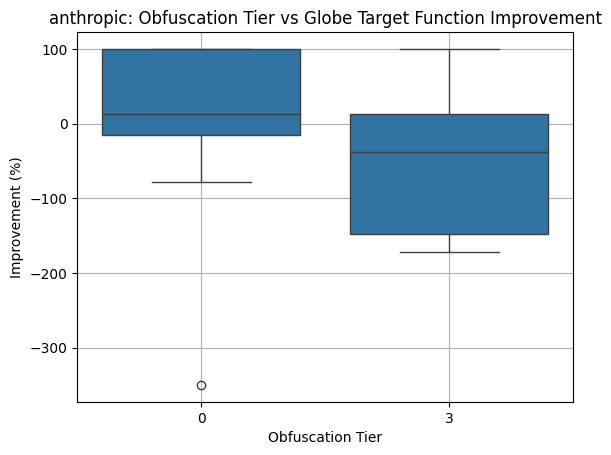

/tmp/ipykernel_2164410/3246678329.py:79: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=sub, x='function_relative_level', y='globe_cycles_target_function_improvement', hue='model', ci=None)


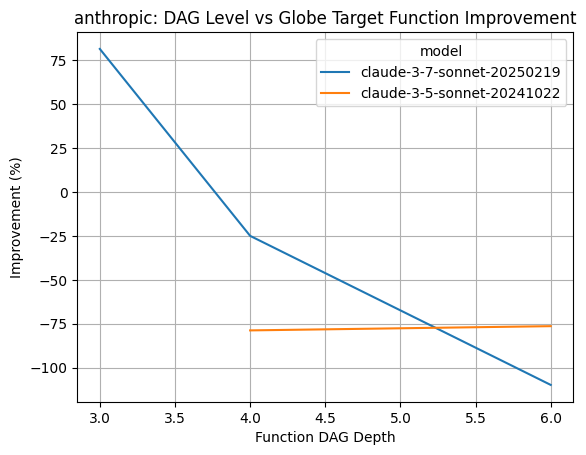

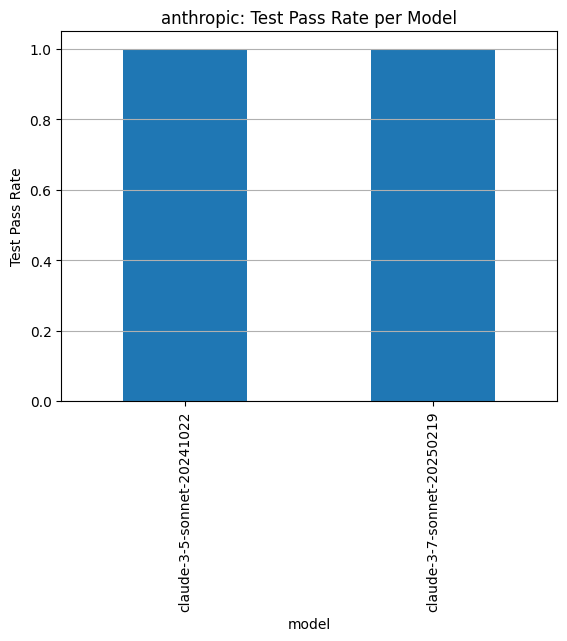

/tmp/ipykernel_2164410/3246678329.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['globe_improvement_per_dollar'] = sub['globe_cycles_target_function_improvement'] / sub['input_cost_per_mil']



--- Provider-specific analysis complete ---


In [6]:
# Starter notebook to explore optimization results

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load Data ---
df = pd.read_csv('optimization_results.cleaned.csv')

# --- Map Model Costs ---
costs = {
    'gpt-4o-mini-2024-07-18': {'input': 0.60, 'output': 2.40},
    'gpt-4o-2024-08-06': {'input': 5.00, 'output': 20.00},
    'claude-3-5-sonnet-20241022': {'input': 3.00, 'output': 15.00},
    'claude-3-7-sonnet-20250219': {'input': 3.00, 'output': 15.00},
    'gemini-1.5-flash': {'input': 0.075, 'output': 0.30},
    'gemini-2.0-flash': {'input': 0.10, 'output': 0.40},
    'gemini-1.5-flash-8b': {'input': 0.0375, 'output': 0.15},
}

# Add cost columns
df['input_cost_per_mil'] = df['model'].map(lambda m: costs.get(m, {}).get('input', np.nan))
df['output_cost_per_mil'] = df['model'].map(lambda m: costs.get(m, {}).get('output', np.nan))

# --- Basic Cleaning ---
for col in [
    'function_relative_level', 'function_length', 'callee_depth',
    'globe_cycles_improvement', 'pianoroom_cycles_improvement',
    'globe_runtime_improvement', 'pianoroom_runtime_improvement',
    'globe_cycles_target_function_improvement', 'pianoroom_cycles_target_function_improvement'
]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Remove invalid improvements (0 or -1 treated as errors)
invalid = lambda x: (x == 0) | (x == -1)
df = df[~invalid(df['globe_cycles_target_function_improvement'])]
df = df[~invalid(df['pianoroom_cycles_target_function_improvement'])]

# --- Summary Stats ---
print("\n--- Data Summary ---")
print(df.describe())

# --- Grouped Analysis by Provider ---
for provider in df['provider'].dropna().unique():
    sub = df[df['provider'] == provider]
    print(f"\n--- Provider: {provider} ---")

    # 1. Model Cost vs Globe Cycles Improvement
    plt.figure()
    sns.boxplot(data=sub, x='model', y='globe_cycles_target_function_improvement')
    plt.title(f'{provider}: Globe Cycles Target Function Improvement')
    plt.xlabel('Model')
    plt.ylabel('Improvement (%)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

    # 2. Function Length vs Pianoroom Improvement
    plt.figure()
    sns.scatterplot(data=sub, x='function_length', y='pianoroom_cycles_target_function_improvement', hue='model')
    plt.title(f'{provider}: Function Length vs Pianoroom Target Function Improvement')
    plt.xlabel('Function Length (Lines of Code)')
    plt.ylabel('Improvement (%)')
    plt.grid(True)
    plt.show()

    # 3. Obfuscation Tier vs Globe Improvement
    plt.figure()
    sns.boxplot(data=sub, x='obfuscation_tier', y='globe_cycles_target_function_improvement')
    plt.title(f'{provider}: Obfuscation Tier vs Globe Target Function Improvement')
    plt.xlabel('Obfuscation Tier')
    plt.ylabel('Improvement (%)')
    plt.grid(True)
    plt.show()

    # 4. Function DAG Level vs Globe Improvement
    plt.figure()
    sns.lineplot(data=sub, x='function_relative_level', y='globe_cycles_target_function_improvement', hue='model', ci=None)
    plt.title(f'{provider}: DAG Level vs Globe Target Function Improvement')
    plt.xlabel('Function DAG Depth')
    plt.ylabel('Improvement (%)')
    plt.grid(True)
    plt.show()

    # 5. Test Pass Rate
    plt.figure()
    (sub.groupby('model')['tests_passed']
        .mean()
        .sort_values()
        .plot(kind='bar', title=f'{provider}: Test Pass Rate per Model'))
    plt.ylabel('Test Pass Rate')
    plt.grid(axis='y')
    plt.show()

    # 6. Improvement per Dollar
    sub['globe_improvement_per_dollar'] = sub['globe_cycles_target_function_improvement'] / sub['input_cost_per_mil']
    plt.figure()
    sns.boxplot(data=sub, x='model', y='globe_improvement_per_dollar')
    plt.title(f'{provider}: Globe Improvement per Dollar')
    plt.ylabel('Cycles Improvement per $')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

print("\n--- Provider-specific analysis complete ---")

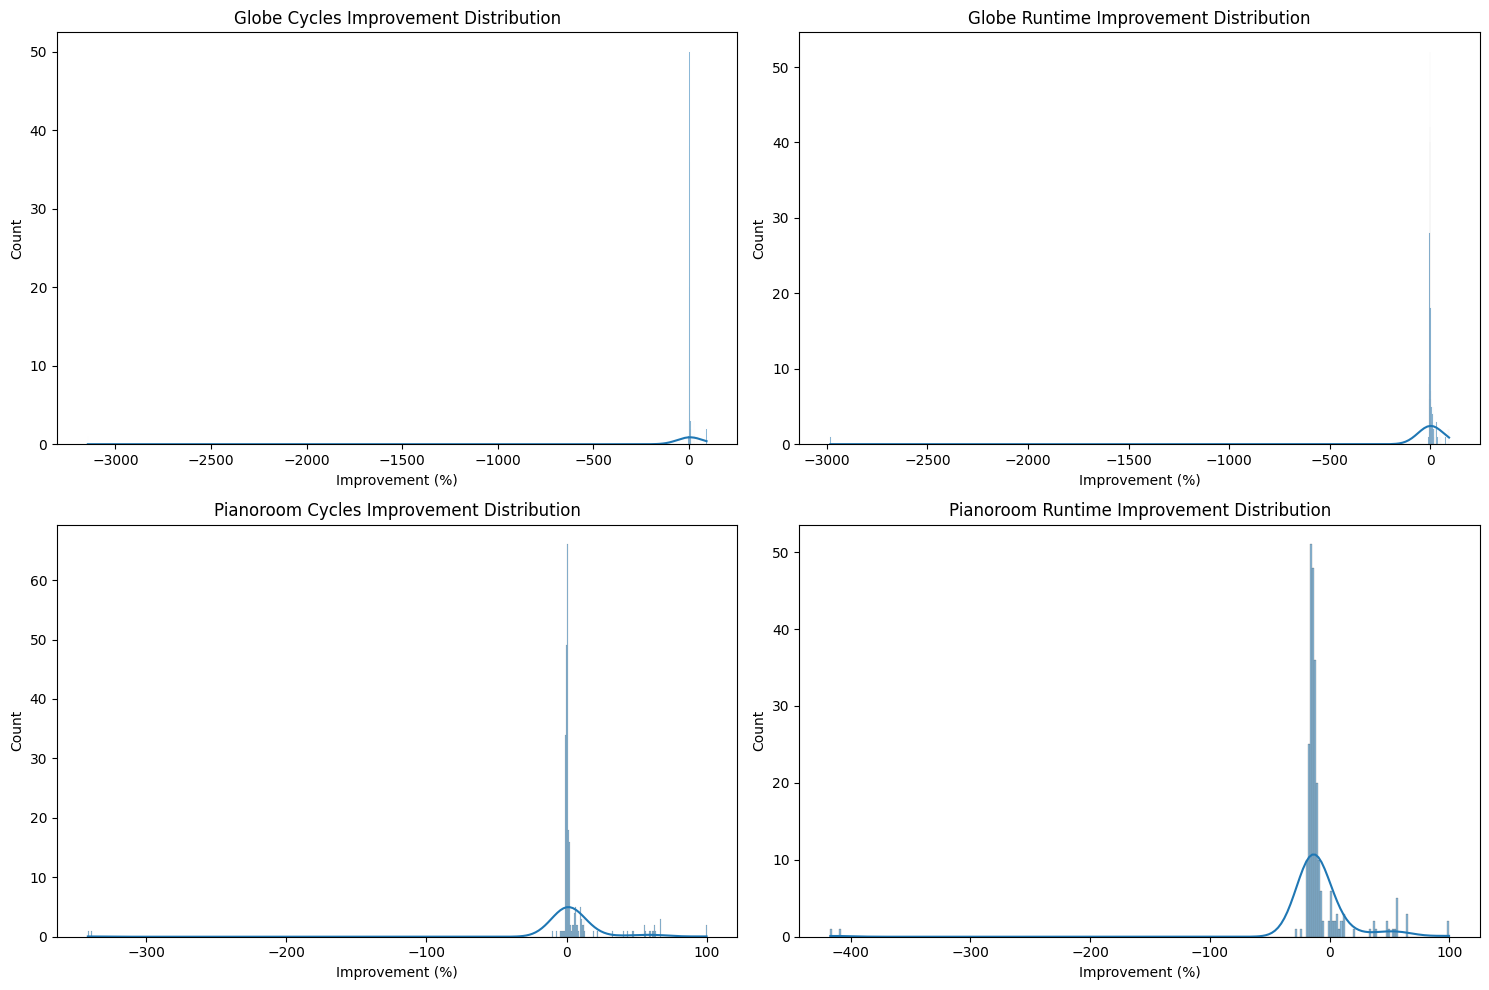

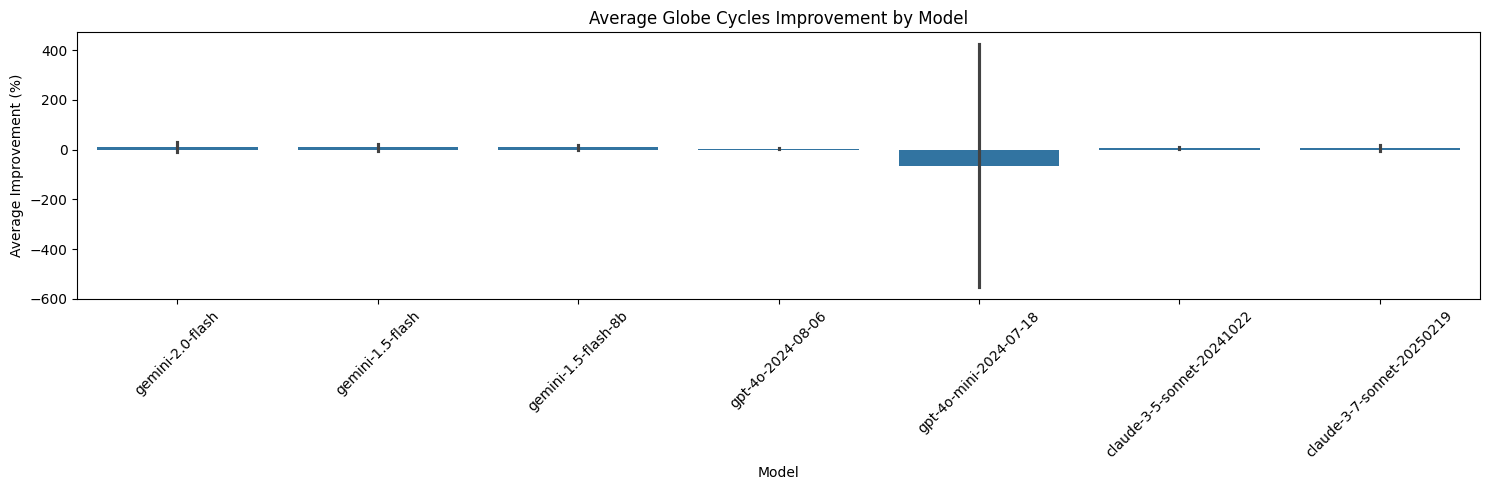

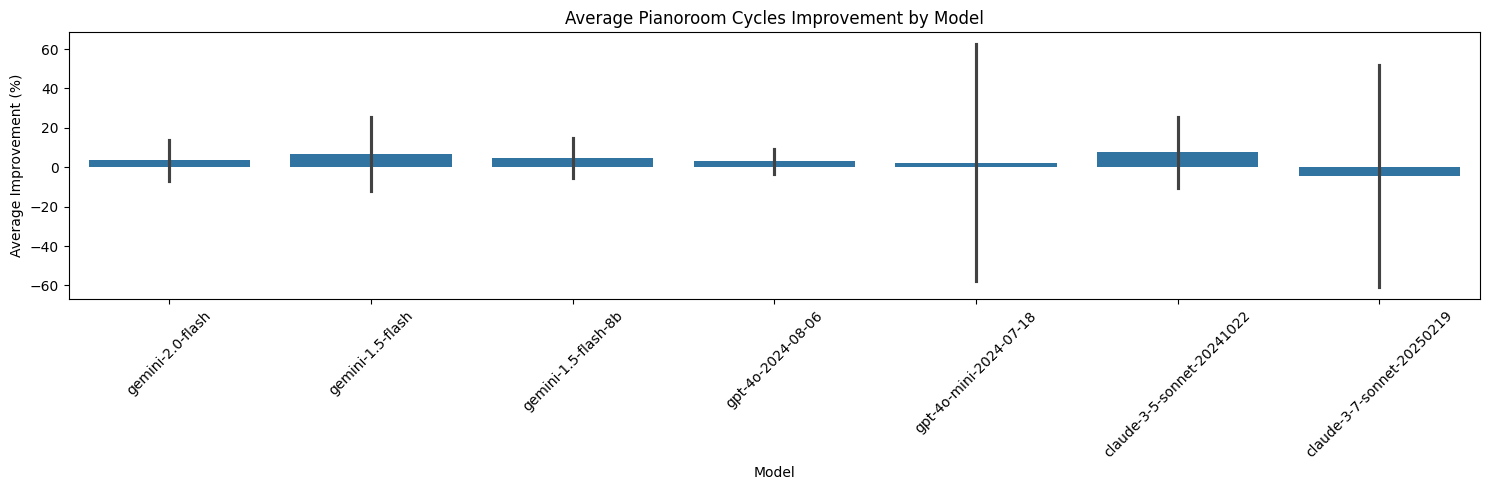

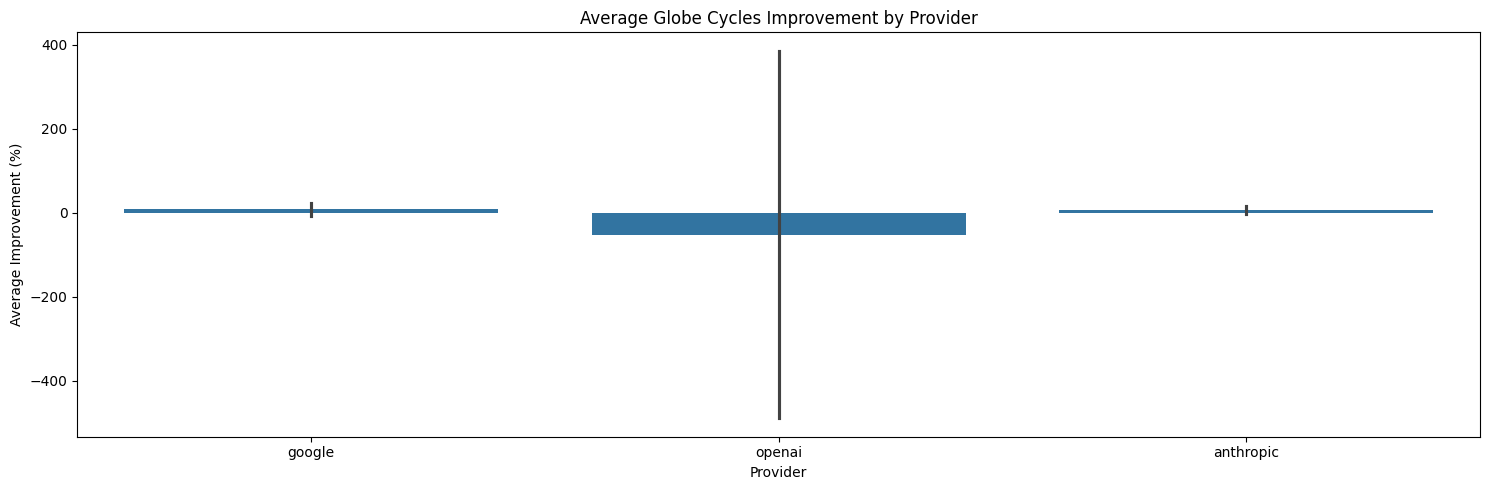

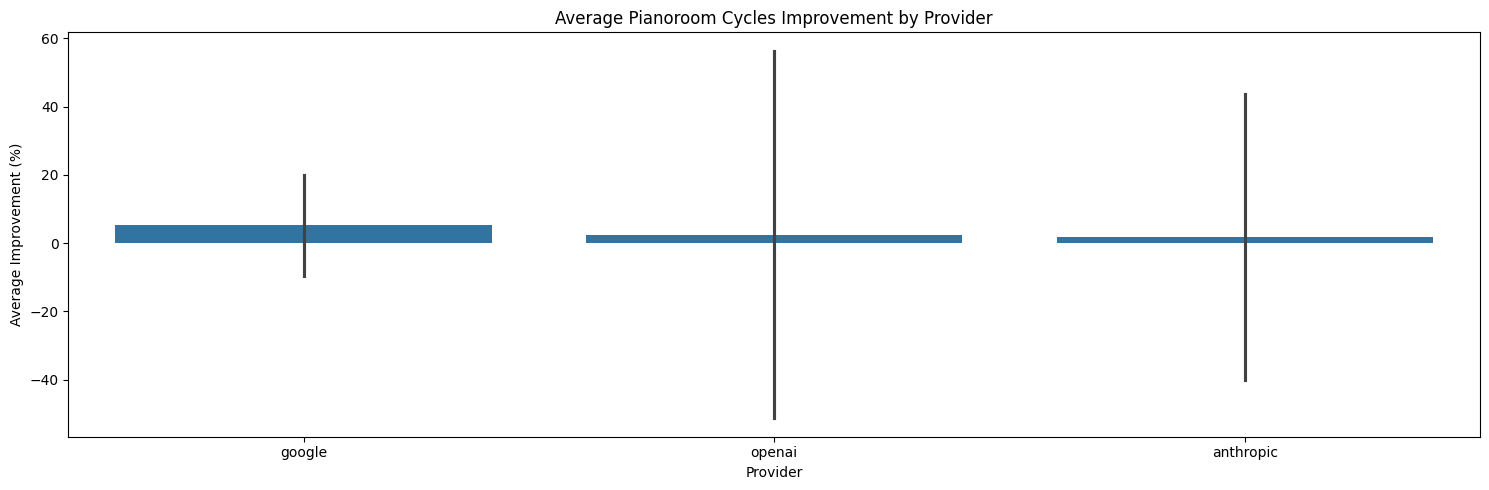

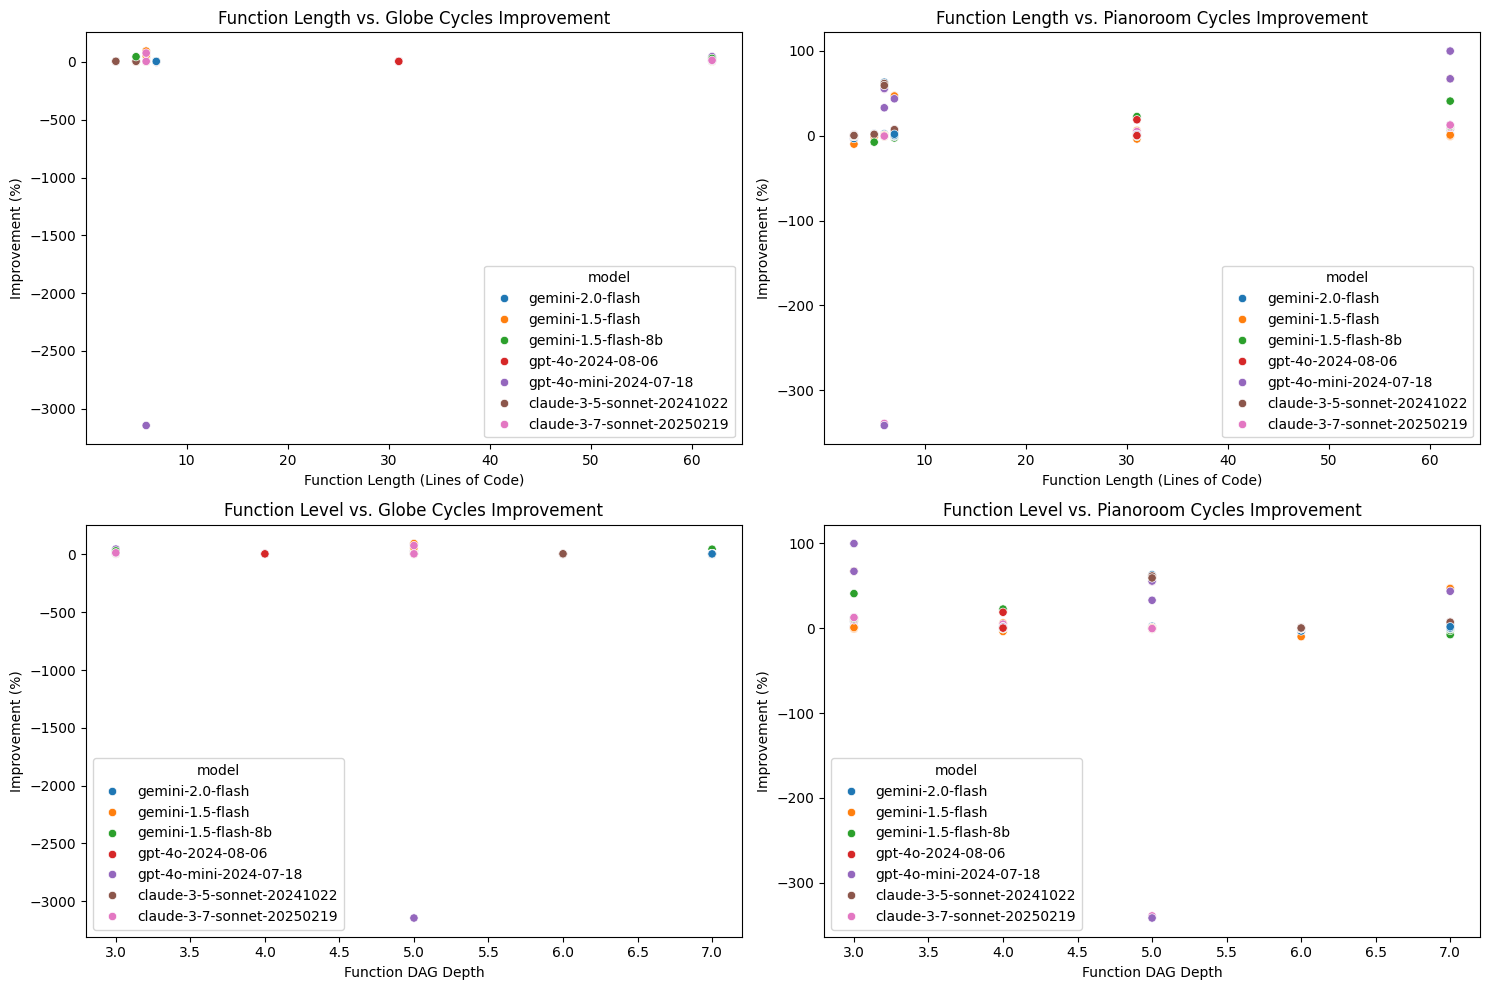

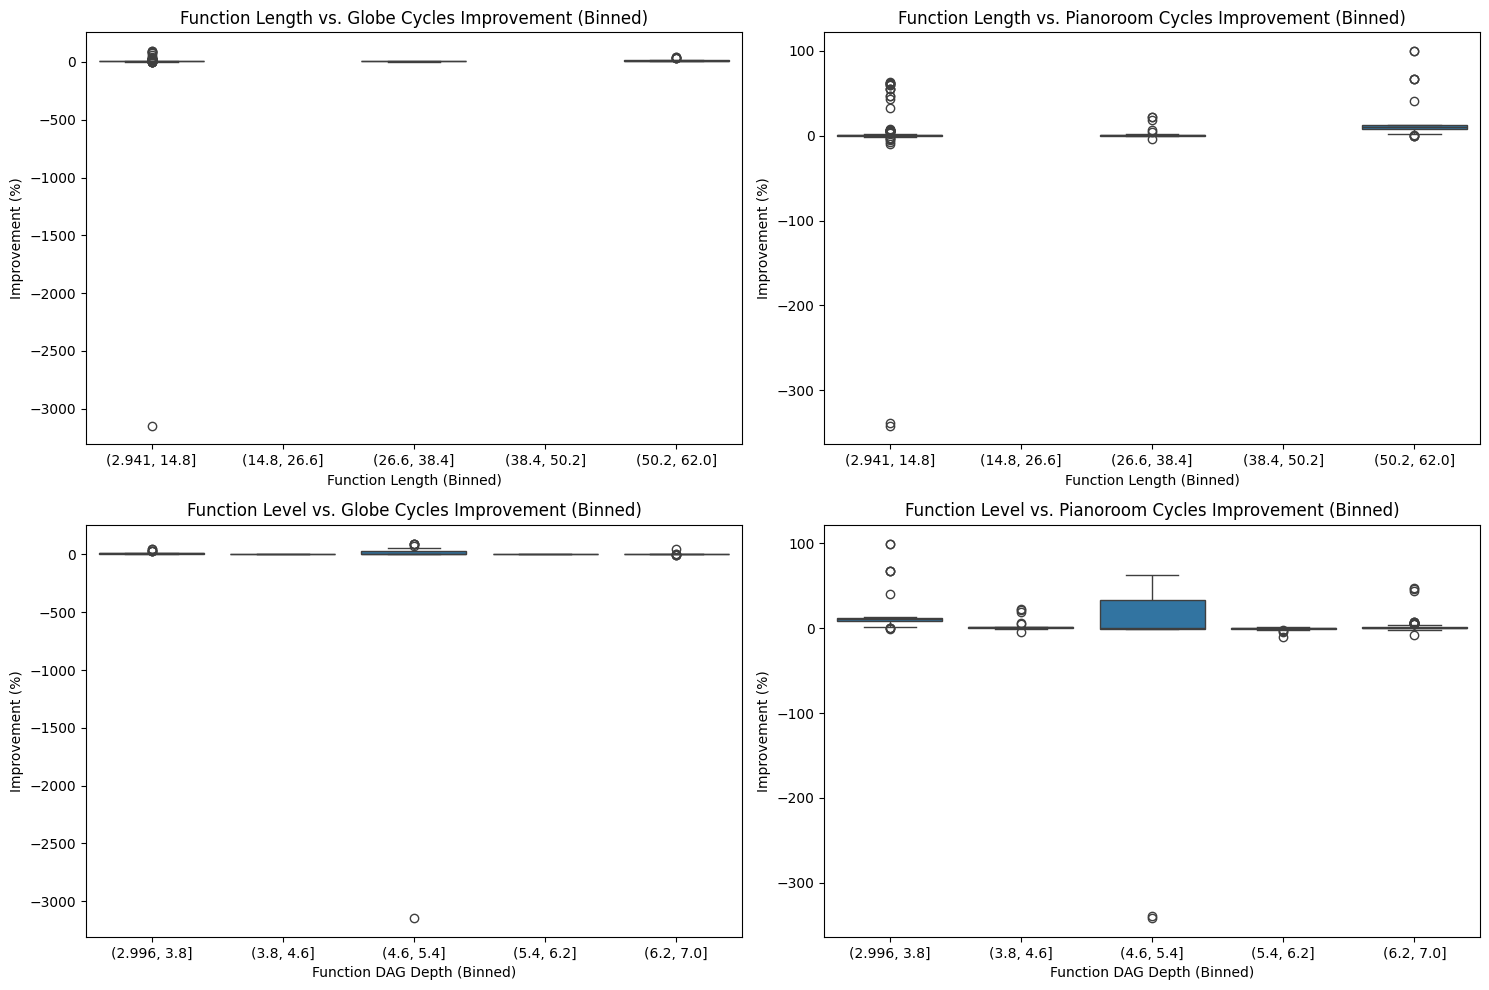

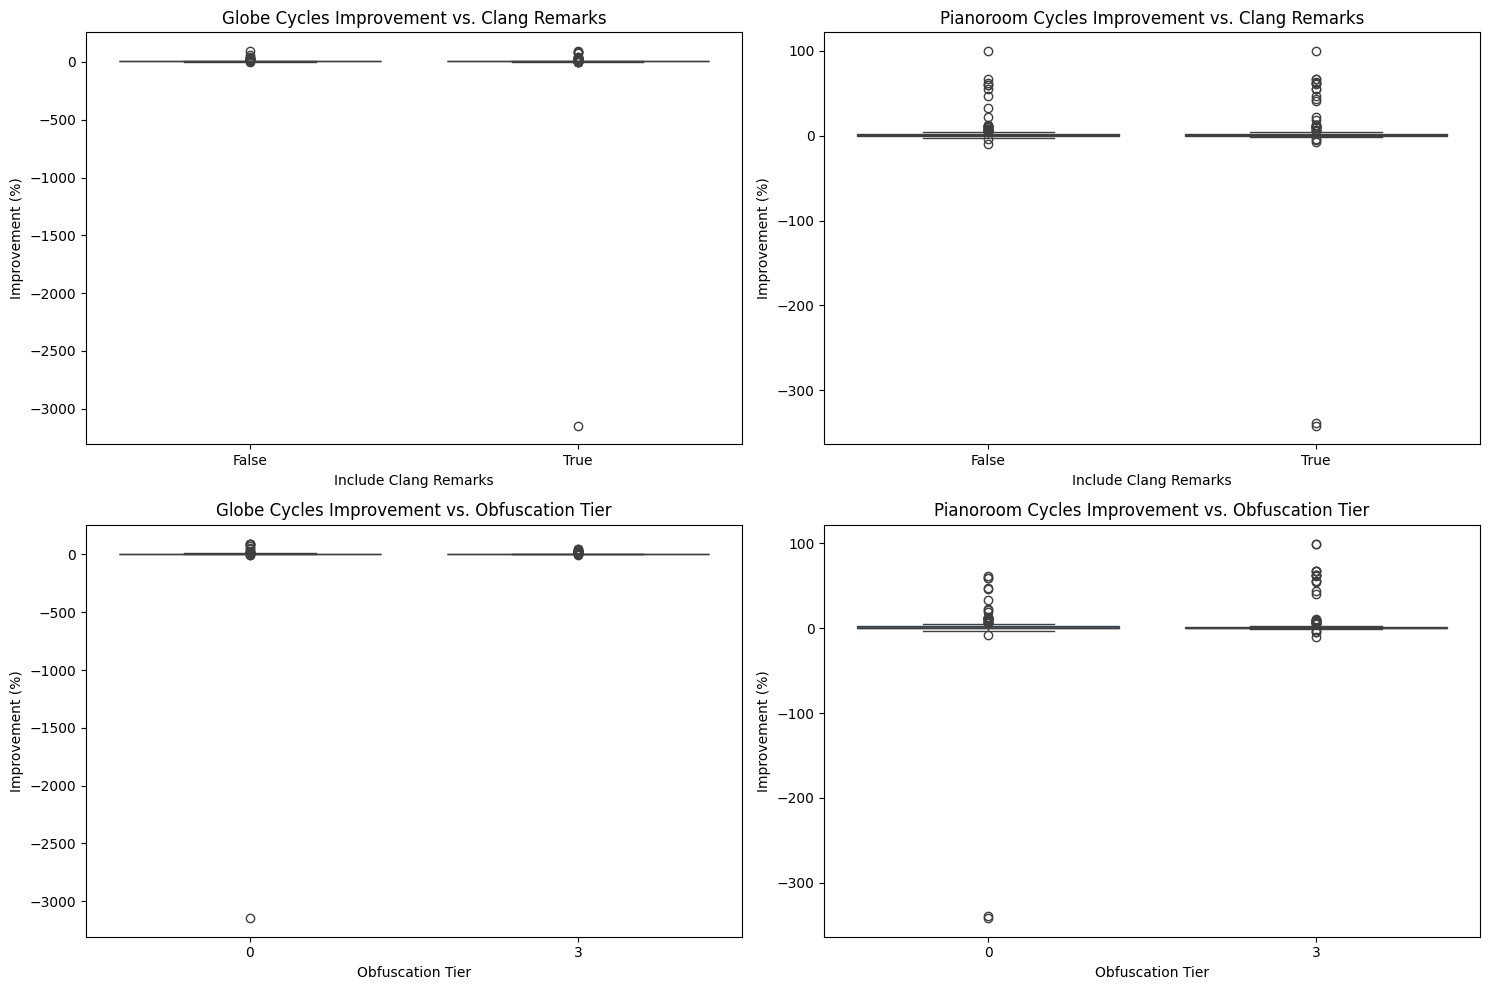

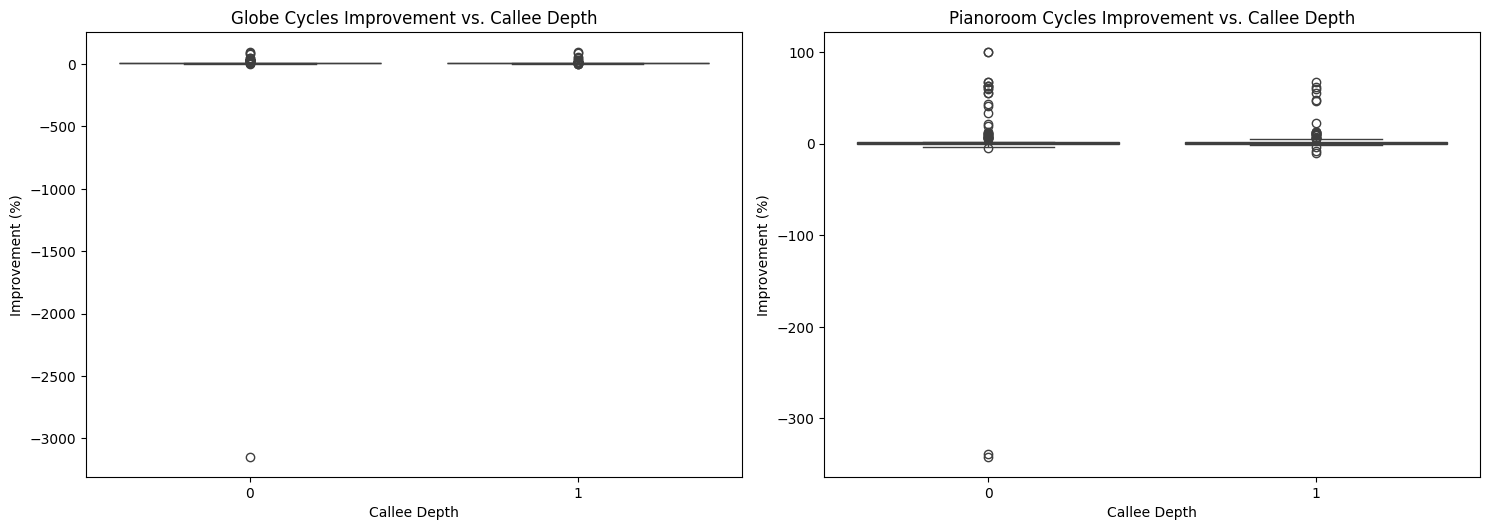

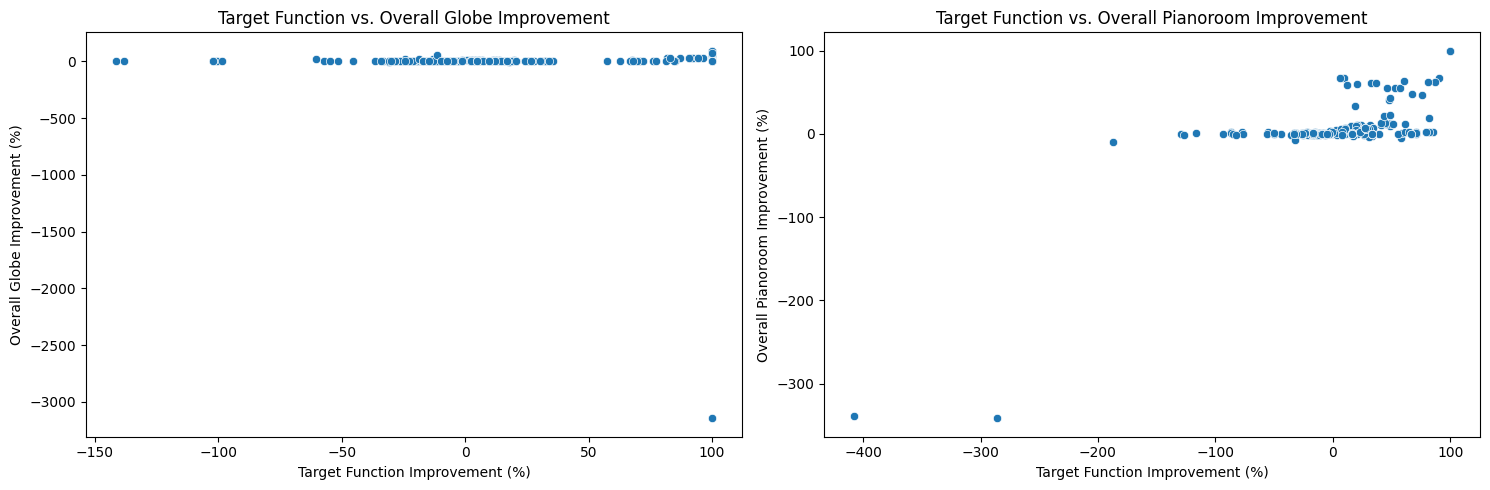

Correlations:
Globe Target vs Overall: -0.100
Pianoroom Target vs Overall: 0.719


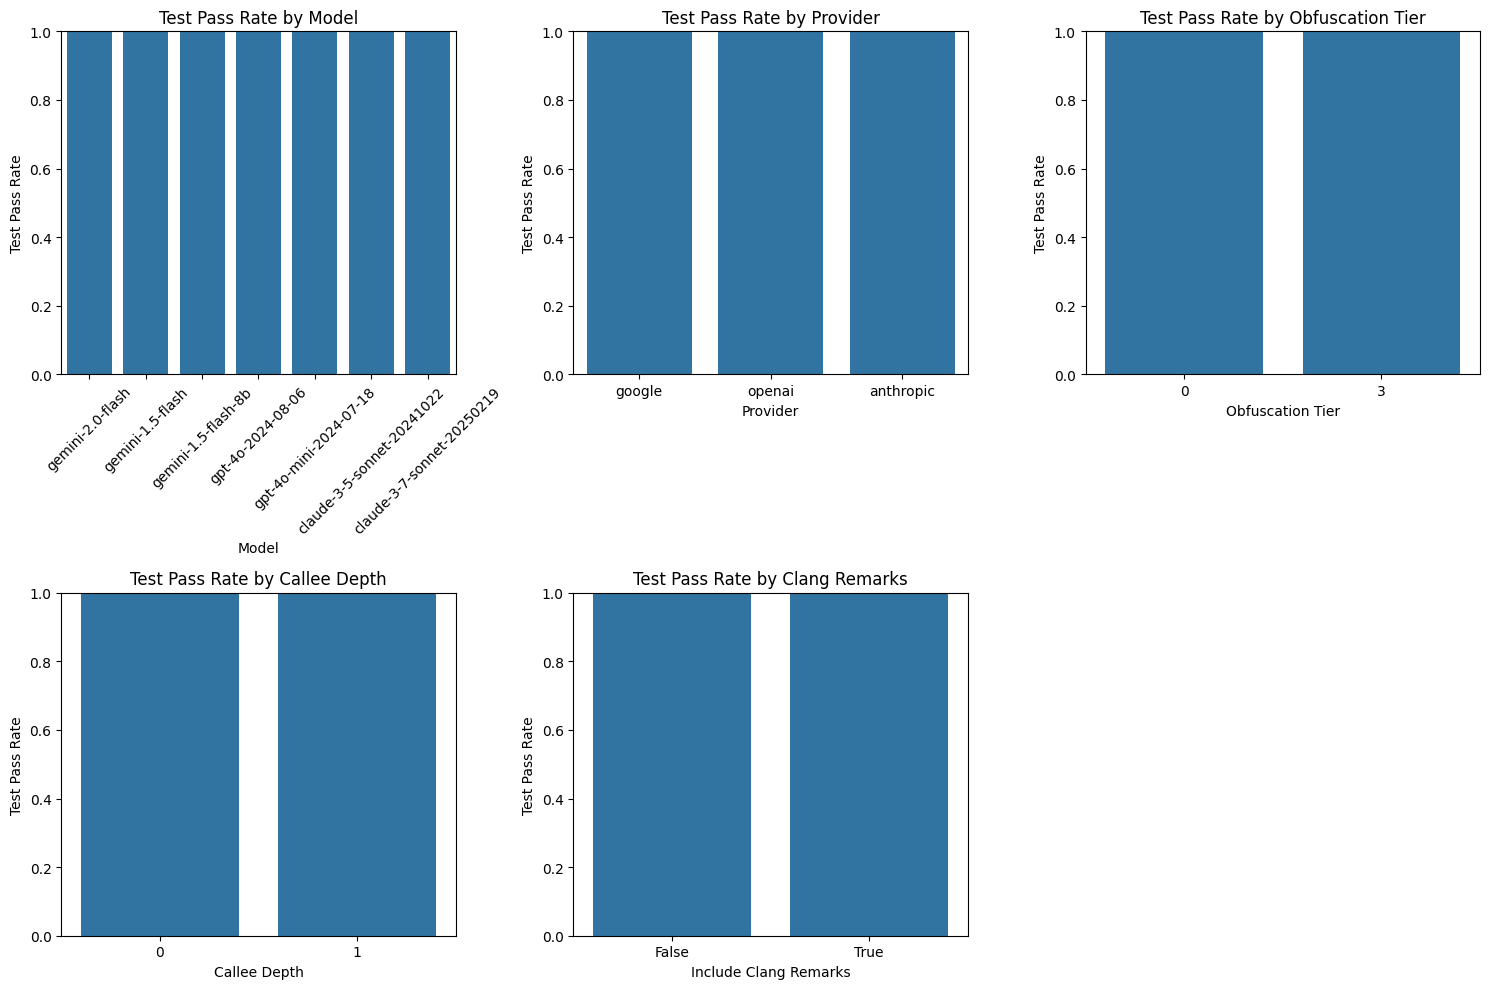

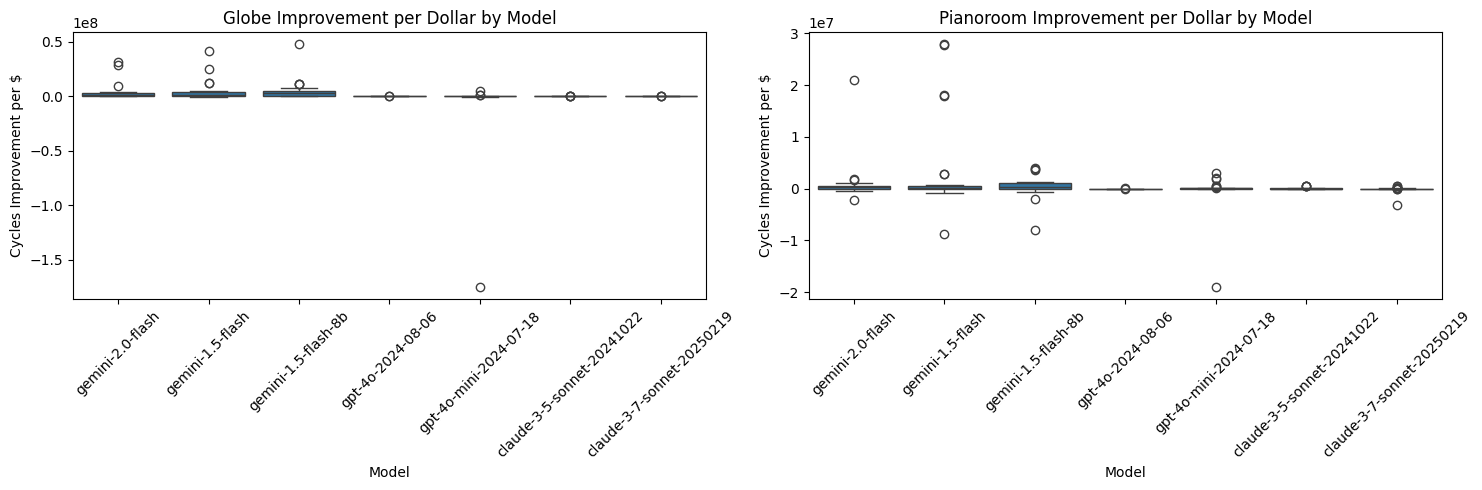

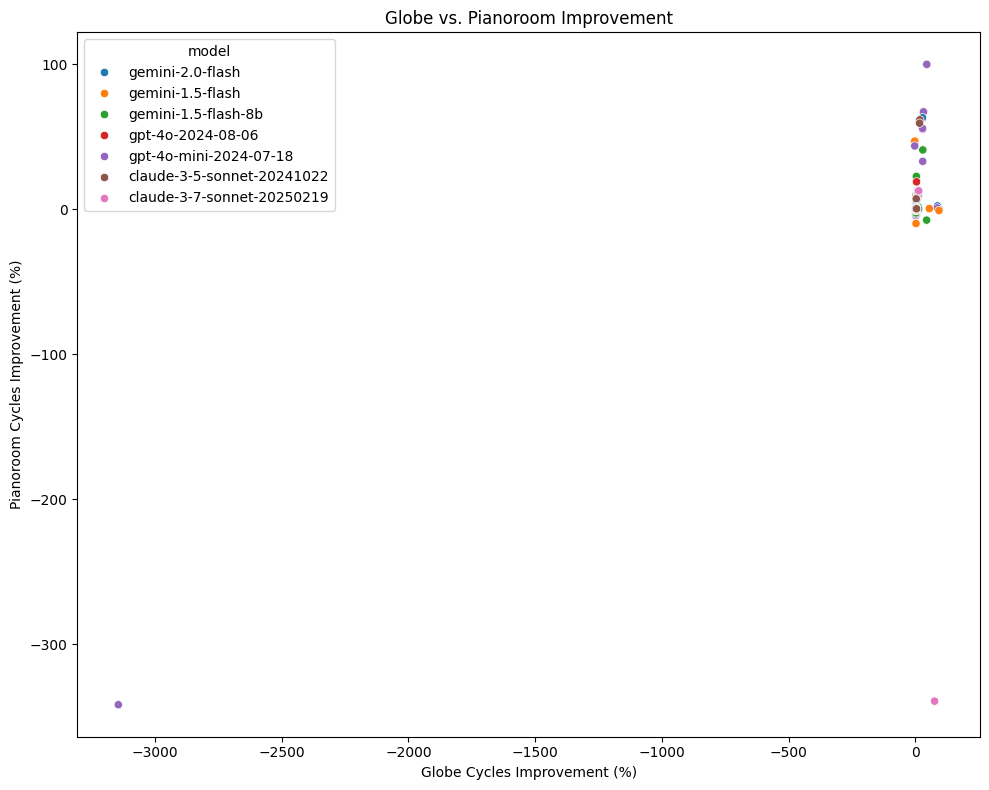

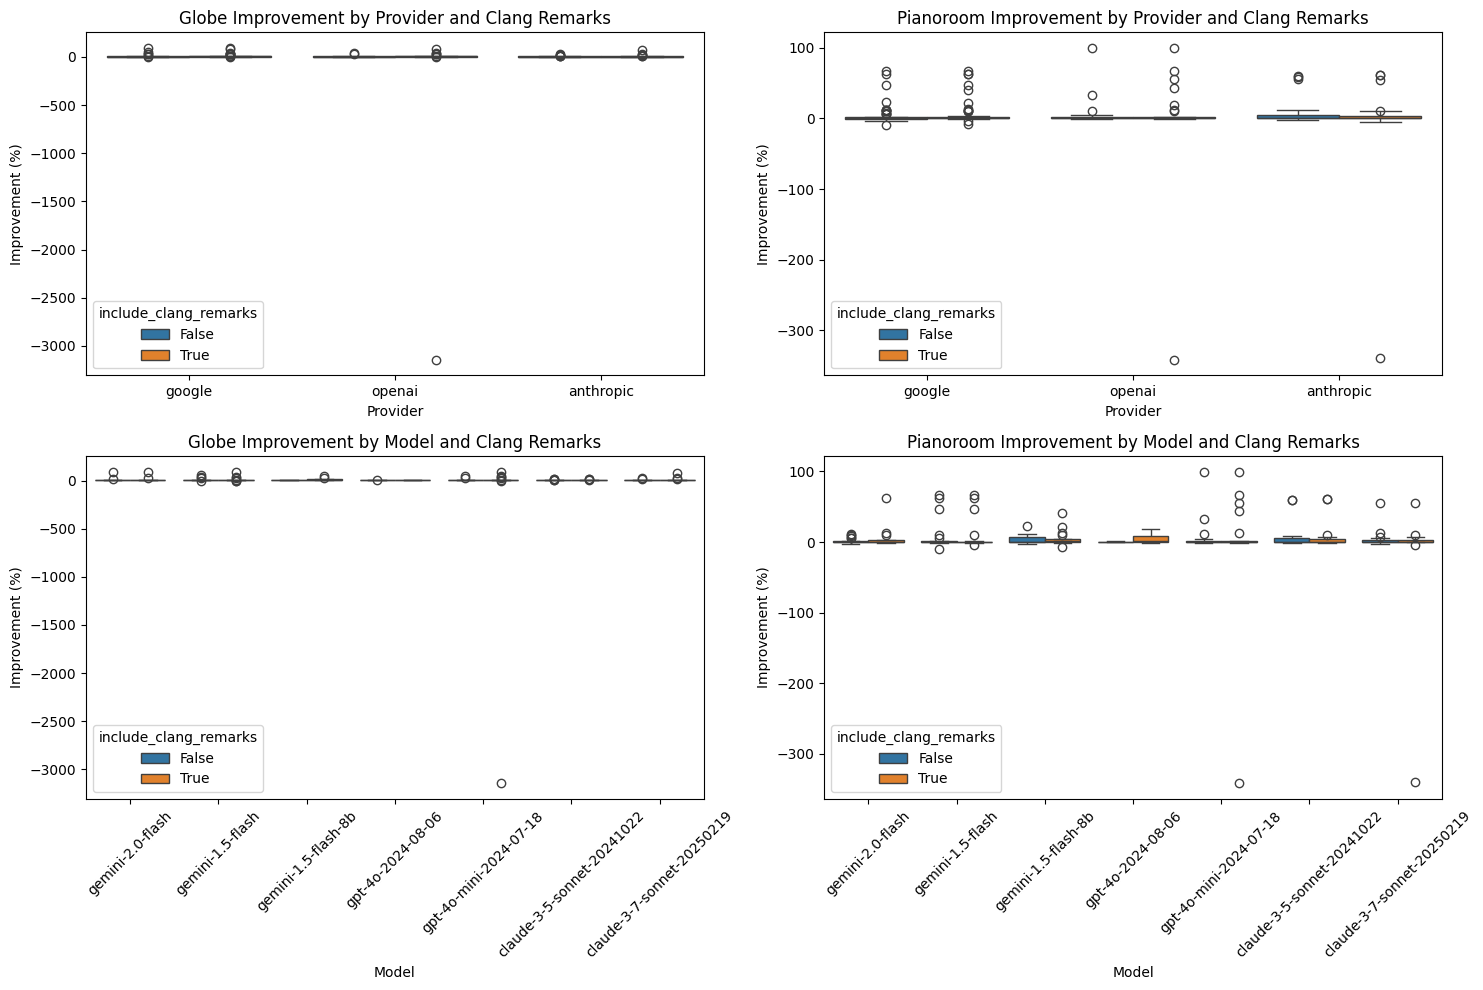

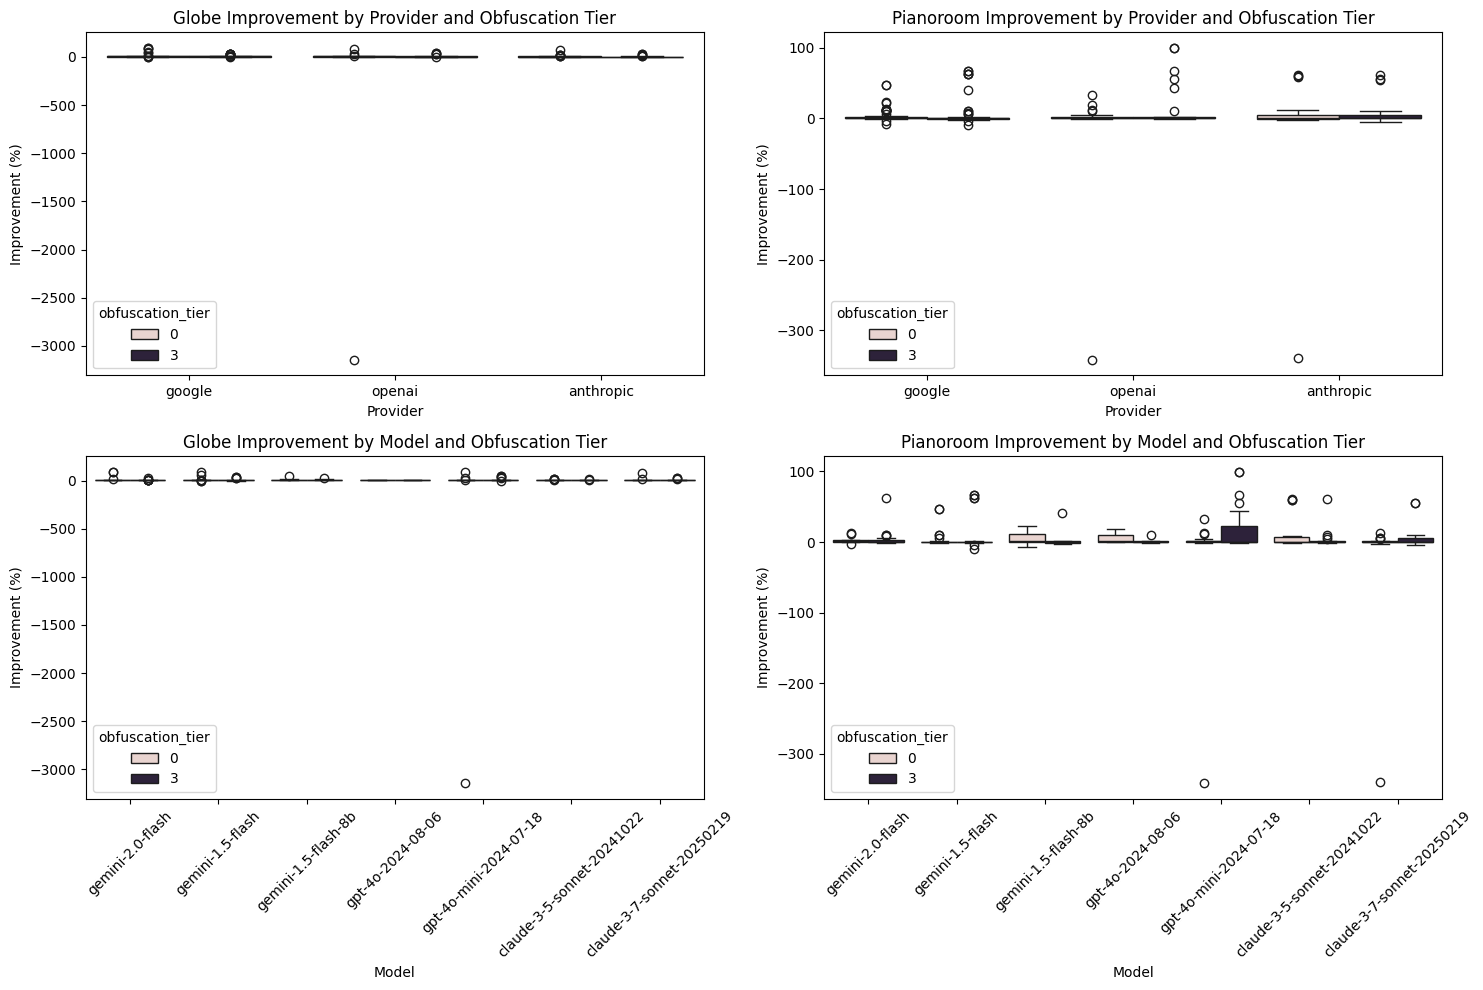

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load Data ---
df = pd.read_csv('optimization_results.csv')

# --- Basic Cleaning ---
for col in [
    'function_relative_level', 'function_length', 'callee_depth',
    'globe_cycles_improvement', 'pianoroom_cycles_improvement',
    'globe_runtime_improvement', 'pianoroom_runtime_improvement',
    'globe_cycles_target_function_improvement', 'pianoroom_cycles_target_function_improvement'
]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Remove invalid improvements (0 or -1 treated as errors)
invalid = lambda x: (x == 0) | (x == -1)
df = df[~invalid(df['globe_cycles_target_function_improvement'])]
df = df[~invalid(df['pianoroom_cycles_target_function_improvement'])]
df = df[~invalid(df['globe_cycles_improvement'])]
df = df[~invalid(df['pianoroom_cycles_improvement'])]
df = df[~invalid(df['globe_runtime_improvement'])]
df = df[~invalid(df['pianoroom_runtime_improvement'])]

# --- Map Model Costs (Assuming this is still relevant) ---
costs = {
    'gpt-4o-mini-2024-07-18': {'input': 0.60, 'output': 2.40},
    'gpt-4o-2024-08-06': {'input': 5.00, 'output': 20.00},
    'claude-3-5-sonnet-20241022': {'input': 3.00, 'output': 15.00},
    'claude-3-7-sonnet-20250219': {'input': 3.00, 'output': 15.00},
    'gemini-1.5-flash': {'input': 0.075, 'output': 0.30},
    'gemini-2.0-flash': {'input': 0.10, 'output': 0.40},
    'gemini-1.5-flash-8b': {'input': 0.0375, 'output': 0.15},
}

# Add cost columns
df['input_cost_per_mil'] = df['model'].map(lambda m: costs.get(m, {}).get('input', np.nan))
df['output_cost_per_mil'] = df['model'].map(lambda m: costs.get(m, {}).get('output', np.nan))



# --- 1. Overall Improvement Distribution ---
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.histplot(df['globe_cycles_improvement'], kde=True)
plt.title('Globe Cycles Improvement Distribution')
plt.xlabel('Improvement (%)')

plt.subplot(2, 2, 2)
sns.histplot(df['globe_runtime_improvement'], kde=True)
plt.title('Globe Runtime Improvement Distribution')
plt.xlabel('Improvement (%)')

plt.subplot(2, 2, 3)
sns.histplot(df['pianoroom_cycles_improvement'], kde=True)
plt.title('Pianoroom Cycles Improvement Distribution')
plt.xlabel('Improvement (%)')

plt.subplot(2, 2, 4)
sns.histplot(df['pianoroom_runtime_improvement'], kde=True)
plt.title('Pianoroom Runtime Improvement Distribution')
plt.xlabel('Improvement (%)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.boxplot(y=df['globe_cycles_improvement'])
plt.title('Globe Cycles Improvement Boxplot')
plt.ylabel('Improvement (%)')

plt.subplot(2, 2, 2)
sns.boxplot(y=df['globe_runtime_improvement'])
plt.title('Globe Runtime Improvement Boxplot')
plt.ylabel('Improvement (%)')

plt.subplot(2, 2, 3)
sns.boxplot(y=df['pianoroom_cycles_improvement'])
plt.title('Pianoroom Cycles Improvement Boxplot')
plt.ylabel('Improvement (%)')

plt.subplot(2, 2, 4)
sns.boxplot(y=df['pianoroom_runtime_improvement'])
plt.title('Pianoroom Runtime Improvement Boxplot')
plt.ylabel('Improvement (%)')
plt.tight_layout()
plt.show()


# --- 2. Improvement by LLM Model ---
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.boxplot(x='model', y='globe_cycles_improvement', data=df)
plt.title('Globe Cycles Improvement by Model')
plt.xlabel('Model')
plt.ylabel('Improvement (%)')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
sns.boxplot(x='model', y='pianoroom_cycles_improvement', data=df)
plt.title('Pianoroom Cycles Improvement by Model')
plt.xlabel('Model')
plt.ylabel('Improvement (%)')
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
sns.violinplot(x='model', y='globe_cycles_improvement', data=df)
plt.title('Globe Cycles Improvement by Model (Violin)')
plt.xlabel('Model')
plt.ylabel('Improvement (%)')
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
sns.violinplot(x='model', y='pianoroom_cycles_improvement', data=df)
plt.title('Pianoroom Cycles Improvement by Model (Violin)')
plt.xlabel('Model')
plt.ylabel('Improvement (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))
sns.barplot(x='model', y='globe_cycles_improvement', data=df, errorbar='sd')  # 'sd' for standard deviation
plt.title('Average Globe Cycles Improvement by Model')
plt.xlabel('Model')
plt.ylabel('Average Improvement (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))
sns.barplot(x='model', y='pianoroom_cycles_improvement', data=df, errorbar='sd')
plt.title('Average Pianoroom Cycles Improvement by Model')
plt.xlabel('Model')
plt.ylabel('Average Improvement (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# --- 3. Improvement by LLM Provider ---
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.boxplot(x='provider', y='globe_cycles_improvement', data=df)
plt.title('Globe Cycles Improvement by Provider')
plt.xlabel('Provider')
plt.ylabel('Improvement (%)')

plt.subplot(2, 2, 2)
sns.boxplot(x='provider', y='pianoroom_cycles_improvement', data=df)
plt.title('Pianoroom Cycles Improvement by Provider')
plt.xlabel('Provider')
plt.ylabel('Improvement (%)')

plt.subplot(2, 2, 3)
sns.violinplot(x='provider', y='globe_cycles_improvement', data=df)
plt.title('Globe Cycles Improvement by Provider (Violin)')
plt.xlabel('Provider')
plt.ylabel('Improvement (%)')

plt.subplot(2, 2, 4)
sns.violinplot(x='provider', y='pianoroom_cycles_improvement', data=df)
plt.title('Pianoroom Cycles Improvement by Provider (Violin)')
plt.xlabel('Provider')
plt.ylabel('Improvement (%)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))
sns.barplot(x='provider', y='globe_cycles_improvement', data=df, errorbar='sd')
plt.title('Average Globe Cycles Improvement by Provider')
plt.xlabel('Provider')
plt.ylabel('Average Improvement (%)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))
sns.barplot(x='provider', y='pianoroom_cycles_improvement', data=df, errorbar='sd')
plt.title('Average Pianoroom Cycles Improvement by Provider')
plt.xlabel('Provider')
plt.ylabel('Average Improvement (%)')
plt.tight_layout()
plt.show()


# --- 4. Impact of Code Characteristics on Improvement ---
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.scatterplot(x='function_length', y='globe_cycles_improvement', hue='model', data=df)
plt.title('Function Length vs. Globe Cycles Improvement')
plt.xlabel('Function Length (Lines of Code)')
plt.ylabel('Improvement (%)')

plt.subplot(2, 2, 2)
sns.scatterplot(x='function_length', y='pianoroom_cycles_improvement', hue='model', data=df)
plt.title('Function Length vs. Pianoroom Cycles Improvement')
plt.xlabel('Function Length (Lines of Code)')
plt.ylabel('Improvement (%)')

plt.subplot(2, 2, 3)
sns.scatterplot(x='function_relative_level', y='globe_cycles_improvement', hue='model', data=df)
plt.title('Function Level vs. Globe Cycles Improvement')
plt.xlabel('Function DAG Depth')
plt.ylabel('Improvement (%)')

plt.subplot(2, 2, 4)
sns.scatterplot(x='function_relative_level', y='pianoroom_cycles_improvement', hue='model', data=df)
plt.title('Function Level vs. Pianoroom Cycles Improvement')
plt.xlabel('Function DAG Depth')
plt.ylabel('Improvement (%)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.boxplot(x=pd.cut(df['function_length'], bins=5), y='globe_cycles_improvement', data=df)
plt.title('Function Length vs. Globe Cycles Improvement (Binned)')
plt.xlabel('Function Length (Binned)')
plt.ylabel('Improvement (%)')

plt.subplot(2, 2, 2)
sns.boxplot(x=pd.cut(df['function_length'], bins=5), y='pianoroom_cycles_improvement', data=df)
plt.title('Function Length vs. Pianoroom Cycles Improvement (Binned)')
plt.xlabel('Function Length (Binned)')
plt.ylabel('Improvement (%)')

plt.subplot(2, 2, 3)
sns.boxplot(x=pd.cut(df['function_relative_level'], bins=5), y='globe_cycles_improvement', data=df)
plt.title('Function Level vs. Globe Cycles Improvement (Binned)')
plt.xlabel('Function DAG Depth (Binned)')
plt.ylabel('Improvement (%)')

plt.subplot(2, 2, 4)
sns.boxplot(x=pd.cut(df['function_relative_level'], bins=5), y='pianoroom_cycles_improvement', data=df)
plt.title('Function Level vs. Pianoroom Cycles Improvement (Binned)')
plt.xlabel('Function DAG Depth (Binned)')
plt.ylabel('Improvement (%)')
plt.tight_layout()
plt.show()


# --- 5. Effect of Optimization Parameters ---
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.boxplot(x='include_clang_remarks', y='globe_cycles_improvement', data=df)
plt.title('Globe Cycles Improvement vs. Clang Remarks')
plt.xlabel('Include Clang Remarks')
plt.ylabel('Improvement (%)')

plt.subplot(2, 2, 2)
sns.boxplot(x='include_clang_remarks', y='pianoroom_cycles_improvement', data=df)
plt.title('Pianoroom Cycles Improvement vs. Clang Remarks')
plt.xlabel('Include Clang Remarks')
plt.ylabel('Improvement (%)')

plt.subplot(2, 2, 3)
sns.boxplot(x='obfuscation_tier', y='globe_cycles_improvement', data=df)
plt.title('Globe Cycles Improvement vs. Obfuscation Tier')
plt.xlabel('Obfuscation Tier')
plt.ylabel('Improvement (%)')

plt.subplot(2, 2, 4)
sns.boxplot(x='obfuscation_tier', y='pianoroom_cycles_improvement', data=df)
plt.title('Pianoroom Cycles Improvement vs. Obfuscation Tier')
plt.xlabel('Obfuscation Tier')
plt.ylabel('Improvement (%)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.boxplot(x='callee_depth', y='globe_cycles_improvement', data=df)
plt.title('Globe Cycles Improvement vs. Callee Depth')
plt.xlabel('Callee Depth')
plt.ylabel('Improvement (%)')

plt.subplot(2, 2, 2)
sns.boxplot(x='callee_depth', y='pianoroom_cycles_improvement', data=df)
plt.title('Pianoroom Cycles Improvement vs. Callee Depth')
plt.xlabel('Callee Depth')
plt.ylabel('Improvement (%)')
plt.tight_layout()
plt.show()



# --- 6. Relationship Between Target Function Improvement and Overall Improvement ---
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='globe_cycles_target_function_improvement', y='globe_cycles_improvement', data=df)
plt.title('Target Function vs. Overall Globe Improvement')
plt.xlabel('Target Function Improvement (%)')
plt.ylabel('Overall Globe Improvement (%)')

plt.subplot(1, 2, 2)
sns.scatterplot(x='pianoroom_cycles_target_function_improvement', y='pianoroom_cycles_improvement', data=df)
plt.title('Target Function vs. Overall Pianoroom Improvement')
plt.xlabel('Target Function Improvement (%)')
plt.ylabel('Overall Pianoroom Improvement (%)')
plt.tight_layout()
plt.show()

print("Correlations:")
print(f"Globe Target vs Overall: {df['globe_cycles_target_function_improvement'].corr(df['globe_cycles_improvement']):.3f}")
print(f"Pianoroom Target vs Overall: {df['pianoroom_cycles_target_function_improvement'].corr(df['pianoroom_cycles_improvement']):.3f}")


# --- 7. Test Pass Rate Analysis ---
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
sns.barplot(x='model', y='tests_passed', data=df)
plt.title('Test Pass Rate by Model')
plt.xlabel('Model')
plt.ylabel('Test Pass Rate')
plt.xticks(rotation=45)
plt.ylim(0, 1)

plt.subplot(2, 3, 2)
sns.barplot(x='provider', y='tests_passed', data=df)
plt.title('Test Pass Rate by Provider')
plt.xlabel('Provider')
plt.ylabel('Test Pass Rate')
plt.ylim(0, 1)

plt.subplot(2, 3, 3)
sns.barplot(x='obfuscation_tier', y='tests_passed', data=df)
plt.title('Test Pass Rate by Obfuscation Tier')
plt.xlabel('Obfuscation Tier')
plt.ylabel('Test Pass Rate')
plt.ylim(0, 1)

plt.subplot(2, 3, 4)
sns.barplot(x='callee_depth', y='tests_passed', data=df)
plt.title('Test Pass Rate by Callee Depth')
plt.xlabel('Callee Depth')
plt.ylabel('Test Pass Rate')
plt.ylim(0, 1)

plt.subplot(2, 3, 5)
sns.barplot(x='include_clang_remarks', y='tests_passed', data=df)
plt.title('Test Pass Rate by Clang Remarks')
plt.xlabel('Include Clang Remarks')
plt.ylabel('Test Pass Rate')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# --- 8. Cost-Benefit Analysis ---
if 'input_cost_per_mil' in df.columns and 'output_cost_per_mil' in df.columns:
    df['cost'] = (df['input_cost_per_mil'] * (df['function_length'] / 1000000)) + \
                   (df['output_cost_per_mil'] * (df['function_length'] / 1000000))  # Simplified cost - assumes cost is proportional to function length.
    df['globe_improvement_per_dollar'] = df['globe_cycles_improvement'] / df['cost']
    df['pianoroom_improvement_per_dollar'] = df['pianoroom_cycles_improvement'] / df['cost']
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    sns.boxplot(x='model', y='globe_improvement_per_dollar', data=df)
    plt.title('Globe Improvement per Dollar by Model')
    plt.xlabel('Model')
    plt.ylabel('Cycles Improvement per $')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x='model', y='pianoroom_improvement_per_dollar', data=df)
    plt.title('Pianoroom Improvement per Dollar by Model')
    plt.xlabel('Model')
    plt.ylabel('Cycles Improvement per $')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    sns.boxplot(x='provider', y='globe_improvement_per_dollar', data=df)
    plt.title('Globe Improvement per Dollar by Provider')
    plt.xlabel('Provider')
    plt.ylabel('Cycles Improvement per $')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x='provider', y='pianoroom_improvement_per_dollar', data=df)
    plt.title('Pianoroom Improvement per Dollar by Provider')
    plt.xlabel('Provider')
    plt.ylabel('Cycles Improvement per $')
    plt.tight_layout()
    plt.show()
else:
    print("Skipping cost-benefit analysis: 'input_cost_per_mil' or 'output_cost_per_mil' columns not found.")



# --- 10. Comparing Globe and Pianoroom Benchmarks ---
plt.figure(figsize=(10, 8))
sns.scatterplot(x='globe_cycles_improvement', y='pianoroom_cycles_improvement', hue='model', data=df)
plt.title('Globe vs. Pianoroom Improvement')
plt.xlabel('Globe Cycles Improvement (%)')
plt.ylabel('Pianoroom Cycles Improvement (%)')
plt.tight_layout()
plt.show()

# --- 11. Clang Remarks and Obfuscation vs. Improvement by Provider and Model ---

# Clang Remarks
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.boxplot(x='provider', y='globe_cycles_improvement', hue='include_clang_remarks', data=df)
plt.title('Globe Improvement by Provider and Clang Remarks')
plt.xlabel('Provider')
plt.ylabel('Improvement (%)')

plt.subplot(2, 2, 2)
sns.boxplot(x='provider', y='pianoroom_cycles_improvement', hue='include_clang_remarks', data=df)
plt.title('Pianoroom Improvement by Provider and Clang Remarks')
plt.xlabel('Provider')
plt.ylabel('Improvement (%)')

plt.subplot(2, 2, 3)
sns.boxplot(x='model', y='globe_cycles_improvement', hue='include_clang_remarks', data=df)
plt.title('Globe Improvement by Model and Clang Remarks')
plt.xlabel('Model')
plt.ylabel('Improvement (%)')
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
sns.boxplot(x='model', y='pianoroom_cycles_improvement', hue='include_clang_remarks', data=df)
plt.title('Pianoroom Improvement by Model and Clang Remarks')
plt.xlabel('Model')
plt.ylabel('Improvement (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Obfuscation Tier
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.boxplot(x='provider', y='globe_cycles_improvement', hue='obfuscation_tier', data=df)
plt.title('Globe Improvement by Provider and Obfuscation Tier')
plt.xlabel('Provider')
plt.ylabel('Improvement (%)')

plt.subplot(2, 2, 2)
sns.boxplot(x='provider', y='pianoroom_cycles_improvement', hue='obfuscation_tier', data=df)
plt.title('Pianoroom Improvement by Provider and Obfuscation Tier')
plt.xlabel('Provider')
plt.ylabel('Improvement (%)')

plt.subplot(2, 2, 3)
sns.boxplot(x='model', y='globe_cycles_improvement', hue='obfuscation_tier', data=df)
plt.title('Globe Improvement by Model and Obfuscation Tier')
plt.xlabel('Model')
plt.ylabel('Improvement (%)')
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
sns.boxplot(x='model', y='pianoroom_cycles_improvement', hue='obfuscation_tier', data=df)
plt.title('Pianoroom Improvement by Model and Obfuscation Tier')
plt.xlabel('Model')
plt.ylabel('Improvement (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


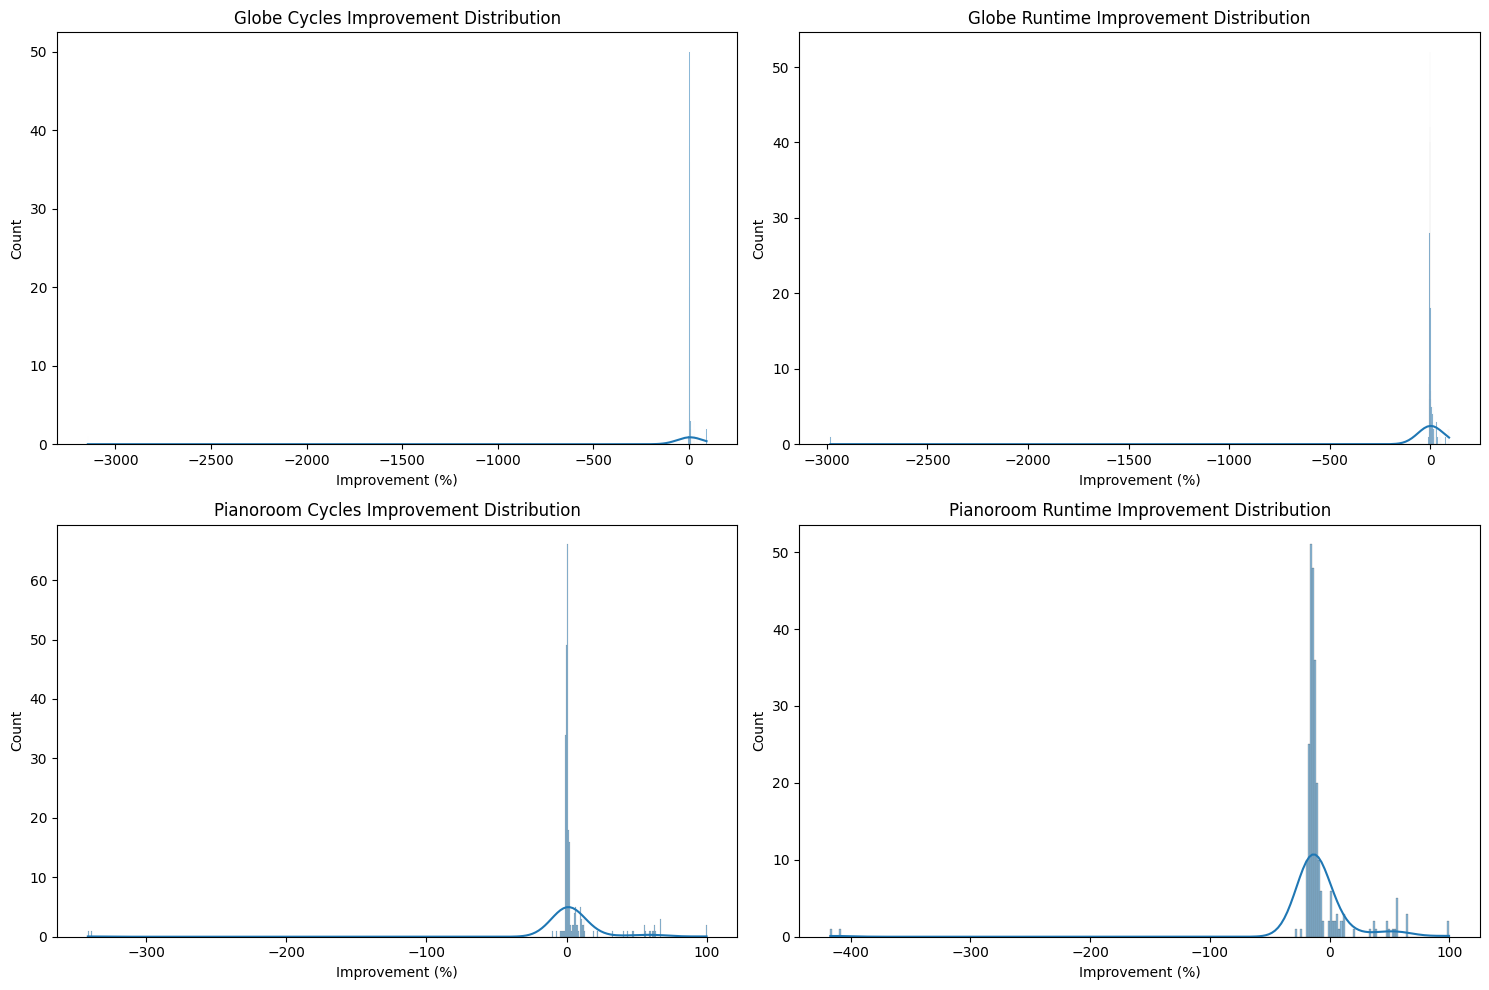

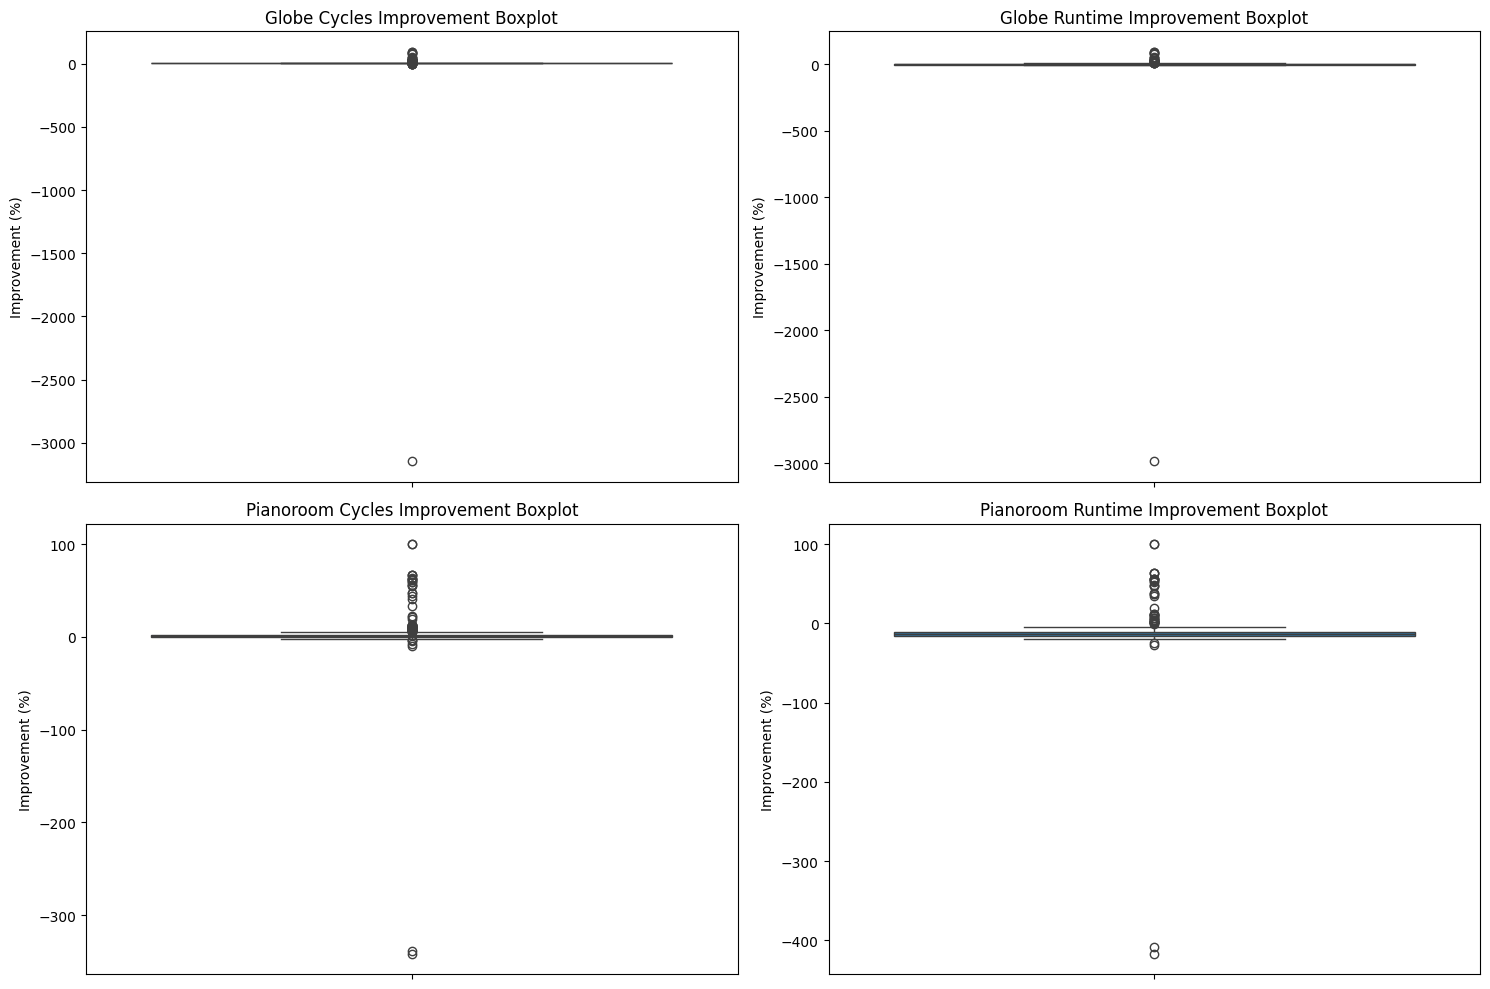

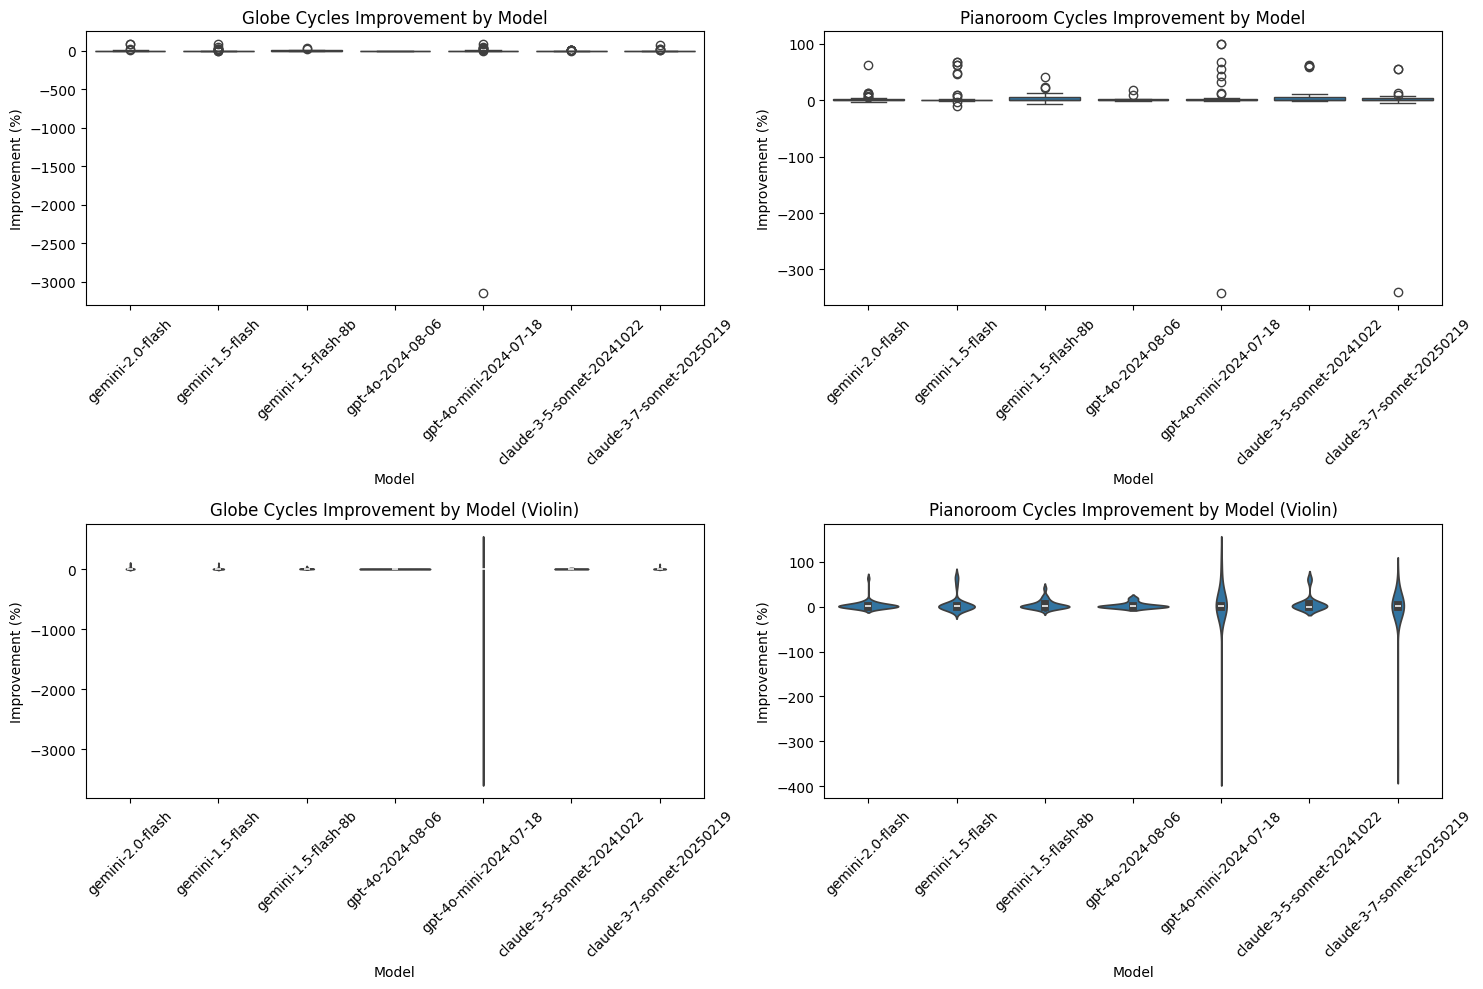

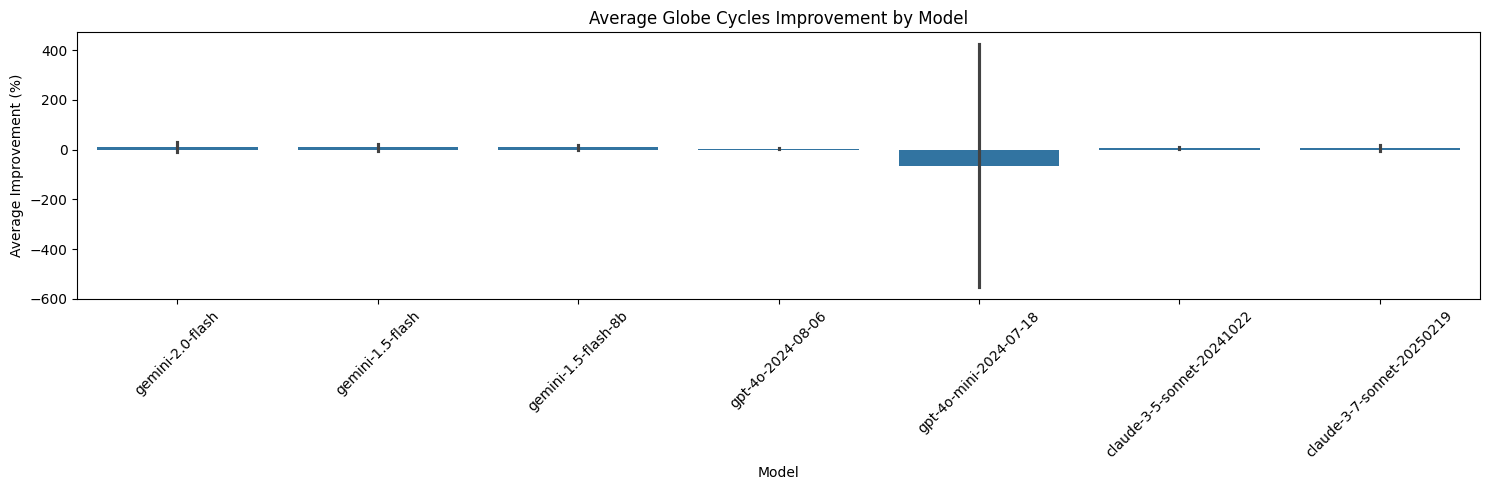

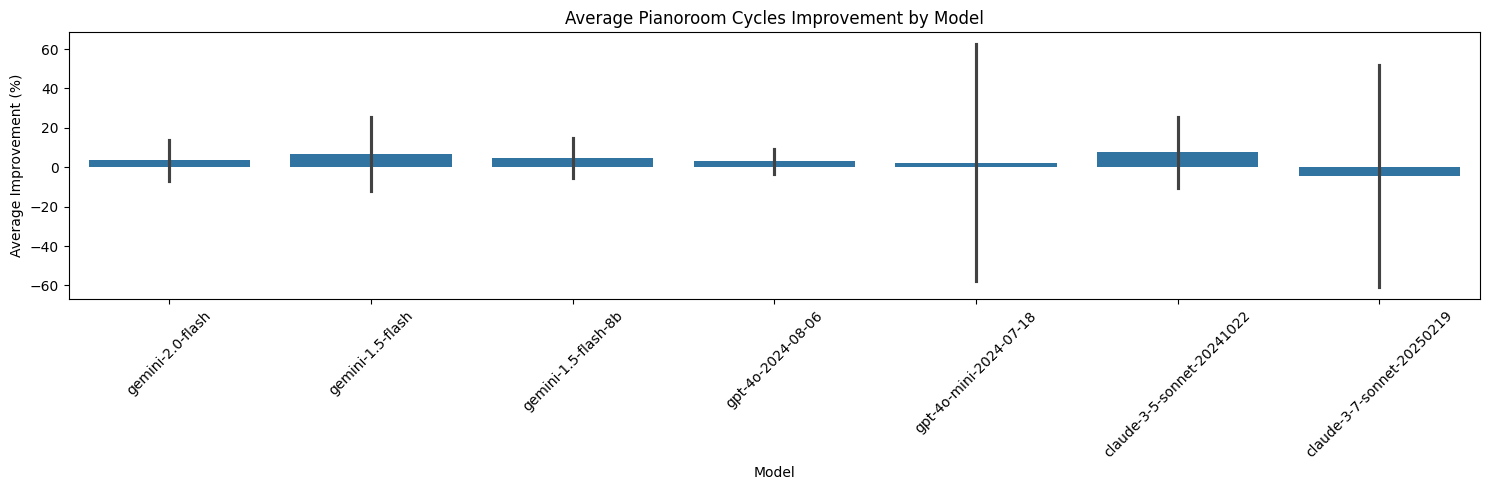

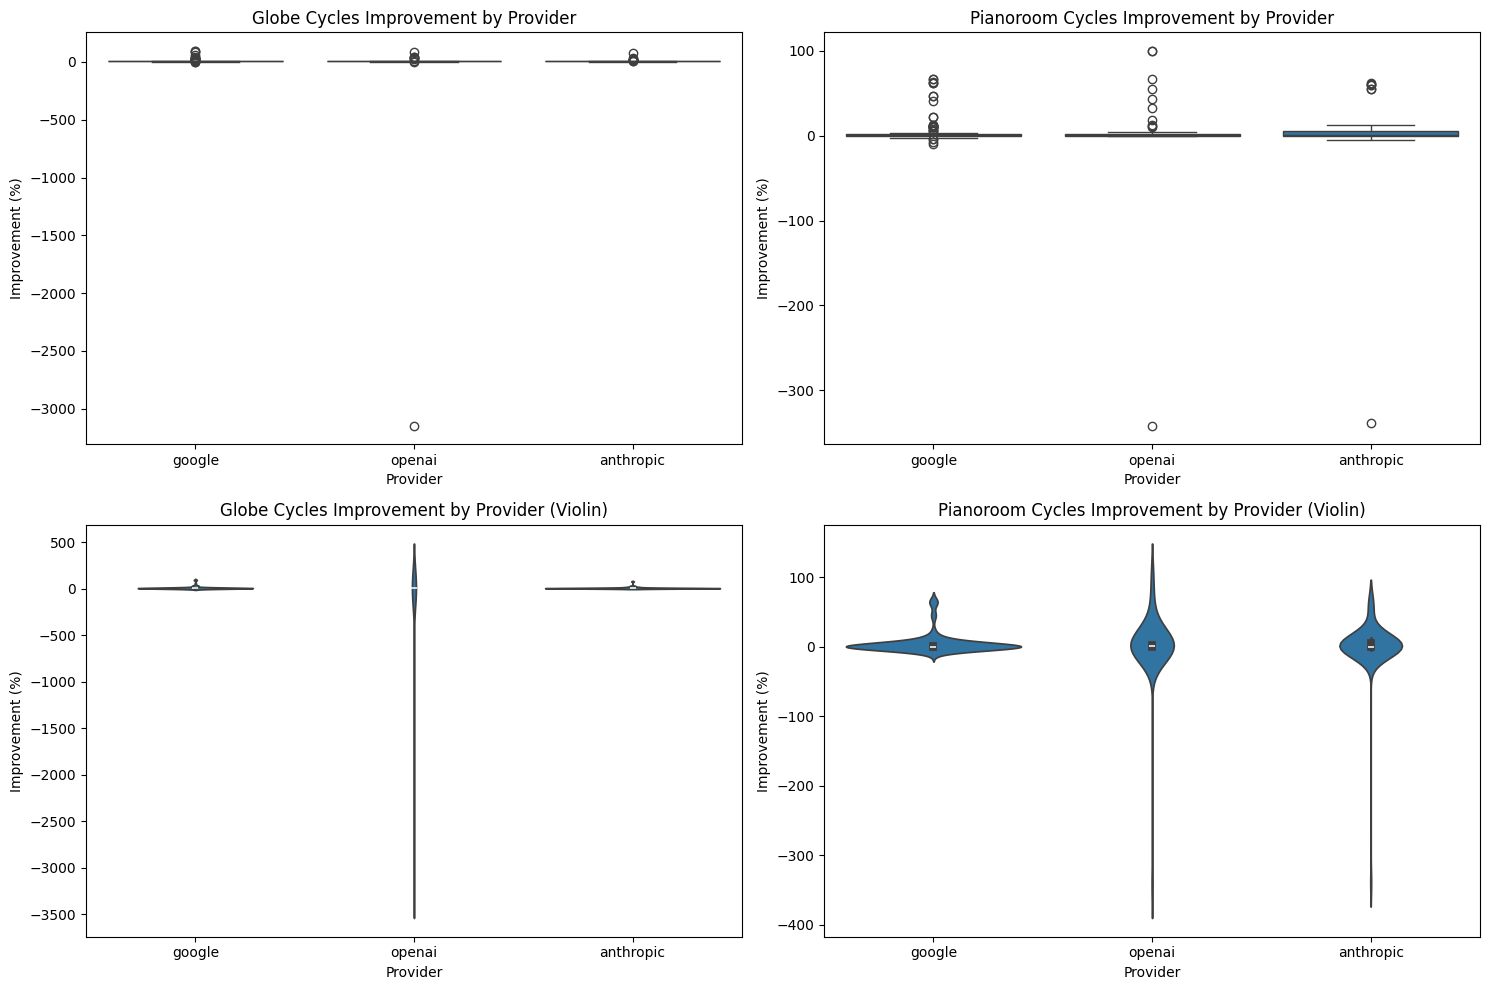

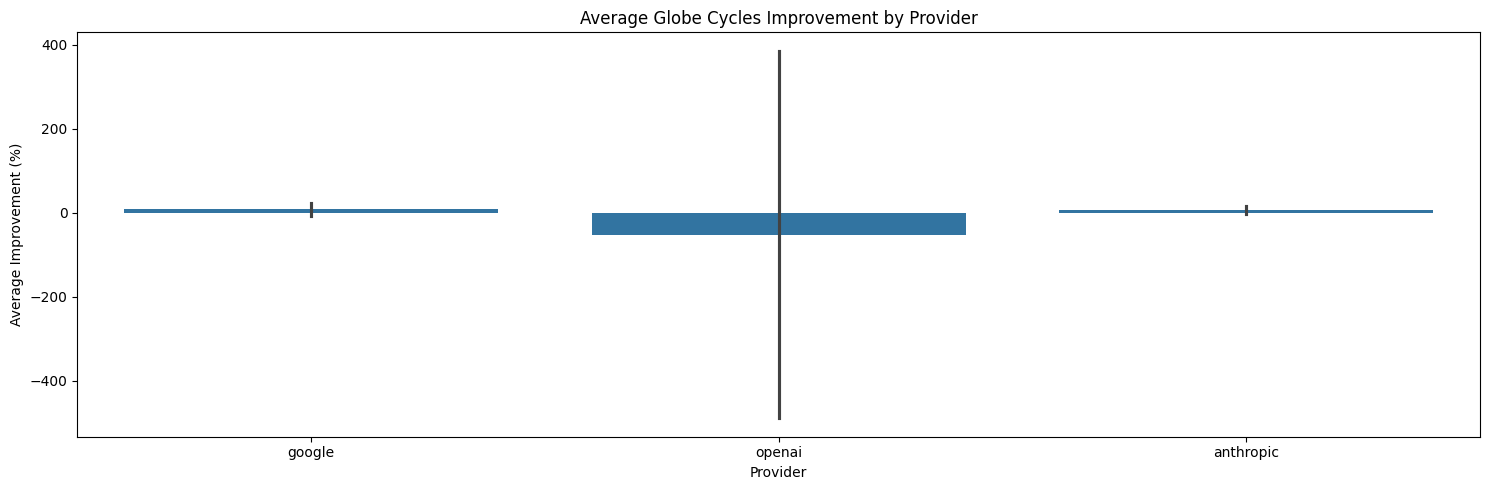

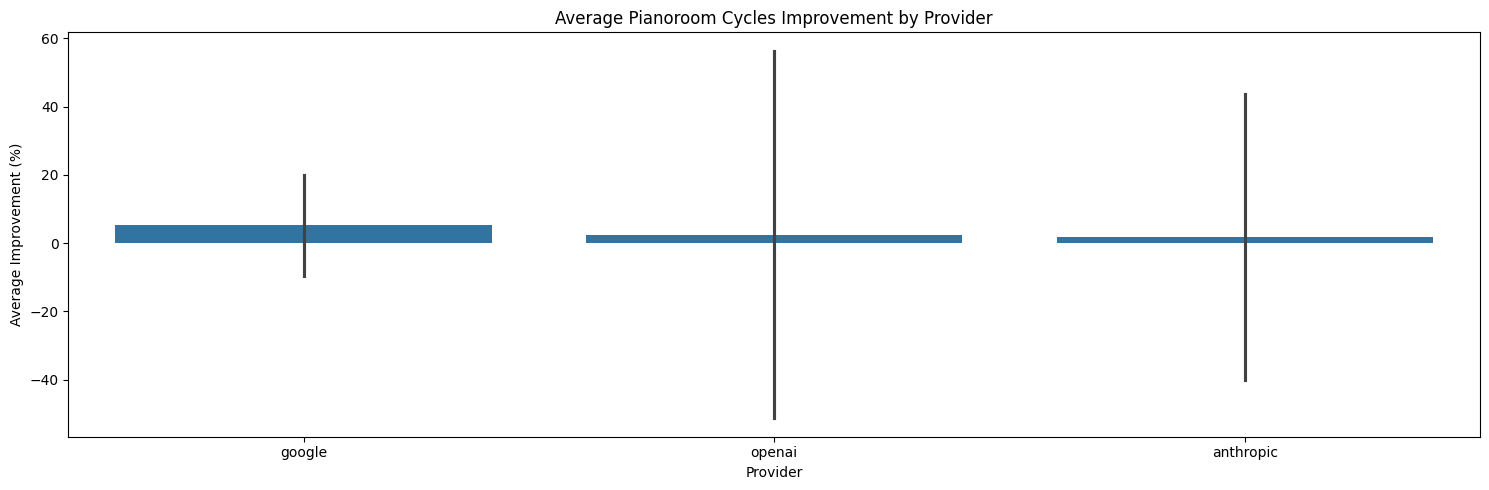

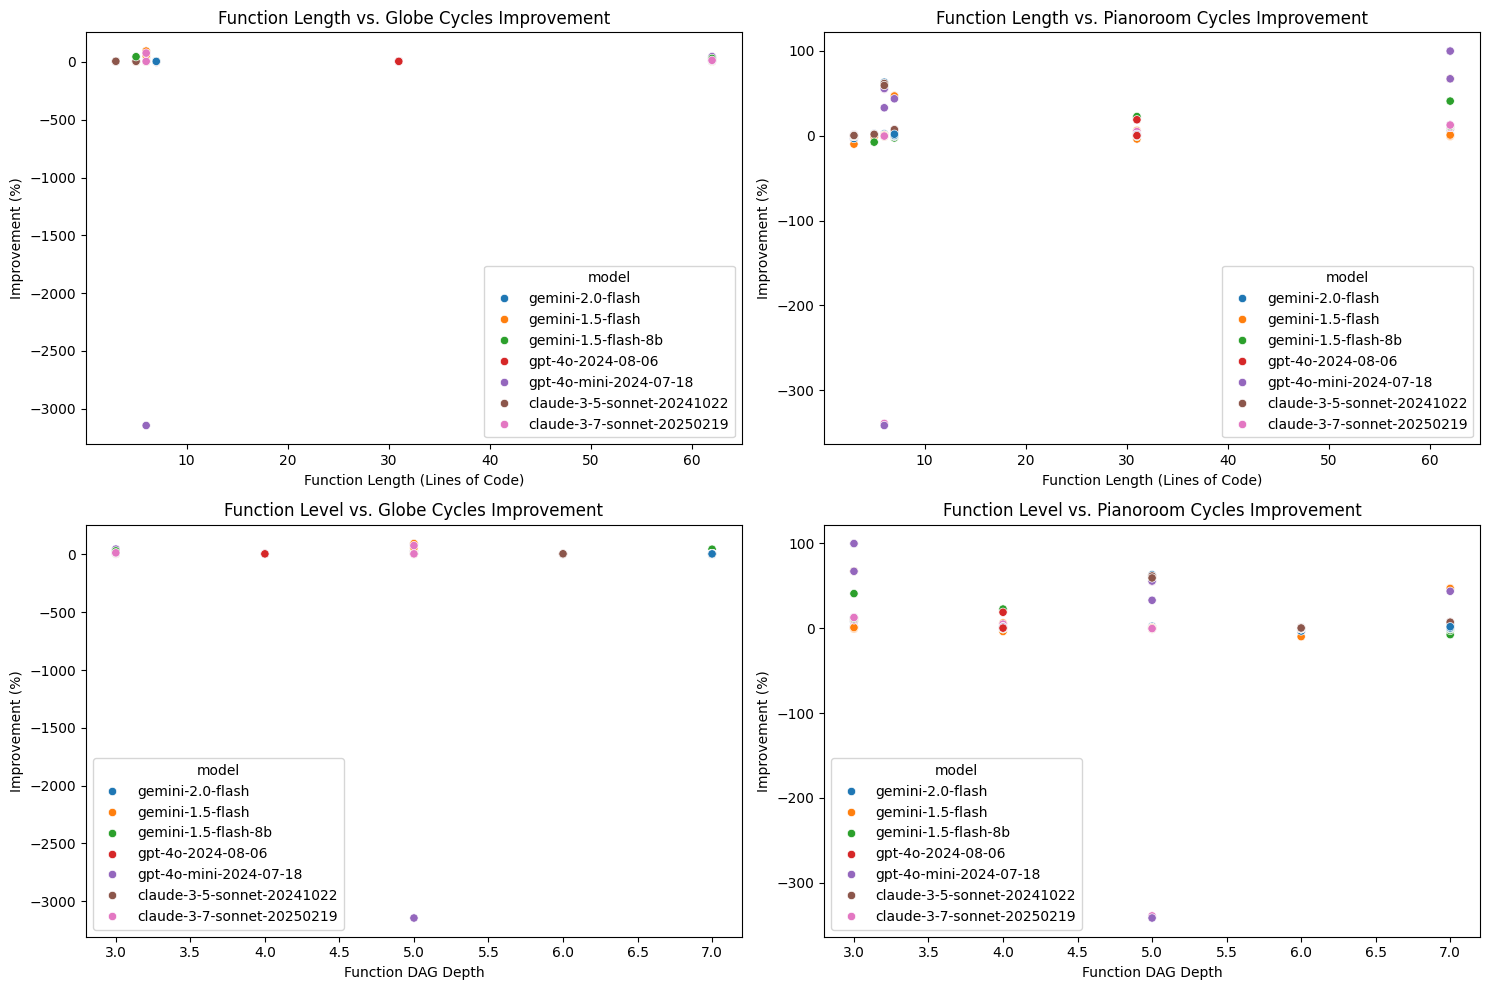

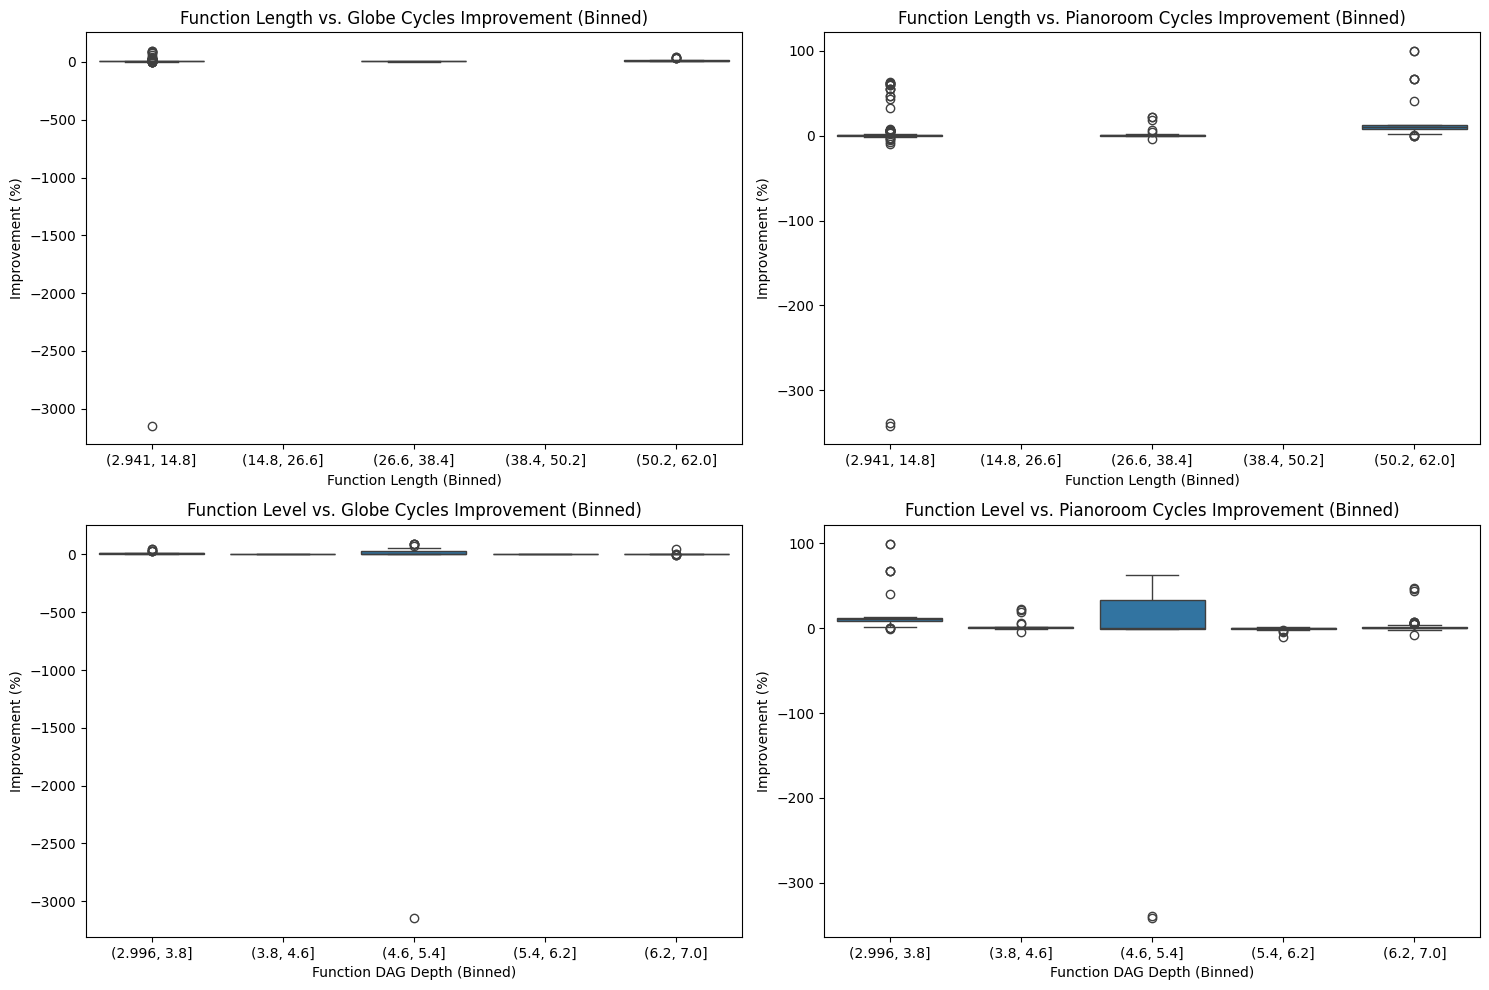

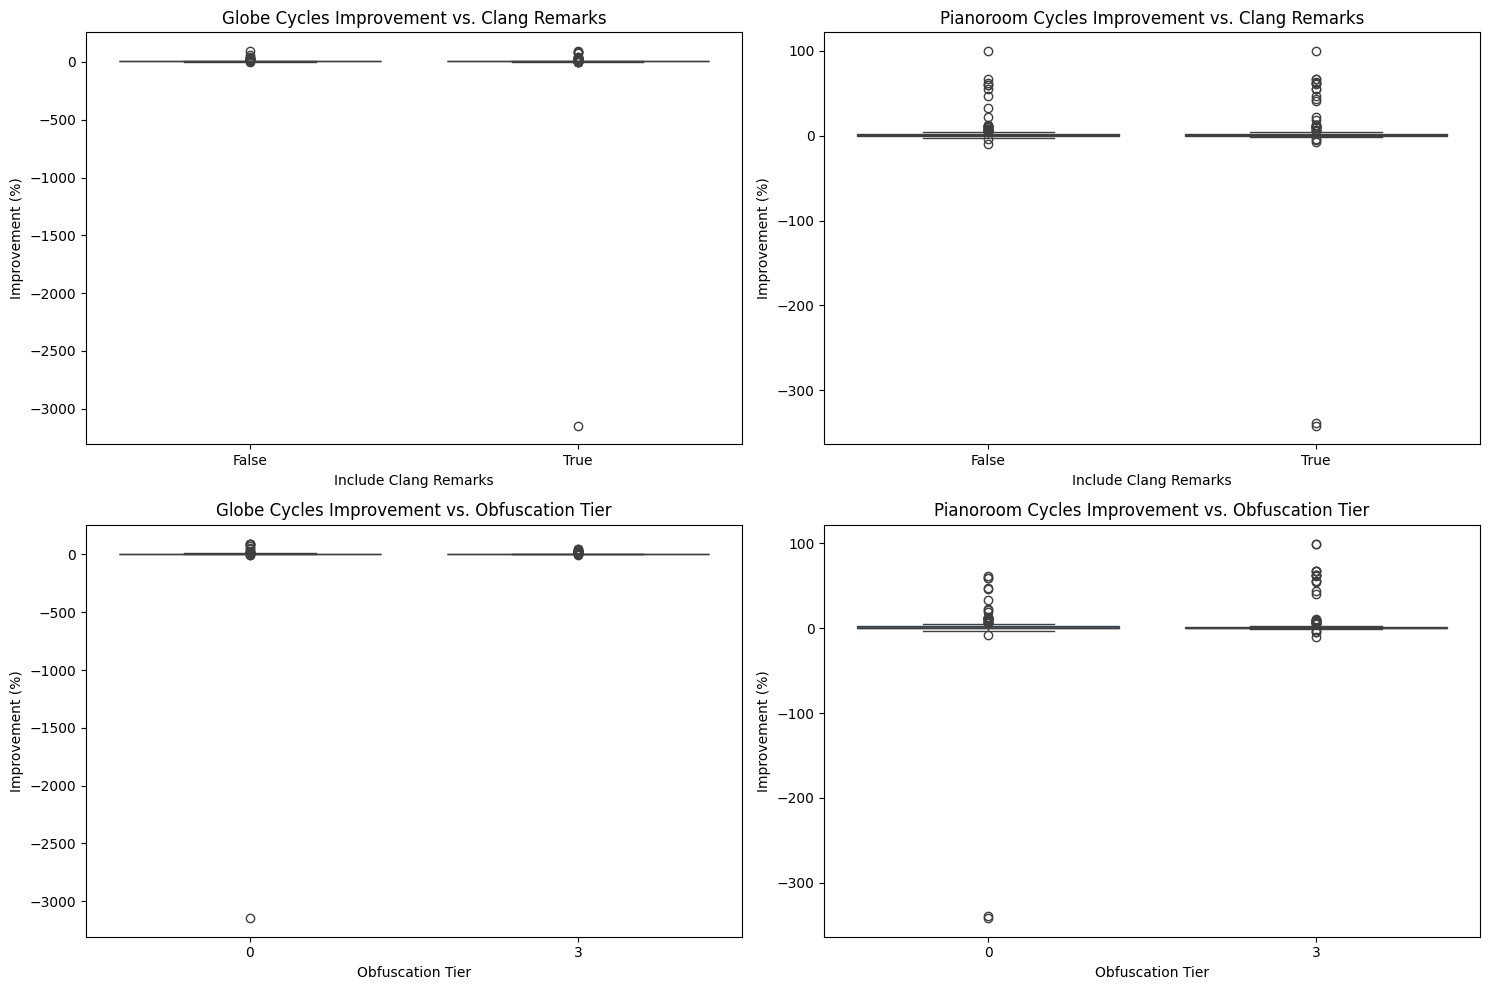

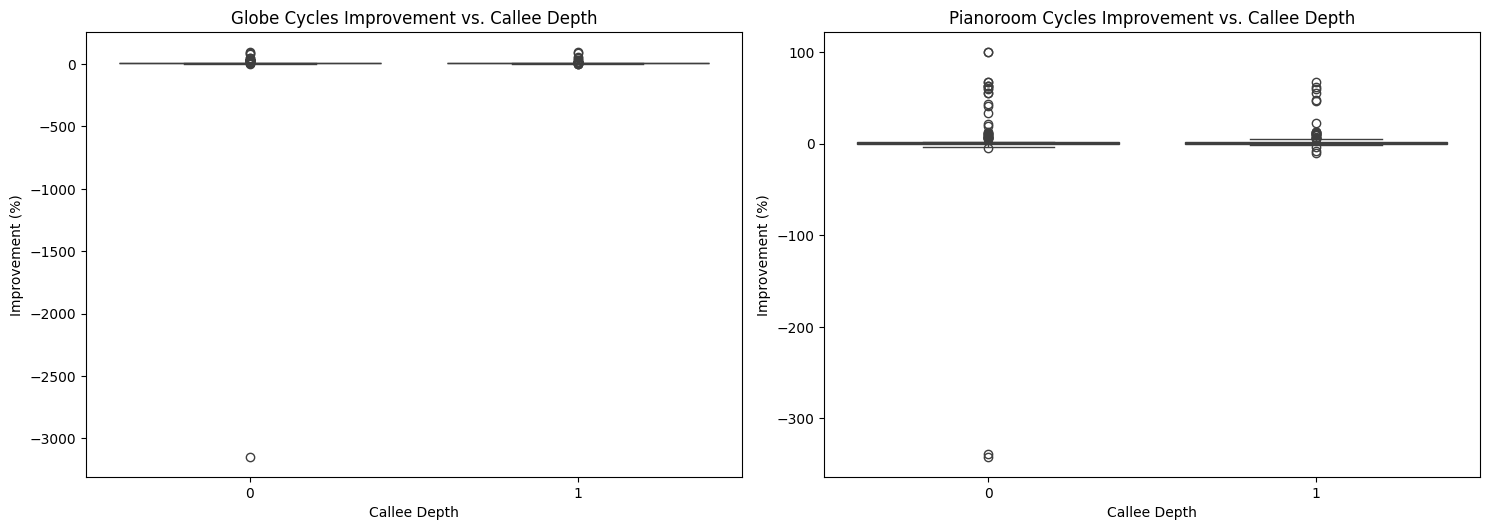

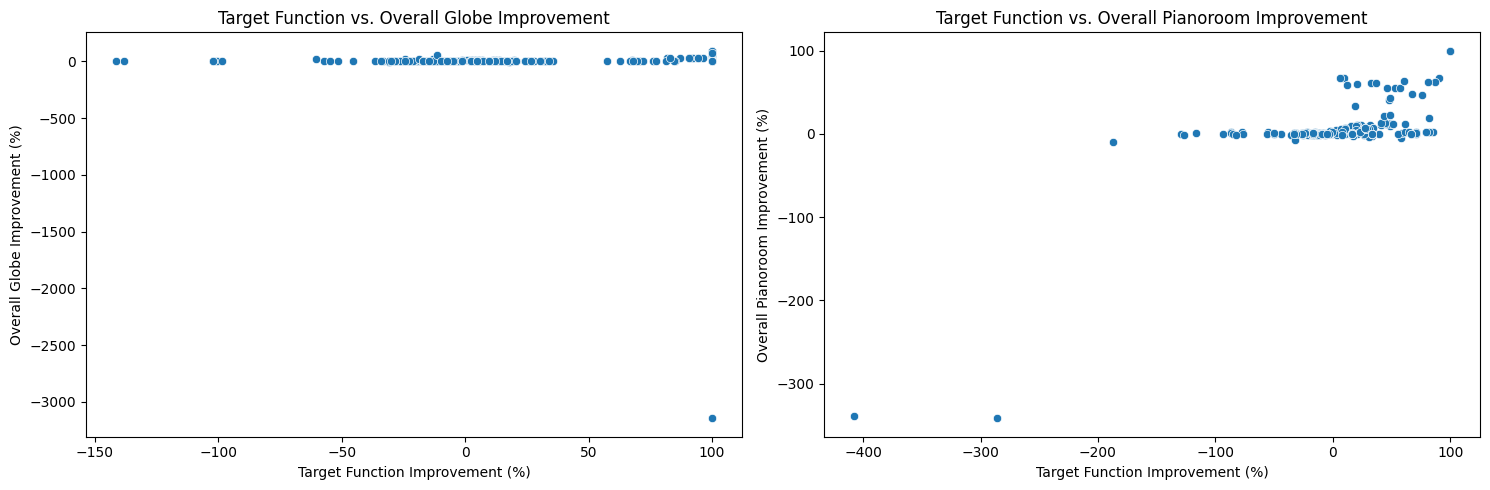

Correlations:
Globe Target vs Overall: -0.100
Pianoroom Target vs Overall: 0.719


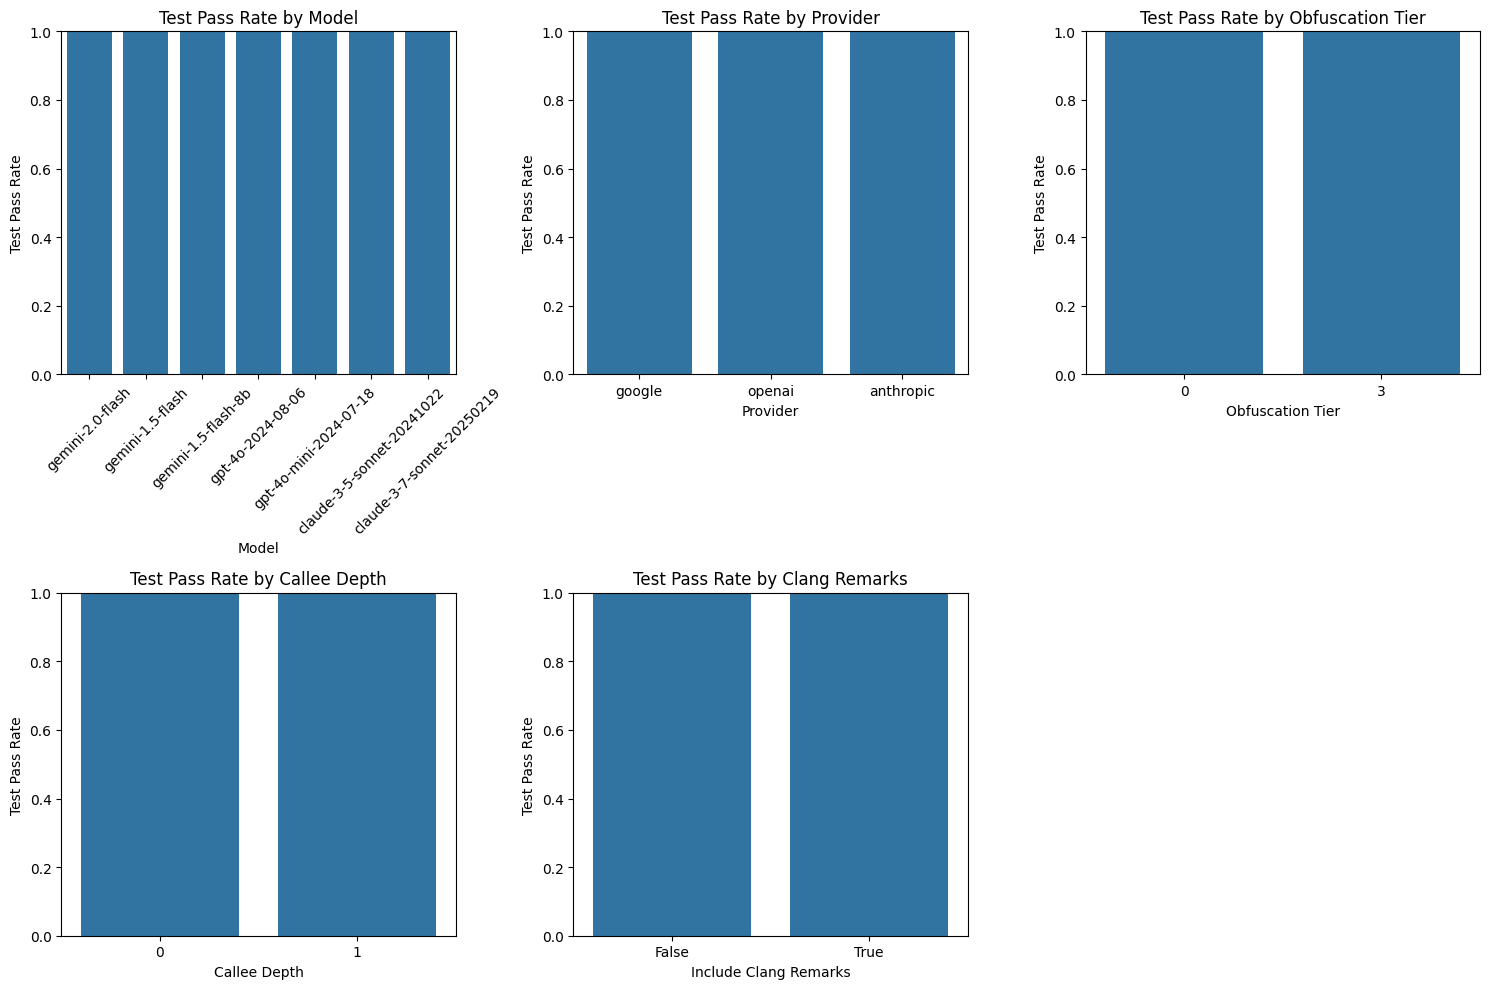

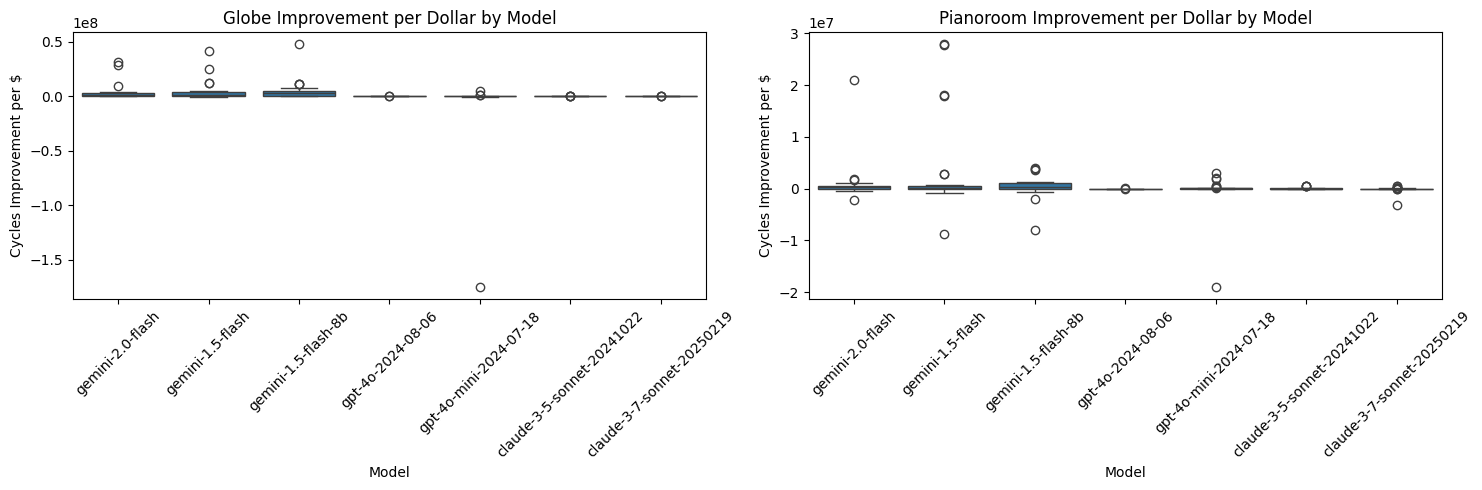

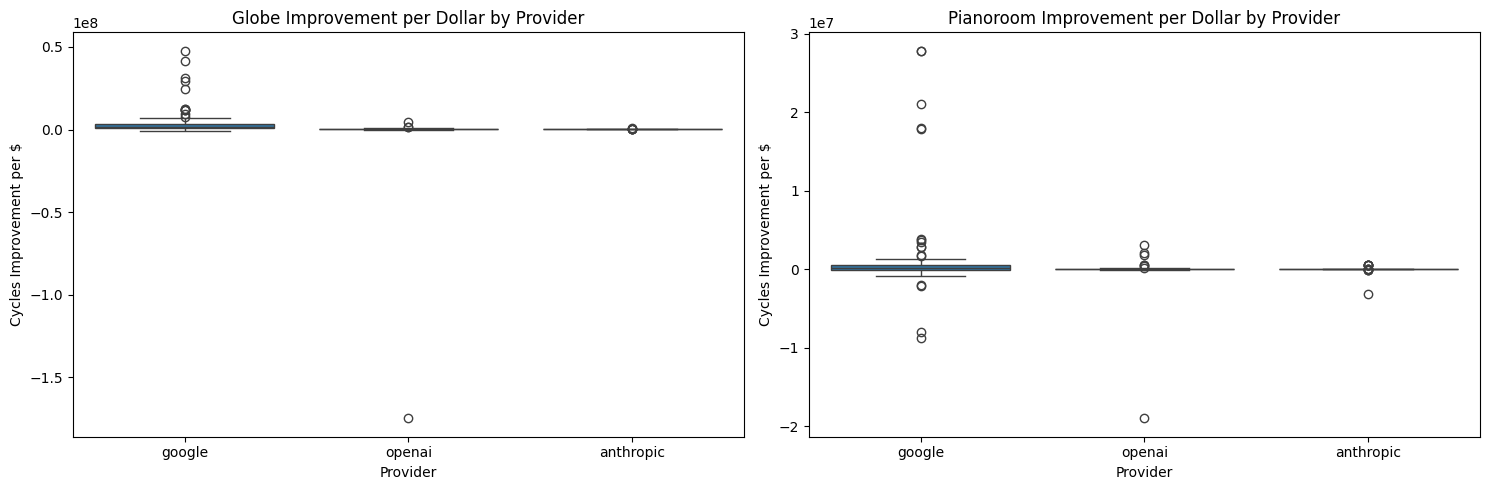

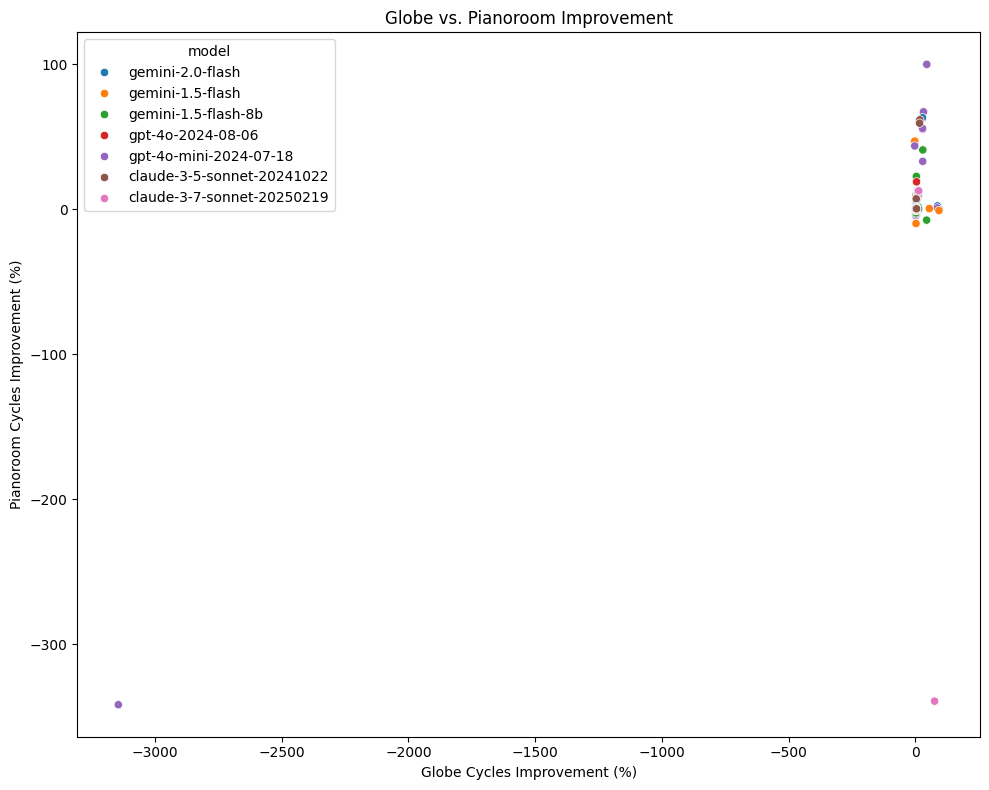

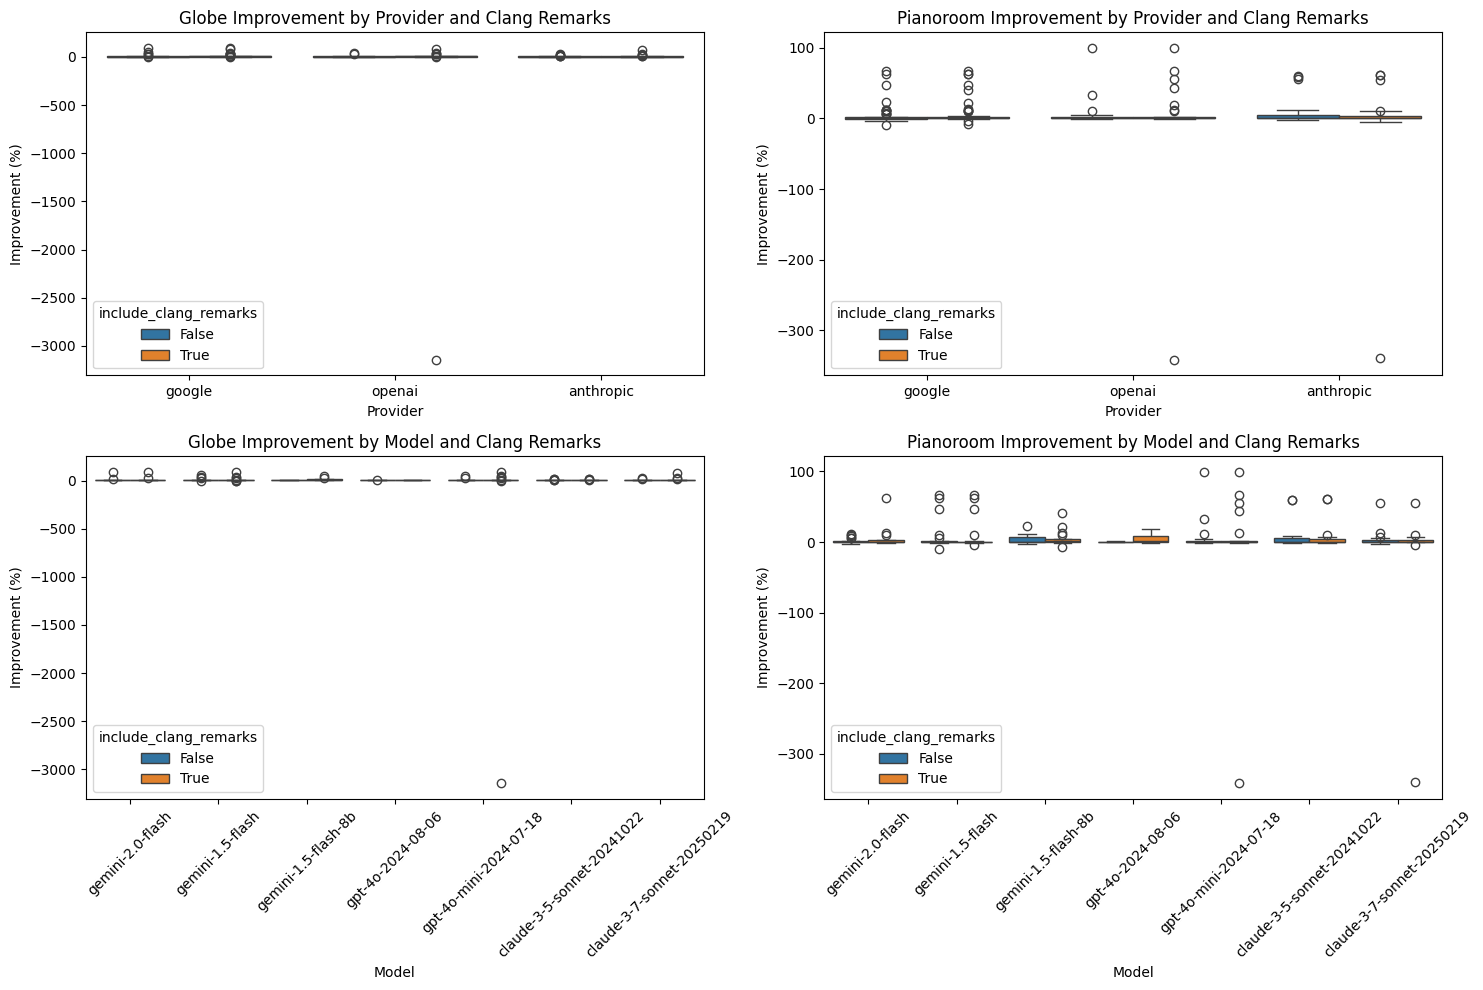

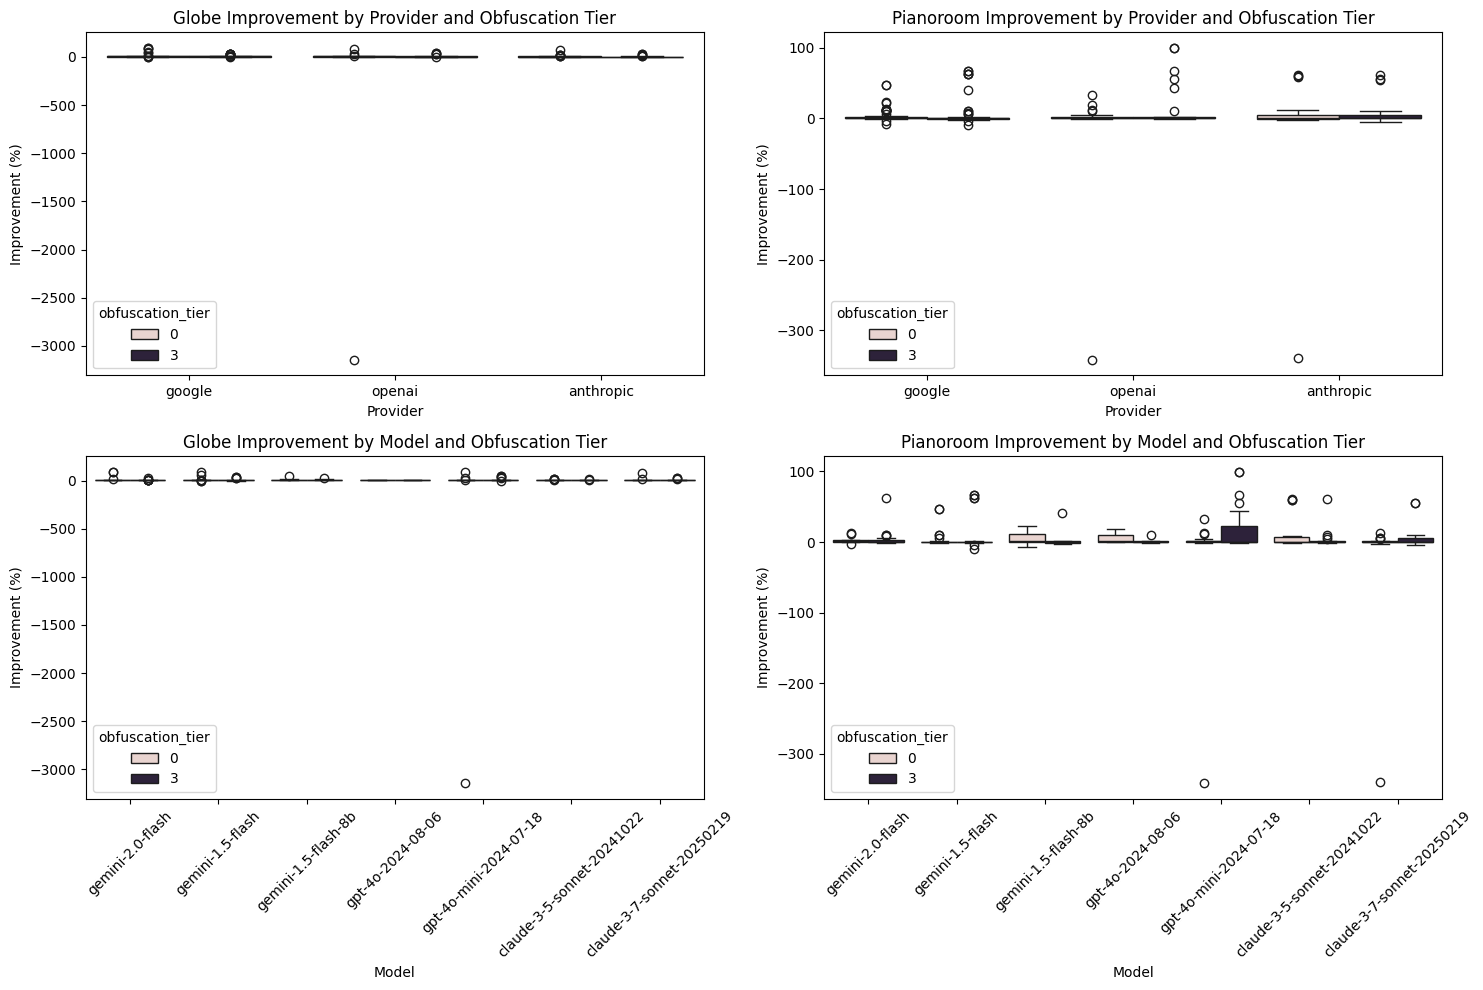

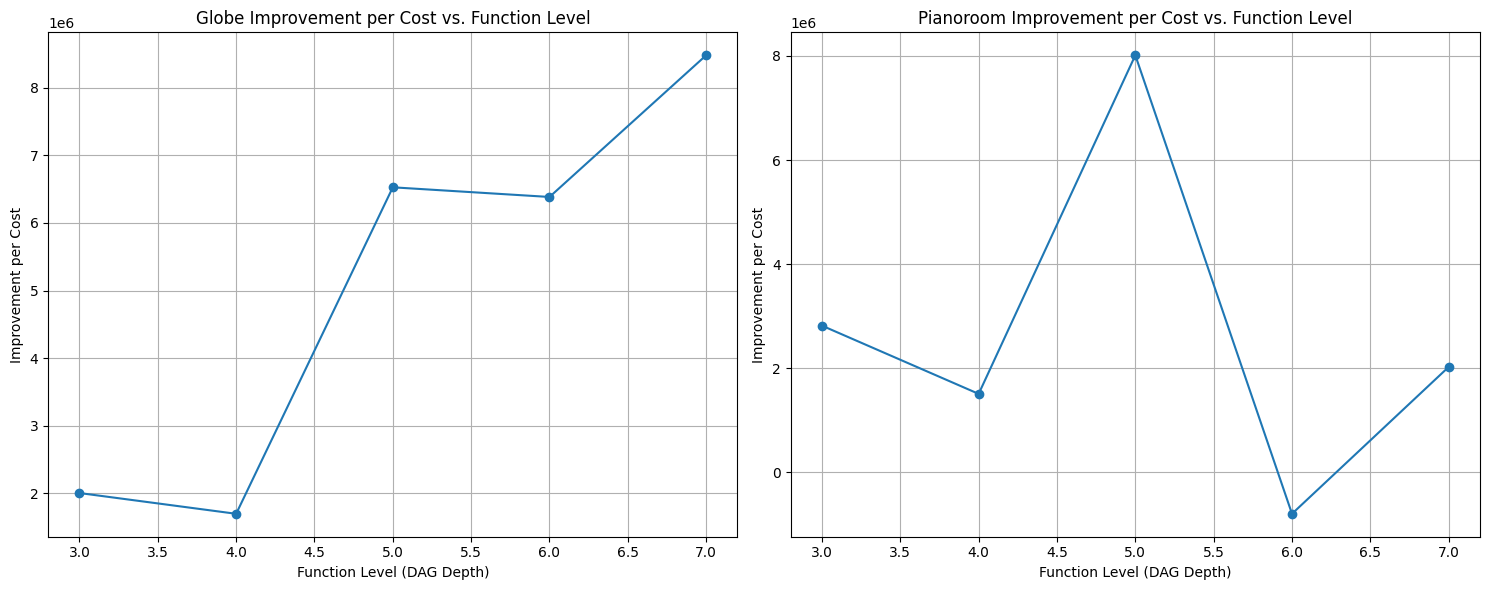


Improvement per Cost per Function Level:
   function_relative_level  globe_improvement_per_cost  \
0                        3                2.006043e+06   
1                        4                1.699072e+06   
2                        5                6.527488e+06   
3                        6                6.384717e+06   
4                        7                8.480389e+06   

   pianoroom_improvement_per_cost  function_length  
0                    2.817735e+06        62.000000  
1                    1.507161e+06        31.000000  
2                    8.013349e+06         6.000000  
3                   -7.970106e+05         3.000000  
4                    2.024350e+06         5.252632  


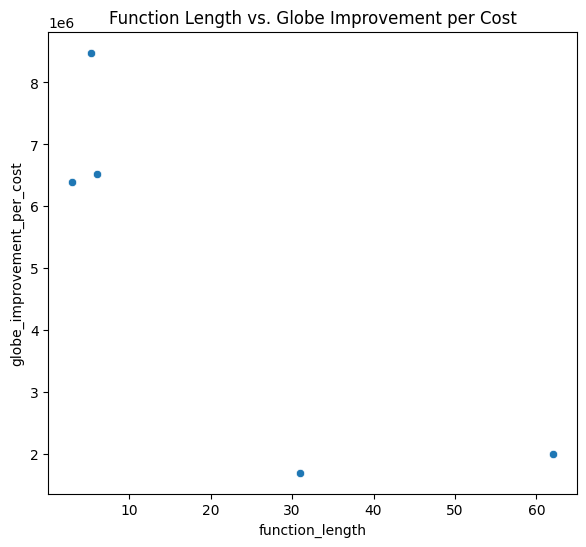

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# --- Load Data ---
df = pd.read_csv('optimization_results.csv')

# --- Basic Cleaning ---
cols_to_numeric = [
    'function_relative_level', 'function_length', 'callee_depth',
    'globe_cycles_improvement', 'pianoroom_cycles_improvement',
    'globe_runtime_improvement', 'pianoroom_runtime_improvement',
    'globe_cycles_target_function_improvement', 'pianoroom_cycles_target_function_improvement'
]
for col in cols_to_numeric:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Remove invalid improvements (0 or -1 treated as errors) and NaNs
invalid = lambda x: (x == 0) | (x == -1)
df = df[
    ~invalid(df['globe_cycles_target_function_improvement']) &
    ~invalid(df['pianoroom_cycles_target_function_improvement']) &
    ~invalid(df['globe_cycles_improvement']) &
    ~invalid(df['pianoroom_cycles_improvement']) &
    ~invalid(df['globe_runtime_improvement']) &
    ~invalid(df['pianoroom_runtime_improvement'])
]
df = df.dropna(subset=cols_to_numeric)  # Drop rows with NaN in numeric columns

# --- Map Model Costs ---
costs = {
    'gpt-4o-mini-2024-07-18': {'input': 0.60, 'output': 2.40},
    'gpt-4o-2024-08-06': {'input': 5.00, 'output': 20.00},
    'claude-3-5-sonnet-20241022': {'input': 3.00, 'output': 15.00},
    'claude-3-7-sonnet-20250219': {'input': 3.00, 'output': 15.00},
    'gemini-1.5-flash': {'input': 0.075, 'output': 0.30},
    'gemini-2.0-flash': {'input': 0.10, 'output': 0.40},
    'gemini-1.5-flash-8b': {'input': 0.0375, 'output': 0.15},
}

# Add cost columns
df['input_cost_per_mil'] = df['model'].map(lambda m: costs.get(m, {}).get('input'))
df['output_cost_per_mil'] = df['model'].map(lambda m: costs.get(m, {}).get('output'))
df = df.dropna(subset=['input_cost_per_mil', 'output_cost_per_mil']) #Drop rows where cost is NaN


# --- 1. Overall Improvement Distribution ---
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.histplot(df['globe_cycles_improvement'], kde=True)
plt.title('Globe Cycles Improvement Distribution')
plt.xlabel('Improvement (%)')

plt.subplot(2, 2, 2)
sns.histplot(df['globe_runtime_improvement'], kde=True)
plt.title('Globe Runtime Improvement Distribution')
plt.xlabel('Improvement (%)')

plt.subplot(2, 2, 3)
sns.histplot(df['pianoroom_cycles_improvement'], kde=True)
plt.title('Pianoroom Cycles Improvement Distribution')
plt.xlabel('Improvement (%)')

plt.subplot(2, 2, 4)
sns.histplot(df['pianoroom_runtime_improvement'], kde=True)
plt.title('Pianoroom Runtime Improvement Distribution')
plt.xlabel('Improvement (%)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.boxplot(y=df['globe_cycles_improvement'])
plt.title('Globe Cycles Improvement Boxplot')
plt.ylabel('Improvement (%)')

plt.subplot(2, 2, 2)
sns.boxplot(y=df['globe_runtime_improvement'])
plt.title('Globe Runtime Improvement Boxplot')
plt.ylabel('Improvement (%)')

plt.subplot(2, 2, 3)
sns.boxplot(y=df['pianoroom_cycles_improvement'])
plt.title('Pianoroom Cycles Improvement Boxplot')
plt.ylabel('Improvement (%)')

plt.subplot(2, 2, 4)
sns.boxplot(y=df['pianoroom_runtime_improvement'])
plt.title('Pianoroom Runtime Improvement Boxplot')
plt.ylabel('Improvement (%)')
plt.tight_layout()
plt.show()


# --- 2. Improvement by LLM Model ---
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.boxplot(x='model', y='globe_cycles_improvement', data=df)
plt.title('Globe Cycles Improvement by Model')
plt.xlabel('Model')
plt.ylabel('Improvement (%)')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
sns.boxplot(x='model', y='pianoroom_cycles_improvement', data=df)
plt.title('Pianoroom Cycles Improvement by Model')
plt.xlabel('Model')
plt.ylabel('Improvement (%)')
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
sns.violinplot(x='model', y='globe_cycles_improvement', data=df)
plt.title('Globe Cycles Improvement by Model (Violin)')
plt.xlabel('Model')
plt.ylabel('Improvement (%)')
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
sns.violinplot(x='model', y='pianoroom_cycles_improvement', data=df)
plt.title('Pianoroom Cycles Improvement by Model (Violin)')
plt.xlabel('Model')
plt.ylabel('Improvement (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))
sns.barplot(x='model', y='globe_cycles_improvement', data=df, errorbar='sd')  # 'sd' for standard deviation
plt.title('Average Globe Cycles Improvement by Model')
plt.xlabel('Model')
plt.ylabel('Average Improvement (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))
sns.barplot(x='model', y='pianoroom_cycles_improvement', data=df, errorbar='sd')
plt.title('Average Pianoroom Cycles Improvement by Model')
plt.xlabel('Model')
plt.ylabel('Average Improvement (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# --- 3. Improvement by LLM Provider ---
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.boxplot(x='provider', y='globe_cycles_improvement', data=df)
plt.title('Globe Cycles Improvement by Provider')
plt.xlabel('Provider')
plt.ylabel('Improvement (%)')

plt.subplot(2, 2, 2)
sns.boxplot(x='provider', y='pianoroom_cycles_improvement', data=df)
plt.title('Pianoroom Cycles Improvement by Provider')
plt.xlabel('Provider')
plt.ylabel('Improvement (%)')

plt.subplot(2, 2, 3)
sns.violinplot(x='provider', y='globe_cycles_improvement', data=df)
plt.title('Globe Cycles Improvement by Provider (Violin)')
plt.xlabel('Provider')
plt.ylabel('Improvement (%)')

plt.subplot(2, 2, 4)
sns.violinplot(x='provider', y='pianoroom_cycles_improvement', data=df)
plt.title('Pianoroom Cycles Improvement by Provider (Violin)')
plt.xlabel('Provider')
plt.ylabel('Improvement (%)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))
sns.barplot(x='provider', y='globe_cycles_improvement', data=df, errorbar='sd')
plt.title('Average Globe Cycles Improvement by Provider')
plt.xlabel('Provider')
plt.ylabel('Average Improvement (%)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))
sns.barplot(x='provider', y='pianoroom_cycles_improvement', data=df, errorbar='sd')
plt.title('Average Pianoroom Cycles Improvement by Provider')
plt.xlabel('Provider')
plt.ylabel('Average Improvement (%)')
plt.tight_layout()
plt.show()


# --- 4. Impact of Code Characteristics on Improvement ---
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.scatterplot(x='function_length', y='globe_cycles_improvement', hue='model', data=df)
plt.title('Function Length vs. Globe Cycles Improvement')
plt.xlabel('Function Length (Lines of Code)')
plt.ylabel('Improvement (%)')

plt.subplot(2, 2, 2)
sns.scatterplot(x='function_length', y='pianoroom_cycles_improvement', hue='model', data=df)
plt.title('Function Length vs. Pianoroom Cycles Improvement')
plt.xlabel('Function Length (Lines of Code)')
plt.ylabel('Improvement (%)')

plt.subplot(2, 2, 3)
sns.scatterplot(x='function_relative_level', y='globe_cycles_improvement', hue='model', data=df)
plt.title('Function Level vs. Globe Cycles Improvement')
plt.xlabel('Function DAG Depth')
plt.ylabel('Improvement (%)')

plt.subplot(2, 2, 4)
sns.scatterplot(x='function_relative_level', y='pianoroom_cycles_improvement', hue='model', data=df)
plt.title('Function Level vs. Pianoroom Cycles Improvement')
plt.xlabel('Function DAG Depth')
plt.ylabel('Improvement (%)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.boxplot(x=pd.cut(df['function_length'], bins=5), y='globe_cycles_improvement', data=df)
plt.title('Function Length vs. Globe Cycles Improvement (Binned)')
plt.xlabel('Function Length (Binned)')
plt.ylabel('Improvement (%)')

plt.subplot(2, 2, 2)
sns.boxplot(x=pd.cut(df['function_length'], bins=5), y='pianoroom_cycles_improvement', data=df)
plt.title('Function Length vs. Pianoroom Cycles Improvement (Binned)')
plt.xlabel('Function Length (Binned)')
plt.ylabel('Improvement (%)')

plt.subplot(2, 2, 3)
sns.boxplot(x=pd.cut(df['function_relative_level'], bins=5), y='globe_cycles_improvement', data=df)
plt.title('Function Level vs. Globe Cycles Improvement (Binned)')
plt.xlabel('Function DAG Depth (Binned)')
plt.ylabel('Improvement (%)')

plt.subplot(2, 2, 4)
sns.boxplot(x=pd.cut(df['function_relative_level'], bins=5), y='pianoroom_cycles_improvement', data=df)
plt.title('Function Level vs. Pianoroom Cycles Improvement (Binned)')
plt.xlabel('Function DAG Depth (Binned)')
plt.ylabel('Improvement (%)')
plt.tight_layout()
plt.show()


# --- 5. Effect of Optimization Parameters ---
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.boxplot(x='include_clang_remarks', y='globe_cycles_improvement', data=df)
plt.title('Globe Cycles Improvement vs. Clang Remarks')
plt.xlabel('Include Clang Remarks')
plt.ylabel('Improvement (%)')

plt.subplot(2, 2, 2)
sns.boxplot(x='include_clang_remarks', y='pianoroom_cycles_improvement', data=df)
plt.title('Pianoroom Cycles Improvement vs. Clang Remarks')
plt.xlabel('Include Clang Remarks')
plt.ylabel('Improvement (%)')

plt.subplot(2, 2, 3)
sns.boxplot(x='obfuscation_tier', y='globe_cycles_improvement', data=df)
plt.title('Globe Cycles Improvement vs. Obfuscation Tier')
plt.xlabel('Obfuscation Tier')
plt.ylabel('Improvement (%)')

plt.subplot(2, 2, 4)
sns.boxplot(x='obfuscation_tier', y='pianoroom_cycles_improvement', data=df)
plt.title('Pianoroom Cycles Improvement vs. Obfuscation Tier')
plt.xlabel('Obfuscation Tier')
plt.ylabel('Improvement (%)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.boxplot(x='callee_depth', y='globe_cycles_improvement', data=df)
plt.title('Globe Cycles Improvement vs. Callee Depth')
plt.xlabel('Callee Depth')
plt.ylabel('Improvement (%)')

plt.subplot(2, 2, 2)
sns.boxplot(x='callee_depth', y='pianoroom_cycles_improvement', data=df)
plt.title('Pianoroom Cycles Improvement vs. Callee Depth')
plt.xlabel('Callee Depth')
plt.ylabel('Improvement (%)')
plt.tight_layout()
plt.show()



# --- 6. Relationship Between Target Function Improvement and Overall Improvement ---
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='globe_cycles_target_function_improvement', y='globe_cycles_improvement', data=df)
plt.title('Target Function vs. Overall Globe Improvement')
plt.xlabel('Target Function Improvement (%)')
plt.ylabel('Overall Globe Improvement (%)')

plt.subplot(1, 2, 2)
sns.scatterplot(x='pianoroom_cycles_target_function_improvement', y='pianoroom_cycles_improvement', data=df)
plt.title('Target Function vs. Overall Pianoroom Improvement')
plt.xlabel('Target Function Improvement (%)')
plt.ylabel('Overall Pianoroom Improvement (%)')
plt.tight_layout()
plt.show()

print("Correlations:")
print(f"Globe Target vs Overall: {df['globe_cycles_target_function_improvement'].corr(df['globe_cycles_improvement']):.3f}")
print(f"Pianoroom Target vs Overall: {df['pianoroom_cycles_target_function_improvement'].corr(df['pianoroom_cycles_improvement']):.3f}")


# --- 7. Test Pass Rate Analysis ---
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
sns.barplot(x='model', y='tests_passed', data=df)
plt.title('Test Pass Rate by Model')
plt.xlabel('Model')
plt.ylabel('Test Pass Rate')
plt.xticks(rotation=45)
plt.ylim(0, 1)

plt.subplot(2, 3, 2)
sns.barplot(x='provider', y='tests_passed', data=df)
plt.title('Test Pass Rate by Provider')
plt.xlabel('Provider')
plt.ylabel('Test Pass Rate')
plt.ylim(0, 1)

plt.subplot(2, 3, 3)
sns.barplot(x='obfuscation_tier', y='tests_passed', data=df)
plt.title('Test Pass Rate by Obfuscation Tier')
plt.xlabel('Obfuscation Tier')
plt.ylabel('Test Pass Rate')
plt.ylim(0, 1)

plt.subplot(2, 3, 4)
sns.barplot(x='callee_depth', y='tests_passed', data=df)
plt.title('Test Pass Rate by Callee Depth')
plt.xlabel('Callee Depth')
plt.ylabel('Test Pass Rate')
plt.ylim(0, 1)

plt.subplot(2, 3, 5)
sns.barplot(x='include_clang_remarks', y='tests_passed', data=df)
plt.title('Test Pass Rate by Clang Remarks')
plt.xlabel('Include Clang Remarks')
plt.ylabel('Test Pass Rate')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# --- 8. Cost-Benefit Analysis ---
if 'input_cost_per_mil' in df.columns and 'output_cost_per_mil' in df.columns:
    df['cost'] = (df['input_cost_per_mil'] * (df['function_length'] / 1000000)) + \
                   (df['output_cost_per_mil'] * (df['function_length'] / 1000000))  # Simplified cost - assumes cost is proportional to function length.
    df['globe_improvement_per_dollar'] = df['globe_cycles_improvement'] / df['cost']
    df['pianoroom_improvement_per_dollar'] = df['pianoroom_cycles_improvement'] / df['cost']
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    sns.boxplot(x='model', y='globe_improvement_per_dollar', data=df)
    plt.title('Globe Improvement per Dollar by Model')
    plt.xlabel('Model')
    plt.ylabel('Cycles Improvement per $')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x='model', y='pianoroom_improvement_per_dollar', data=df)
    plt.title('Pianoroom Improvement per Dollar by Model')
    plt.xlabel('Model')
    plt.ylabel('Cycles Improvement per $')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    sns.boxplot(x='provider', y='globe_improvement_per_dollar', data=df)
    plt.title('Globe Improvement per Dollar by Provider')
    plt.xlabel('Provider')
    plt.ylabel('Cycles Improvement per $')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x='provider', y='pianoroom_improvement_per_dollar', data=df)
    plt.title('Pianoroom Improvement per Dollar by Provider')
    plt.xlabel('Provider')
    plt.ylabel('Cycles Improvement per $')
    plt.tight_layout()
    plt.show()
else:
    print("Skipping cost-benefit analysis: 'input_cost_per_mil' or 'output_cost_per_mil' columns not found.")



# --- 10. Comparing Globe and Pianoroom Benchmarks ---
plt.figure(figsize=(10, 8))
sns.scatterplot(x='globe_cycles_improvement', y='pianoroom_cycles_improvement', hue='model', data=df)
plt.title('Globe vs. Pianoroom Improvement')
plt.xlabel('Globe Cycles Improvement (%)')
plt.ylabel('Pianoroom Cycles Improvement (%)')
plt.tight_layout()
plt.show()

# --- 11. Clang Remarks and Obfuscation vs. Improvement by Provider and Model ---

# Clang Remarks
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.boxplot(x='provider', y='globe_cycles_improvement', hue='include_clang_remarks', data=df)
plt.title('Globe Improvement by Provider and Clang Remarks')
plt.xlabel('Provider')
plt.ylabel('Improvement (%)')

plt.subplot(2, 2, 2)
sns.boxplot(x='provider', y='pianoroom_cycles_improvement', hue='include_clang_remarks', data=df)
plt.title('Pianoroom Improvement by Provider and Clang Remarks')
plt.xlabel('Provider')
plt.ylabel('Improvement (%)')

plt.subplot(2, 2, 3)
sns.boxplot(x='model', y='globe_cycles_improvement', hue='include_clang_remarks', data=df)
plt.title('Globe Improvement by Model and Clang Remarks')
plt.xlabel('Model')
plt.ylabel('Improvement (%)')
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
sns.boxplot(x='model', y='pianoroom_cycles_improvement', hue='include_clang_remarks', data=df)
plt.title('Pianoroom Improvement by Model and Clang Remarks')
plt.xlabel('Model')
plt.ylabel('Improvement (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Obfuscation Tier
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.boxplot(x='provider', y='globe_cycles_improvement', hue='obfuscation_tier', data=df)
plt.title('Globe Improvement by Provider and Obfuscation Tier')
plt.xlabel('Provider')
plt.ylabel('Improvement (%)')

plt.subplot(2, 2, 2)
sns.boxplot(x='provider', y='pianoroom_cycles_improvement', hue='obfuscation_tier', data=df)
plt.title('Pianoroom Improvement by Provider and Obfuscation Tier')
plt.xlabel('Provider')
plt.ylabel('Improvement (%)')

plt.subplot(2, 2, 3)
sns.boxplot(x='model', y='globe_cycles_improvement', hue='obfuscation_tier', data=df)
plt.title('Globe Improvement by Model and Obfuscation Tier')
plt.xlabel('Model')
plt.ylabel('Improvement (%)')
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
sns.boxplot(x='model', y='pianoroom_cycles_improvement', hue='obfuscation_tier', data=df)
plt.title('Pianoroom Improvement by Model and Obfuscation Tier')
plt.xlabel('Model')
plt.ylabel('Improvement (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# --- 12. Improvement per Cost per Level Analysis ---
if 'input_cost_per_mil' in df.columns:  # Ensure cost data is available
    # Calculate improvement per cost
    df['globe_improvement_per_cost'] = df['globe_cycles_improvement'] / (df['input_cost_per_mil'] * (df['function_length'] / 1e6))
    df['pianoroom_improvement_per_cost'] = df['pianoroom_cycles_improvement'] / (df['input_cost_per_mil'] * (df['function_length'] / 1e6))

    # Group by function level and calculate mean improvement per cost
    level_analysis = df.groupby('function_relative_level').agg({
        'globe_improvement_per_cost': 'mean',
        'pianoroom_improvement_per_cost': 'mean',
        'function_length': 'mean',  # Add this line
    }).reset_index()

    # --- Plotting ---
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.plot(level_analysis['function_relative_level'], level_analysis['globe_improvement_per_cost'], marker='o')
    plt.title('Globe Improvement per Cost vs. Function Level')
    plt.xlabel('Function Level (DAG Depth)')
    plt.ylabel('Improvement per Cost')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(level_analysis['function_relative_level'], level_analysis['pianoroom_improvement_per_cost'], marker='o')
    plt.title('Pianoroom Improvement per Cost vs. Function Level')
    plt.xlabel('Function Level (DAG Depth)')
    plt.ylabel('Improvement per Cost')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # --- Print Summary ---
    print("\nImprovement per Cost per Function Level:")
    print(level_analysis)

    # Additional plots: Scatter plot of function length vs improvement per cost
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    sns.scatterplot(x='function_length', y='globe_improvement_per_cost', data=level_analysis)
    plt.title('Function Length vs. Globe Improvement per Cost')

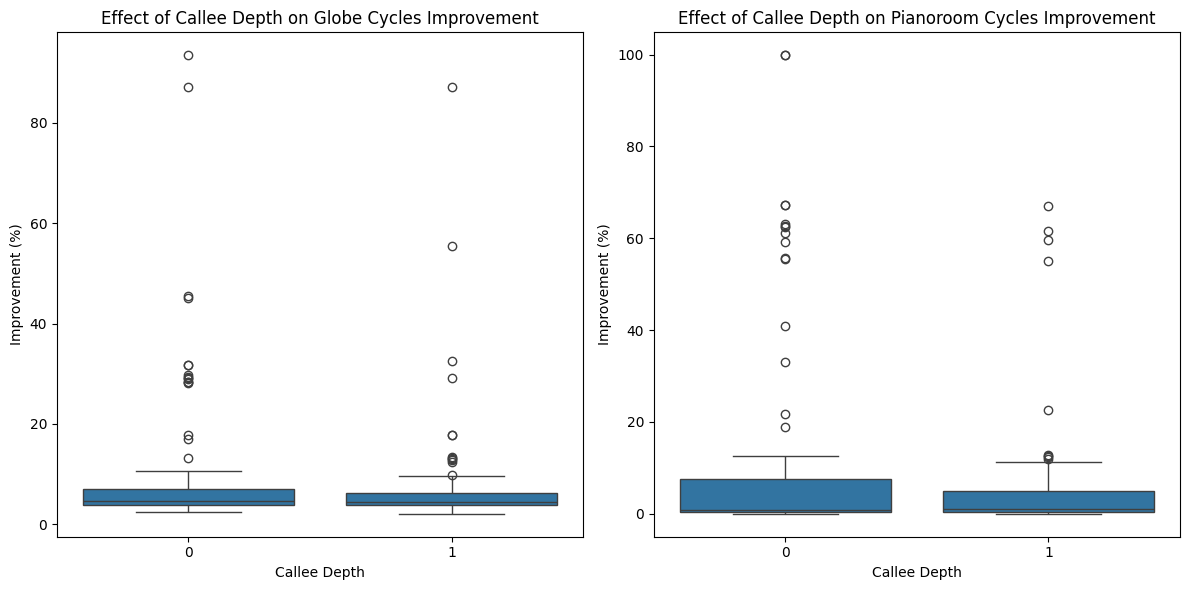

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows with non-positive improvement values
filtered_df = df[
    (df['globe_cycles_improvement'] > 0) & 
    (df['pianoroom_cycles_improvement'] > 0)
]

plt.figure(figsize=(12, 6))

# Plot: Globe Cycles Improvement
plt.subplot(1, 2, 1)
sns.boxplot(x='callee_depth', y='globe_cycles_improvement', data=filtered_df)
plt.title('Effect of Callee Depth on Globe Cycles Improvement')
plt.xlabel('Callee Depth')
plt.ylabel('Improvement (%)')

# Plot: Pianoroom Cycles Improvement
plt.subplot(1, 2, 2)
sns.boxplot(x='callee_depth', y='pianoroom_cycles_improvement', data=filtered_df)
plt.title('Effect of Callee Depth on Pianoroom Cycles Improvement')
plt.xlabel('Callee Depth')
plt.ylabel('Improvement (%)')

plt.tight_layout()
plt.show()


In [51]:
import pandas as pd

# Filter to only positive improvements
filtered_df = df[
    (df['globe_cycles_improvement'] > 0) &
    (df['pianoroom_cycles_improvement'] > 0)
]

# Separate groups
with_remarks = filtered_df[filtered_df['include_clang_remarks'] == True]
without_remarks = filtered_df[filtered_df['include_clang_remarks'] == False]

# Calculate means and delta
impact = {
    'Metric': ['Globe', 'Pianoroom'],
    'Without Clang Remarks Mean (%)': [
        without_remarks['globe_cycles_improvement'].mean(),
        without_remarks['pianoroom_cycles_improvement'].mean()
    ],
    'With Clang Remarks Mean (%)': [
        with_remarks['globe_cycles_improvement'].mean(),
        with_remarks['pianoroom_cycles_improvement'].mean()
    ],
    'Delta (With - Without) (%)': [
        with_remarks['globe_cycles_improvement'].mean() - without_remarks['globe_cycles_improvement'].mean(),
        with_remarks['pianoroom_cycles_improvement'].mean() - without_remarks['pianoroom_cycles_improvement'].mean()
    ]
}

impact_df = pd.DataFrame(impact)
print(impact_df)


      Metric  Without Clang Remarks Mean (%)  With Clang Remarks Mean (%)  \
0      Globe                        8.674971                     9.343303   
1  Pianoroom                        8.048388                     9.021699   

   Delta (With - Without) (%)  
0                    0.668332  
1                    0.973312  


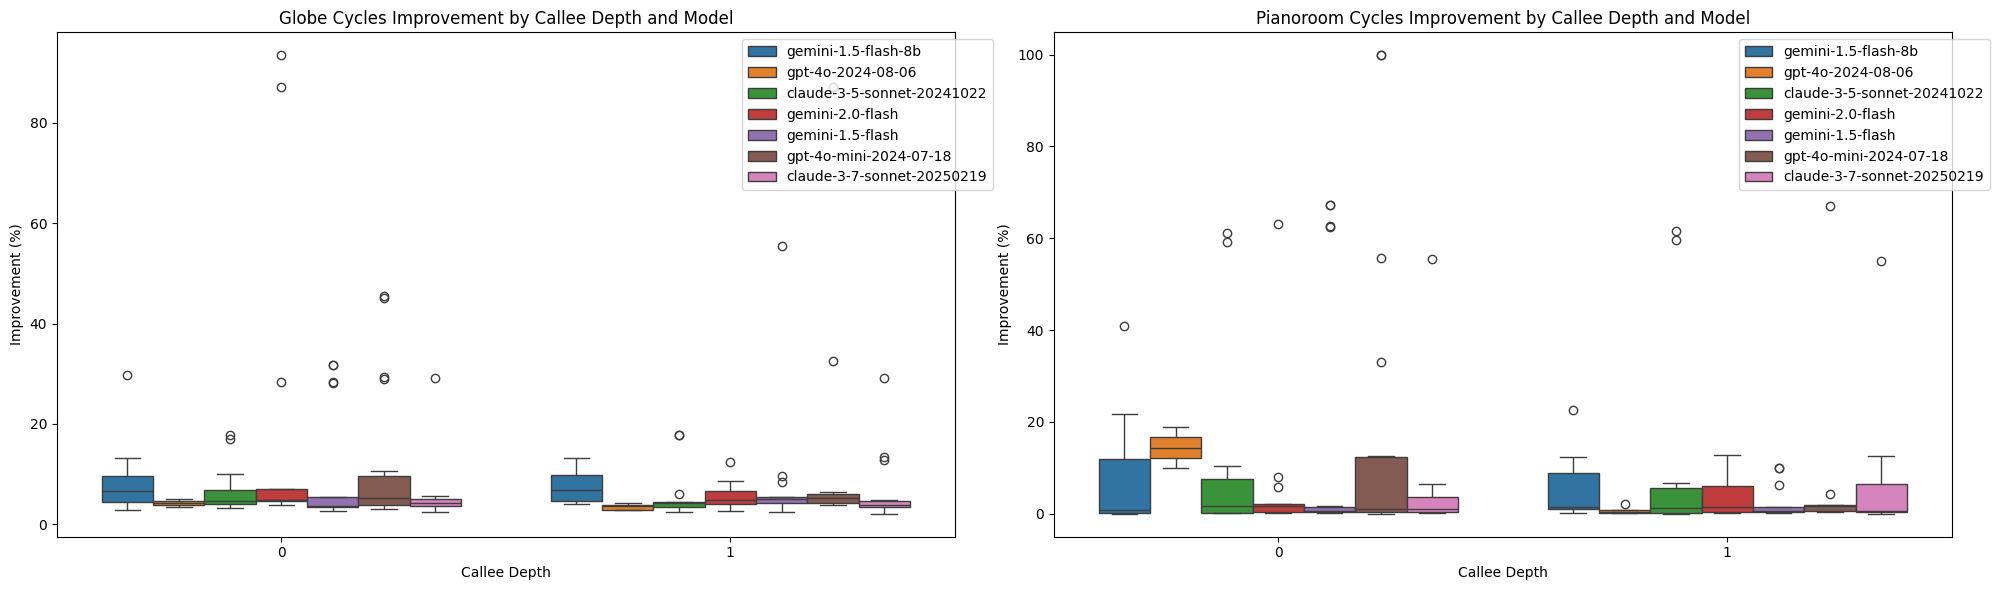

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter to positive improvements
filtered_df = df[
    (df['globe_cycles_improvement'] > 0) & 
    (df['pianoroom_cycles_improvement'] > 0)
]

plt.figure(figsize=(20, 6))

# Globe Cycles Improvement by Model
plt.subplot(1, 2, 1)
sns.boxplot(x='callee_depth', y='globe_cycles_improvement', hue='model', data=filtered_df)
plt.title('Globe Cycles Improvement by Callee Depth and Model')
plt.xlabel('Callee Depth')
plt.ylabel('Improvement (%)')
plt.legend(loc='upper right', bbox_to_anchor=(1.05, 1))

# Pianoroom Cycles Improvement by Model
plt.subplot(1, 2, 2)
sns.boxplot(x='callee_depth', y='pianoroom_cycles_improvement', hue='model', data=filtered_df)
plt.title('Pianoroom Cycles Improvement by Callee Depth and Model')
plt.xlabel('Callee Depth')
plt.ylabel('Improvement (%)')
plt.legend(loc='upper right', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()


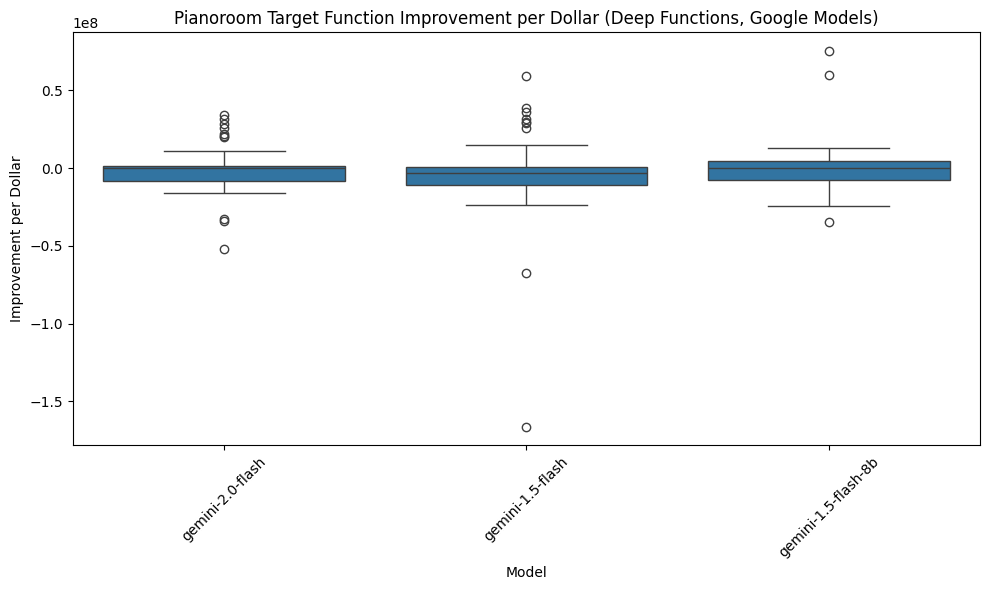

model
gemini-1.5-flash-8b    9.798501e+05
gemini-2.0-flash      -6.605546e+05
gemini-1.5-flash      -4.617533e+06
Name: pianoroom_target_improvement_per_dollar, dtype: float64


In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('optimization_results.csv')

# Step 1: Filter to Google models only
google_df = df[df['model'].str.startswith('gemini-')].copy()

# Step 2: Focus on deeper functions
deep_functions_df = google_df[google_df['function_relative_level'] >= 0].copy()

# ----------- IMPORTANT: RECOMPUTE COST COLUMNS! -----------

costs = {
    'gpt-4o-mini-2024-07-18': {'input': 0.60, 'output': 2.40},
    'gpt-4o-2024-08-06': {'input': 5.00, 'output': 20.00},
    'claude-3-5-sonnet-20241022': {'input': 3.00, 'output': 15.00},
    'claude-3-7-sonnet-20250219': {'input': 3.00, 'output': 15.00},
    'gemini-1.5-flash': {'input': 0.075, 'output': 0.30},
    'gemini-2.0-flash': {'input': 0.10, 'output': 0.40},
    'gemini-1.5-flash-8b': {'input': 0.0375, 'output': 0.15},
}

# Add cost columns
deep_functions_df['input_cost_per_mil'] = deep_functions_df['model'].map(lambda m: costs.get(m, {}).get('input', np.nan))
deep_functions_df['output_cost_per_mil'] = deep_functions_df['model'].map(lambda m: costs.get(m, {}).get('output', np.nan))

# Step 3: Calculate cost
deep_functions_df['cost'] = (
    (deep_functions_df['input_cost_per_mil'] * (deep_functions_df['function_length'] / 1_000_000)) +
    (deep_functions_df['output_cost_per_mil'] * (deep_functions_df['function_length'] / 1_000_000))
)

# Step 4: Calculate improvement per dollar
deep_functions_df['pianoroom_target_improvement_per_dollar'] = (
    deep_functions_df['pianoroom_cycles_target_function_improvement'] / deep_functions_df['cost']
)

# Step 5: Plot improvement per dollar
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='model', y='pianoroom_target_improvement_per_dollar', data=deep_functions_df)
plt.title('Pianoroom Target Function Improvement per Dollar (Deep Functions, Google Models)')
plt.xlabel('Model')
plt.ylabel('Improvement per Dollar')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# (Optional) Also print average values
print(deep_functions_df.groupby('model')['pianoroom_target_improvement_per_dollar'].mean().sort_values(ascending=False))



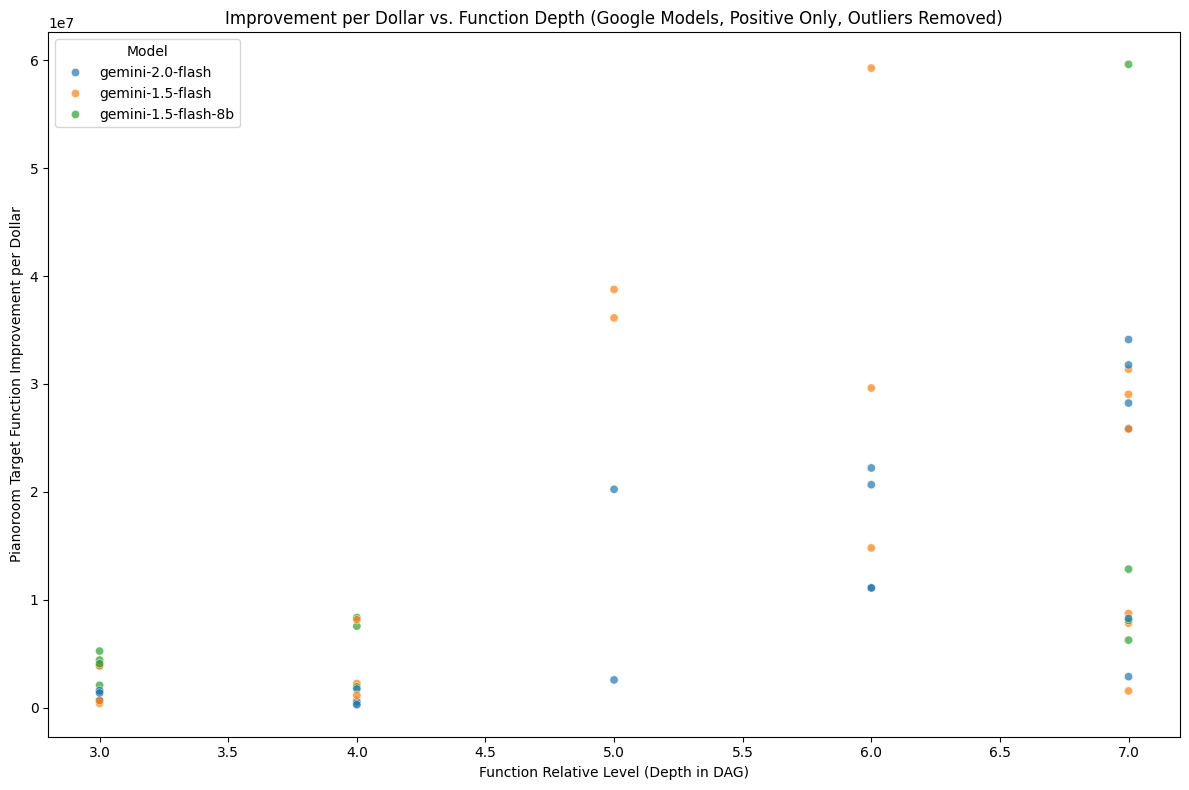

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# (Assuming deep_functions_df is already prepared)

# Step 1: Remove negative improvements
deep_functions_df = deep_functions_df[
    deep_functions_df['pianoroom_cycles_target_function_improvement'] > 0
].copy()

# Step 2: Remove extreme outliers in "improvement per dollar"
lower = deep_functions_df['pianoroom_target_improvement_per_dollar'].quantile(0.01)
upper = deep_functions_df['pianoroom_target_improvement_per_dollar'].quantile(0.99)

filtered_df = deep_functions_df[
    (deep_functions_df['pianoroom_target_improvement_per_dollar'] >= lower) &
    (deep_functions_df['pianoroom_target_improvement_per_dollar'] <= upper)
].copy()

# Step 3: Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='function_relative_level',
    y='pianoroom_target_improvement_per_dollar',
    hue='model',
    data=filtered_df,
    alpha=0.7
)
plt.title('Improvement per Dollar vs. Function Depth (Google Models, Positive Only, Outliers Removed)')
plt.xlabel('Function Relative Level (Depth in DAG)')
plt.ylabel('Pianoroom Target Function Improvement per Dollar')
plt.legend(title='Model')
plt.tight_layout()
plt.show()
